In [29]:
#Nb magic to interactive plots
#%matplotlib ipympl
%matplotlib inline
# Nb magic to automatically reload the module when it changes
%load_ext autoreload
%autoreload 2



In [30]:
# Relevant libraries
import warnings

# Suppress only UserWarnings
warnings.simplefilter("ignore", category = UserWarning)

import math
import torch as tn
import torchtt as tntt
import numpy as np

import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline,BarycentricInterpolator, Rbf

from utils import *

from IPython import get_ipython

def pmagic(value):
    ip = get_ipython()
    if value:
        ip.run_line_magic("matplotlib", "ipympl")
    else:

        ip.run_line_magic("matplotlib", "inline")


# Interpolation Theory

## Polynomial interpolation

<!-- Introduction -->
Given a function $f(x)$ defined on an interval $[a,b]$ and a set of $n+1$ distinct points $\{x_i\}_{i=0}^n$ in this interval, we seek a polynomial $p(x)$ that interpolates $f$ at these points, meaning $p(x_i) = f(x_i)$ for all $i$. The polynomial in lagrange form would be:

$$
p(x) = \sum_{i=0}^n f(x_i) \prod_{j\neq i} \frac{x-x_j}{x_i-x_j}.
$$


**Chebyshev Polynomial Interpolation**

In Chebyshev interpolation, the interpolation nodes are chosen to be the Chebyshev nodes, which are given on the interval $[-1,1]$ by
$$
x_i = \cos\left(\frac{2i+1}{2(n+1)}\pi\right),\quad i=0,1,\dots,n.
$$
These nodes cluster near the endpoints of the interval, which helps mitigate the Runge phenomenon observed with uniformly spaced nodes.

The Chebyshev polynomials of the first kind, denoted by $T_k(x)$, are defined as
$$
T_k(x) = \cos\bigl(k \arccos(x)\bigr),\quad k=0,1,\dots,
$$
and form an orthogonal basis on $[-1,1]$ with respect to the weight function
$$
w(x)=\frac{1}{\sqrt{1-x^2}}.
$$

To interpolate a function $f(x)$ using Chebyshev polynomials, one can compute the Chebyshev coefficients from the function values at the Chebyshev nodes. The interpolant is then expressed as a series
$$
p_n(x)=\sum_{k=0}^{n} c_k\,T_k(x),
$$
where the coefficients $c_k$ are determined either via discrete orthogonality or by applying the barycentric interpolation formula. This approach yields a polynomial interpolation that is typically more stable and accurate than the standard Lagrange interpolation with equidistant nodes.


**Cubic Spline Interpolation**

In contrast to global polynomial interpolation, *cubic spline interpolation* divides the interval $[a,b]$ into subintervals defined by the nodes $\{x_i\}_{i=0}^n$ and fits a cubic polynomial on each subinterval. These cubic pieces are then connected at the nodes in such a way that the resulting spline is not only continuous but also has continuous first and second derivatives. This piecewise approach allows for a flexible and smooth approximation, particularly well-suited for functions that exhibit rapid changes or high curvature.




<!-- Example -->
Let's start with a simple example of a rational function

$$ f(x)  = \frac{1}{1+\alpha(x-\beta)^2} $$

In [190]:
# Example
N = 30  # Number of interpolation nodes
# Rational Function
f = lambda x: 1/(1 + 100*(x-0.5)**2)
# Step function
#f = lambda x: np.where((x >= 0.1) & (x <= 0.6), 1.0, 0.0)

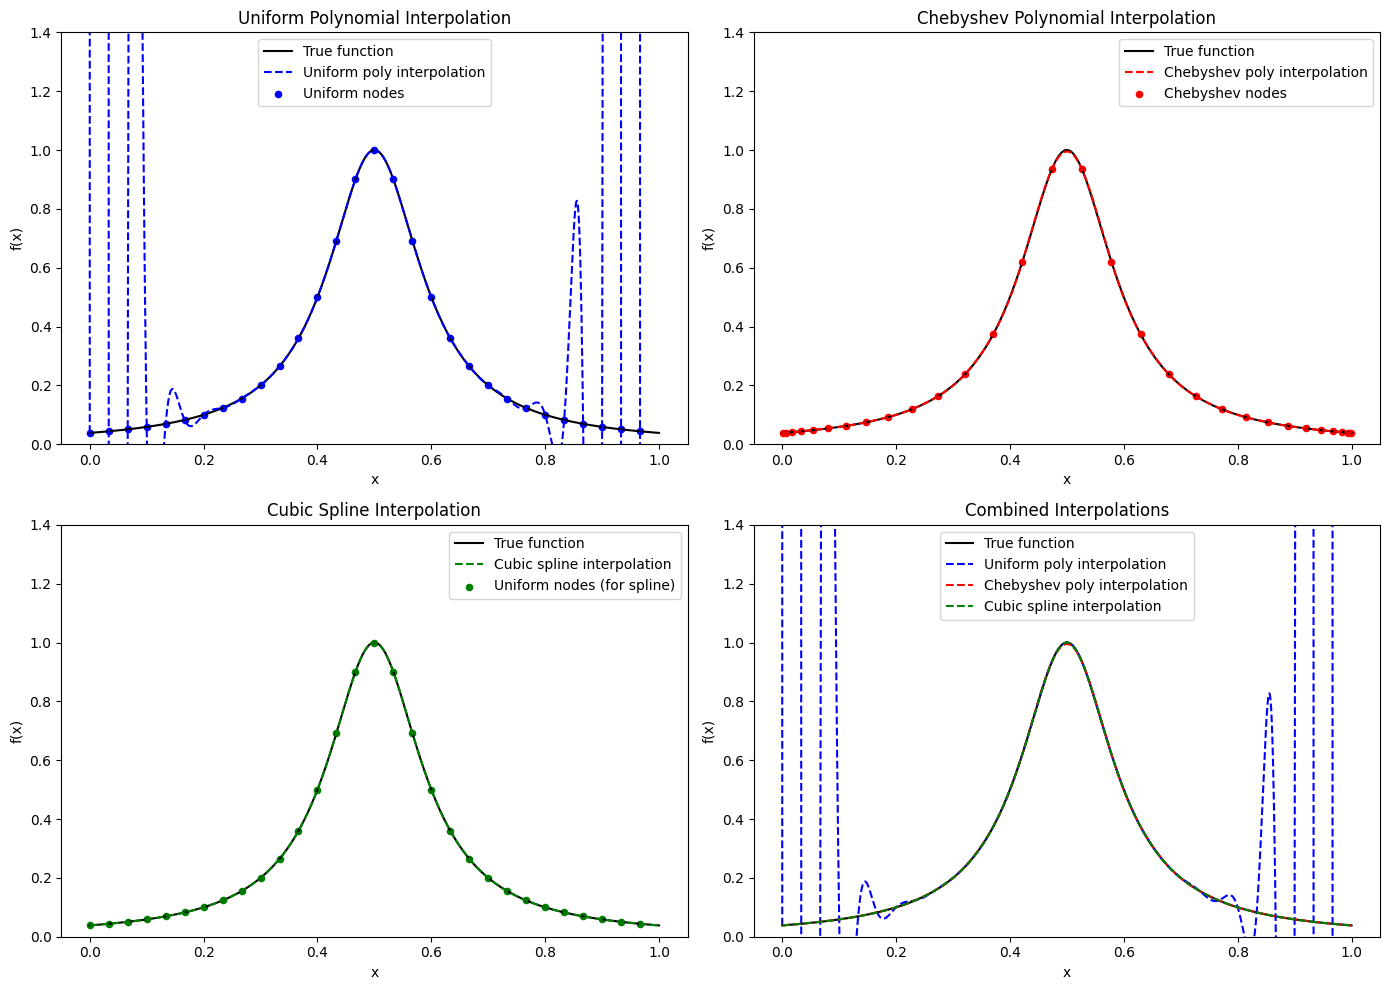

Uniform Polynomial L2 Error:    7.1e+04
Chebyshev Polynomial  L2 Error: 3.6e-03
Cubic Spline  L2 Error:         4.9e-04


In [191]:
# Polynomial interpolation

# Generate the uniform grid on [0,1]
x_uniform = np.linspace(0, 1, N,endpoint=False)
y_uniform = f(x_uniform)

# Uniform polynomial interpolation using Lagrange interpolation
#poly_uniform = lagrange(x_uniform, y_uniform)
polyuniform = BarycentricInterpolator(x_uniform, y_uniform)

# Generate the Chebyshev grid on [0,1]
# Chebyshev nodes for [a,b]: x_i = 0.5*(a+b) + 0.5*(b-a)*cos((2*i+1)*pi/(2*N))
i = np.arange(N)
x_cheb = 0.5 + 0.5 * np.cos((2*i + 1) * np.pi / (2 * N))
x_cheb = np.sort(x_cheb)  # sort in increasing order
y_cheb = f(x_cheb)

# Chebyshev polynomial interpolation
#poly_cheb = lagrange(x_cheb, y_cheb)
# Instead of using lagrange, use BarycentricInterpolator
barycheb = BarycentricInterpolator(x_cheb, y_cheb)

# Cubic spline interpolation on the uniform grid
cs = CubicSpline(x_uniform, y_uniform)

# Fine grid for plotting and error computation
x_fine = np.linspace(0, 1, 1000)
y_true = f(x_fine)
#y_poly_uniform = poly_uniform(x_fine)
#y_poly_cheb = poly_cheb(x_fine)
y_poly_uniform = polyuniform(x_fine)
y_poly_cheb = barycheb(x_fine)
y_spline = cs(x_fine)

# --- Creating 4 Subplots in One Figure ---
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Subplot 1: Uniform Polynomial Interpolation
axs[0, 0].plot(x_fine, y_true, 'k-', label='True function')
axs[0, 0].plot(x_fine, y_poly_uniform, 'b--', label='Uniform poly interpolation')
axs[0, 0].scatter(x_uniform, y_uniform, color='b', label='Uniform nodes',s=20)
axs[0, 0].set_title('Uniform Polynomial Interpolation')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('f(x)')
axs[0, 0].grid(False)
axs[0, 0].set_ylim(0, 1.4)
axs[0, 0].legend()

# Subplot 2: Chebyshev Polynomial Interpolation
axs[0, 1].plot(x_fine, y_true, 'k-', label='True function')
axs[0, 1].plot(x_fine, y_poly_cheb, 'r--', label='Chebyshev poly interpolation')
axs[0, 1].scatter(x_cheb, y_cheb, color='r', label='Chebyshev nodes',s=20)
axs[0, 1].set_title('Chebyshev Polynomial Interpolation')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('f(x)')
axs[0, 1].grid(False)
axs[0, 1].set_ylim(0, 1.4)
axs[0, 1].legend()

# Subplot 3: Cubic Spline Interpolation
axs[1, 0].plot(x_fine, y_true, 'k-', label='True function')
axs[1, 0].plot(x_fine, y_spline, 'g--', label='Cubic spline interpolation')
axs[1, 0].scatter(x_uniform, y_uniform, color='g', label='Uniform nodes (for spline)',s=20) 
axs[1, 0].set_title('Cubic Spline Interpolation')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('f(x)')
axs[1, 0].grid(False)
axs[1, 0].set_ylim(0, 1.4)
axs[1, 0].legend()

# Subplot 4: Combined Interpolations
axs[1, 1].plot(x_fine, y_true, 'k-', label='True function')
axs[1, 1].plot(x_fine, y_poly_uniform, 'b--', label='Uniform poly interpolation')
axs[1, 1].plot(x_fine, y_poly_cheb, 'r--', label='Chebyshev poly interpolation')
axs[1, 1].plot(x_fine, y_spline, 'g--', label='Cubic spline interpolation')
axs[1, 1].set_title('Combined Interpolations')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('f(x)')
axs[1, 1].grid(False)
axs[1, 1].set_ylim(0, 1.4)
axs[1, 1].legend()

plt.tight_layout()
plt.show()


# Compute normalized L2 errors for each method:
# Normalized L2 error = ||f_approx - f_true|| / ||f_true||
err_uniform = np.linalg.norm(y_poly_uniform - y_true) / np.linalg.norm(y_true)
err_cheb = np.linalg.norm(y_poly_cheb - y_true) / np.linalg.norm(y_true)
err_spline = np.linalg.norm(y_spline - y_true) / np.linalg.norm(y_true)

# ANSI escape codes for yellow coloring
yellow = "\033[93m"
endc = "\033[0m"

# Print the errors with colored method names
print(f"{yellow}Uniform Polynomial{endc} L2 Error:    {err_uniform:.1e}")
print(f"{yellow}Chebyshev Polynomial{endc}  L2 Error: {err_cheb:.1e}")
print(f"{yellow}Cubic Spline{endc}  L2 Error:         {err_spline:.1e}")


### Condition Numbers

<!-- Theory -->

For a polynomial

$$
p(t)=\sum_{k=0}^n c_k\,\phi_k(t)
$$

is expressed in some basis $\{\phi_k(t)\}$, then the “value” condition number at a point $t$ is defined by

$$
C(p(t))=\sum_{k=0}^n |c_k|\,|\phi_k(t)|.
$$

For example, in the standard power (monomial) basis with $\phi_k(t)=t^k$ the condition number is

$$
C_{\rm power}(t)=\sum_{k=0}^n |a_k|\,|t|^k,
$$

while in the Bernstein basis on $[0,1]$ with

$$
B_{k,n}(t)=\binom{n}{k}t^k(1-t)^{n-k},
$$

the condition number is

$$
C_{\rm Bernstein}(t)=\sum_{k=0}^n |c_k|\,B_{k,n}(t).
$$

A key theoretical result is that among all nonnegative bases for degree‑$n$ polynomials on $[0,1]$, the Bernstein basis is “optimally stable” – that is, for any polynomial \(p(t)\) we have

$$
C_{\rm Bernstein}(t) \le C_{\rm power}(t),\quad\forall\,t\in[0,1].
$$


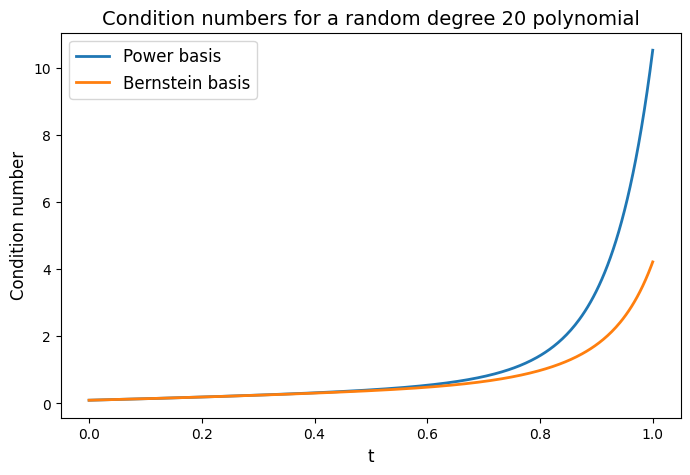

In [158]:
# Pure condition number
n = 20

# Generate random power basis coefficients (e.g., uniformly from [-1,1])
np.random.seed(0)
a = np.random.uniform(-1, 1, n+1)

# Define the Bernstein basis functions for degree n
def bernstein_basis(n, t):
    # Returns an array of shape (len(t), n+1) with B_{k,n}(t)
    t = np.atleast_1d(t)
    B = np.zeros((len(t), n+1))
    for k in range(n+1):
        B[:, k] = comb(n, k) * (t**k) * ((1-t)**(n-k))
    return B

# Define the condition number for a polynomial given a basis evaluation.
# For power basis: phi_k(t) = t^k.
def cond_power(a, t):
    # a: power coefficients (length n+1)
    # t: scalar or array of points in [0,1]
    t = np.atleast_1d(t)
    cond = np.zeros_like(t)
    for k in range(len(a)):
        cond += np.abs(a[k]) * (t**k)
    return cond

# To convert from power coefficients 'a' to Bernstein coefficients 'c',
# we use the fact that the Bernstein basis expanded in the power basis is:
#   B_{j,n}(t) = sum_{i=j}^n (-1)^(i-j) * binom(n, j) * binom(n-j, i-j) * t^i.
# Thus, if
#   p(t) = sum_{i=0}^n a_i t^i = sum_{j=0}^n c_j B_{j,n}(t),
# then for i=0,...,n, we have:
#   a_i = sum_{j=0}^i T[i,j] * c_j,
# where T[i,j] = (-1)^(i-j)*comb(n, j)*comb(n-j, i-j) for i >= j, and 0 for i<j.
# Since T is lower-triangular, we can solve for c.

def power_to_bernstein(a, n):
    T = np.zeros((n+1, n+1))
    for i in range(n+1):
        for j in range(i+1):
            T[i, j] = ((-1)**(i-j)) * comb(n, j) * comb(n-j, i-j)
    # Solve T * c = a for c
    c = np.linalg.solve(T, a)
    return c

# Compute Bernstein coefficients from the power coefficients
c = power_to_bernstein(a, n)

# Define the condition number for the Bernstein basis:
# For Bernstein, phi_k(t)=B_{k,n}(t)
def cond_bernstein(c, n, t):
    B = bernstein_basis(n, t)  # shape (len(t), n+1)
    # Compute the weighted sum of absolute values
    return np.sum(np.abs(c) * B, axis=1)

# Evaluate over a grid in [0, 1]
t_vals = np.linspace(0, 1, 400)
cond_power_vals = cond_power(a, t_vals)
cond_bernstein_vals = cond_bernstein(c, n, t_vals)

# Plot the condition numbers
plt.figure(figsize=(8,5))
plt.plot(t_vals, cond_power_vals, label="Power basis", lw=2)
plt.plot(t_vals, cond_bernstein_vals, label="Bernstein basis", lw=2)
plt.xlabel("t", fontsize=12)
plt.ylabel("Condition number", fontsize=12)
plt.title(f"Condition numbers for a random degree {n} polynomial", fontsize=14)
plt.legend(fontsize=12)
plt.grid(False)
plt.show()


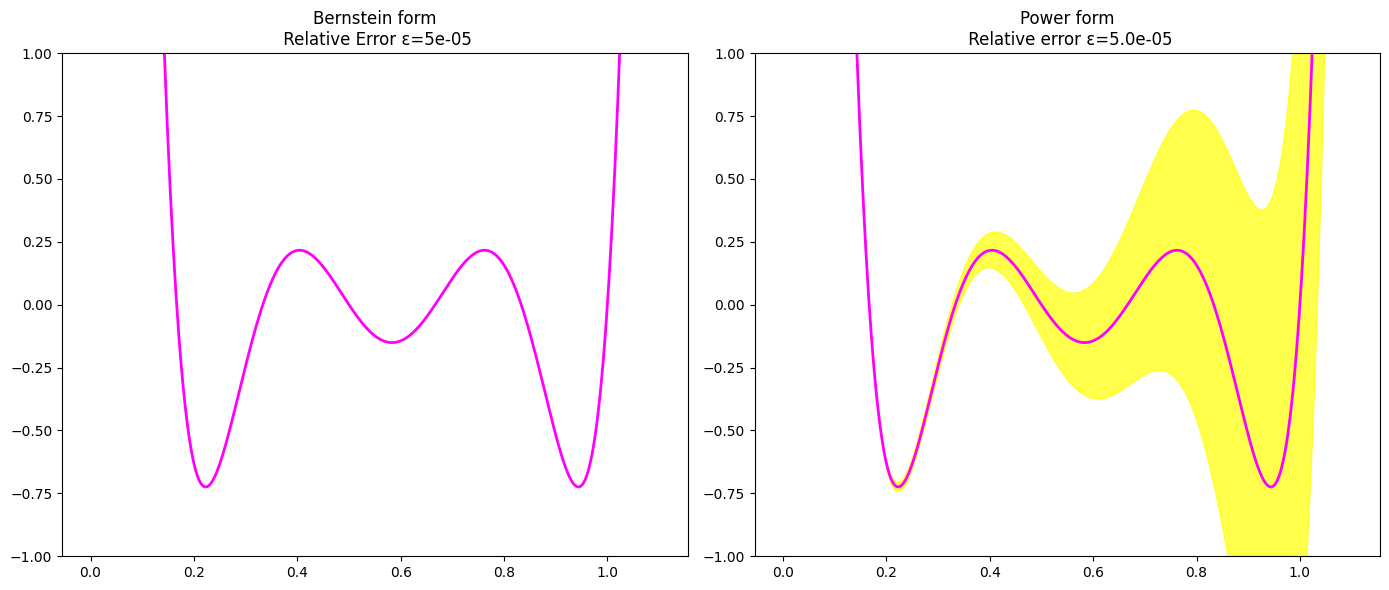

In [159]:
# Perturbed polynomials
roots = [k/6 for k in range(1, 7)]    # 1/6, 2/6, 3/6, 4/6, 5/6, 6/6
coeffs_desc = np.poly(roots)         # np.poly returns descending powers
a = 2000*coeffs_desc[::-1]                # a[0] + a[1]*t + ... + a[6]*t^6

n = len(roots)  #

def poly_power(a, x):
    """
    Evaluate p(t) = sum_{i=0 to n} a[i]*t^i in the power basis.
    'a' is in ascending order: a[0] + a[1]*t + ... + a[n]*t^n.
    """
    x = np.atleast_1d(x)
    y = np.zeros_like(x, dtype=float)
    for i, ai in enumerate(a):
        y += ai * (x**i)
    return y

def bernstein_matrix(n, x):
    """
    Return a 2D array B of shape (len(x), n+1) whose columns are
    the Bernstein basis polynomials B_{i,n}(t).
    """
    x = np.atleast_1d(x)
    B = np.zeros((len(x), n+1))
    for i in range(n+1):
        B[:, i] = comb(n, i)*(x**i)*((1 - x)**(n - i))
    return B

def poly_bernstein(c, n, x):
    """
    Evaluate p(t) = sum_{i=0 to n} c[i]*B_{i,n}(t) in the Bernstein basis.
    """
    B = bernstein_matrix(n, x)
    return B.dot(c)

def power_to_bernstein(a, n):
    """
    Convert ascending-order power coefficients a[i] to Bernstein coefficients c[i].
    We solve T*c = a, where
       T[i,j] = (-1)^(i-j)*comb(n, j)*comb(n-j, i-j), for i >= j,
    and 0 otherwise.
    """
    T = np.zeros((n+1, n+1))
    for i in range(n+1):
        for j in range(i+1):
            T[i, j] = ((-1)**(i-j))*comb(n, j)*comb(n-j, i-j)
    c = np.linalg.solve(T, a)
    return c

c = power_to_bernstein(a, n)

eps = 0.00005
a_minus = a - eps*np.abs(a)
a_plus  = a + eps*np.abs(a)

#c_minus = power_to_bernstein(a_minus, n)
#c_plus  = power_to_bernstein(a_plus,  n)
c_minus = c + eps*np.abs(c)
c_plus = c - eps*np.abs(c)

def poly_power_envelope(a_lo, a_hi, x):
    return poly_power(a_lo, x), poly_power(a_hi, x)

def poly_bernstein_envelope(c_lo, c_hi, n, x):
    return poly_bernstein(c_lo, n, x), poly_bernstein(c_hi, n, x)

t = np.linspace(0, 1.1, 400)

# Original polynomial
p_orig_power = poly_power(a, t)
p_orig_bern  = poly_bernstein(c, n, t)

# Envelopes
p_pow_min, p_pow_max   = poly_power_envelope(a_minus, a_plus, t)
p_bern_min, p_bern_max = poly_bernstein_envelope(c_minus, c_plus, n, t)


fig = plt.figure(figsize=(14, 6))

# Add the first subplot (Bernstein form) to the left
ax1 = fig.add_subplot(1, 2, 1)
ax1.fill_between(t, p_bern_min, p_bern_max, color="yellow", alpha=0.7)
ax1.plot(t, p_orig_bern, color="magenta", lw=2)
ax1.set_title(f"Bernstein form\n Relative Error ε={eps}")
ax1.set_ylim(-1.0, 1.0)

# Add the second subplot (Power form) to the right
ax2 = fig.add_subplot(1, 2, 2)
ax2.fill_between(t, p_pow_min, p_pow_max, color="yellow", alpha=0.7)
ax2.plot(t, p_orig_power, color="magenta", lw=2)
ax2.set_title(f"Power form\n Relative error ε={eps:.1e}")
ax2.set_ylim(-1.0, 1.0)

plt.tight_layout()
plt.show()


## Fourier interpolation

<!-- Fourier Theory -->
Fourier interpolation reconstructs a periodic function from its discrete samples by leveraging its Fourier series representation. This method is especially powerful for smooth periodic functions, as it can achieve spectral (exponential) convergence.

Assume we have a function $f(x)$ defined on the interval $[0,1)$, and we sample it at $N$ equally spaced points:
$$
x_j = \frac{j}{N}, \quad j = 0, 1, 2, \dots, N-1.
$$

Using the discrete Fourier transform (DFT), the Fourier coefficients are computed as:
$$
c_k = \frac{1}{N} \sum_{j=0}^{N-1} f(x_j) \, e^{-2\pi i k x_j}, \quad k = -n, \dots, n,
$$
where typically $n = \lfloor N/2 \rfloor$ (for even $N$, $n = N/2$). These coefficients represent the amplitude and phase of each frequency component in the function.

The Fourier series (or trigonometric polynomial) that interpolates $f(x)$ is given by:
$$
S_N f(x) = \sum_{k=-n}^{n} c_k \, e^{2\pi i k x}.
$$
This reconstruction reproduces the function exactly at the sample points and provides a continuous approximation across $[0,1)$.

An alternative expression for the Fourier interpolation uses the Dirichlet kernel. The Dirichlet kernel is defined as:
$$
D_N(x) = \sum_{k=-n}^{n} e^{2\pi i k x} = \frac{\sin((2n+1)\pi x)}{\sin(\pi x)}.
$$

With this kernel, the interpolation formula can be rewritten as a weighted sum of the function samples:
$$
S_N f(x) = \sum_{j=0}^{N-1} f(x_j) \, D_N(x - x_j).
$$
This formulation highlights that the interpolated value at any $x$ is obtained by averaging the nearby sample values with weights determined by $D_N$.

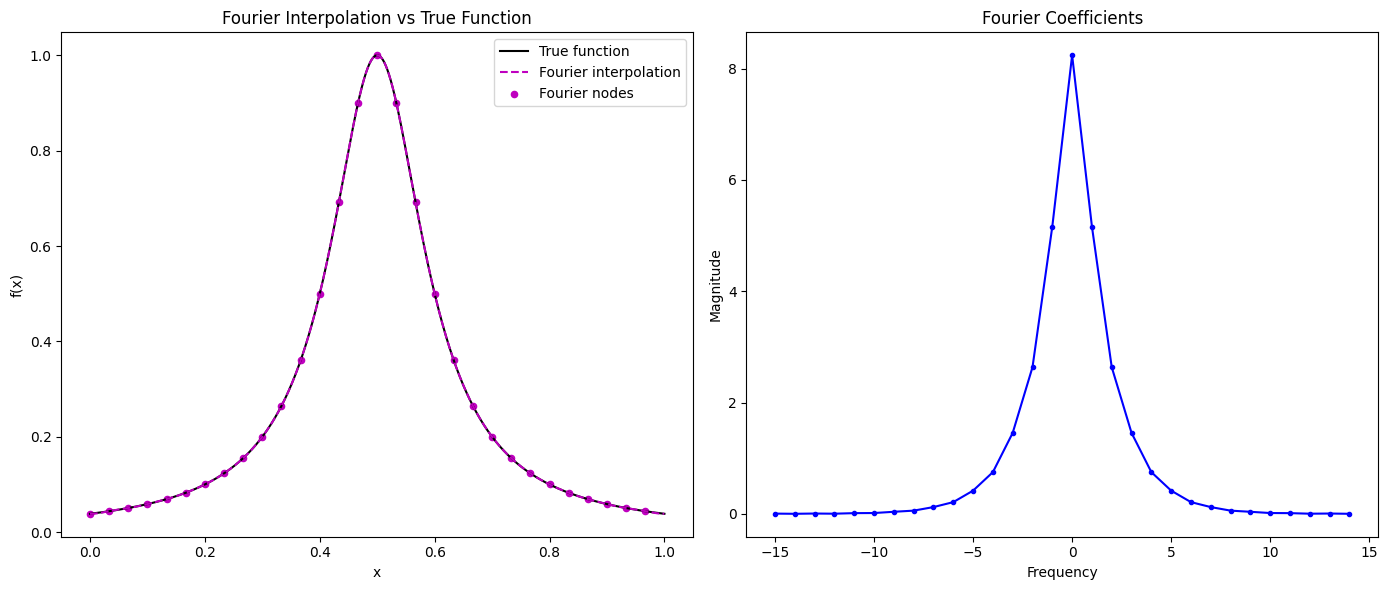

Fourier interpolation L2 error: 5.1e-04


In [192]:
# Fourier Interpolation
M = 5000        # number of points for Fourier interpolation
x_fine = np.linspace(0, 1, M)
y_true = f(x_fine)

# --- Fourier Interpolation ---
# Use a uniform grid without the endpoint to mimic periodicity.
x_fourier = np.linspace(0, 1, N, endpoint=False)
y_fourier = f(x_fourier)

# Compute FFT of the samples
F = np.fft.fft(y_fourier)

# Zero-pad the Fourier coefficients to length M
F_padded = np.zeros(M, dtype=complex)
if N % 2 == 0:
    k = N // 2
    F_padded[:k] = F[:k]
    F_padded[-k:] = F[k:]
else:
    k = (N + 1) // 2
    F_padded[:k] = F[:k]
    F_padded[-(N - k):] = F[k:]

# Inverse FFT to obtain the Fourier interpolated function
f_fourier_interp = np.fft.ifft(F_padded) * (M / N)
f_fourier_interp = np.real(f_fourier_interp)
x_fine_fourier = np.linspace(0, 1, M, endpoint=False)

# --- Compute the Fourier interpolation error ---
# Evaluate the true function at the Fourier interpolation grid points.
y_true_fourier = f(x_fine_fourier)
error_fourier = np.linalg.norm(f_fourier_interp - y_true_fourier) / np.linalg.norm(y_true_fourier)


# --- Fourier Coefficients ---
# Use fftshift to center the zero frequency component.
F_shifted = np.fft.fftshift(F)
freq = np.fft.fftfreq(N, d=1/N)
freq_shifted = np.fft.fftshift(freq)

# --- Create a Figure with Two Subplots (side by side) ---
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Fourier Interpolation vs True Function (with nodes)
axs[0].plot(x_fine, y_true, 'k-', label='True function')
axs[0].plot(x_fine_fourier, f_fourier_interp, 'm--', label='Fourier interpolation')
axs[0].scatter(x_fourier, y_fourier, label='Fourier nodes', color='m', s=20)
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[0].set_title('Fourier Interpolation vs True Function')
axs[0].legend()
axs[0].grid(False)

# Subplot 2: Fourier Coefficients
axs[1].plot(freq_shifted, np.abs(F_shifted), 'b.-')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Magnitude')
axs[1].set_title('Fourier Coefficients')
axs[1].grid(False)

plt.tight_layout()
plt.show()

print(f"{yellow}Fourier interpolation{endc} L2 error: {error_fourier:0.1e}")

## Radial Basis Functions

<!-- RBF Theory -->
A natural cubic spline in one dimension (with nodes $x_i$ and data $f_i$) can be written in the form

$$
s(x)=\beta_0+\beta_1\,x+\sum_{i=1}^{N}\lambda_i\,|x-x_i|^3,
$$

where the linear term \(\beta_0+\beta_1\,x\) accounts for the null space of the cubic kernel and the coefficients \(\{\lambda_i\}\) are determined by the interpolation conditions along with the side conditions

$$
\sum_{i=1}^{N}\lambda_i=0,\quad \sum_{i=1}^{N}\lambda_i\,x_i=0.
$$

In the language of radial basis functions (RBFs), one chooses the kernel

$$
\phi(r)=r^3,
$$

so that the RBF interpolant is expressed as

$$
s(x)=\sum_{i=1}^{N}\lambda_i\,\phi\bigl(|x-x_i|\bigr)+p(x)
=\sum_{i=1}^{N}\lambda_i\,|x-x_i|^3+p(x),
$$

This formulation is equivalent to the natural cubic spline: the cubic power part \( |x-x_i|^3 \) reproduces the “bending” energy characteristic of cubic splines, while the linear term ensures uniqueness by accounting for the kernel’s null space.

Some examples of radial functions and error bound for the interpolation are:


$$
\begin{array}{|l|l|l|}
\hline
\textbf{RBF Type} & \textbf{Kernel Equation (for }x\in\mathbb{R}^n\text{)} & \textbf{Error Bound} \\[1mm]
\hline
\text{Gaussian} & \phi(\|x\|)=\exp\Bigl(-\Bigl(\frac{\|x\|}{\sigma}\Bigr)^2\Bigr) & |f(x)-s(x)|\le C\,\exp\Bigl(-\frac{\gamma}{h}\Bigr) \\[2mm]
\hline
\text{Multiquadric} & \phi(\|x\|)=\sqrt{\|x\|^2+c^2} & |f(x)-s(x)|\le C\,h^{\mu} \\[2mm]
\hline
\text{Inverse Multiquadric} & \phi(\|x\|)=\dfrac{1}{\sqrt{\|x\|^2+c^2}} & |f(x)-s(x)|\le C\,h^{\mu} \\[2mm]
\hline
\text{Thin Plate Spline (for }d=2\text{)} & \phi(\|x\|)=\|x\|^2\ln(\|x\|) & |f(x)-s(x)|\le C\,h^{2}|\ln h| \\[2mm]
\hline
\text{Linear or Cubic} & \phi(\|x\|)=\|x\| \quad \text{or} \quad \phi(\|x\|)=\|x\|^3 & |f(x)-s(x)|\le C\,h^{\mu} \\[2mm]
\hline
\end{array}
$$


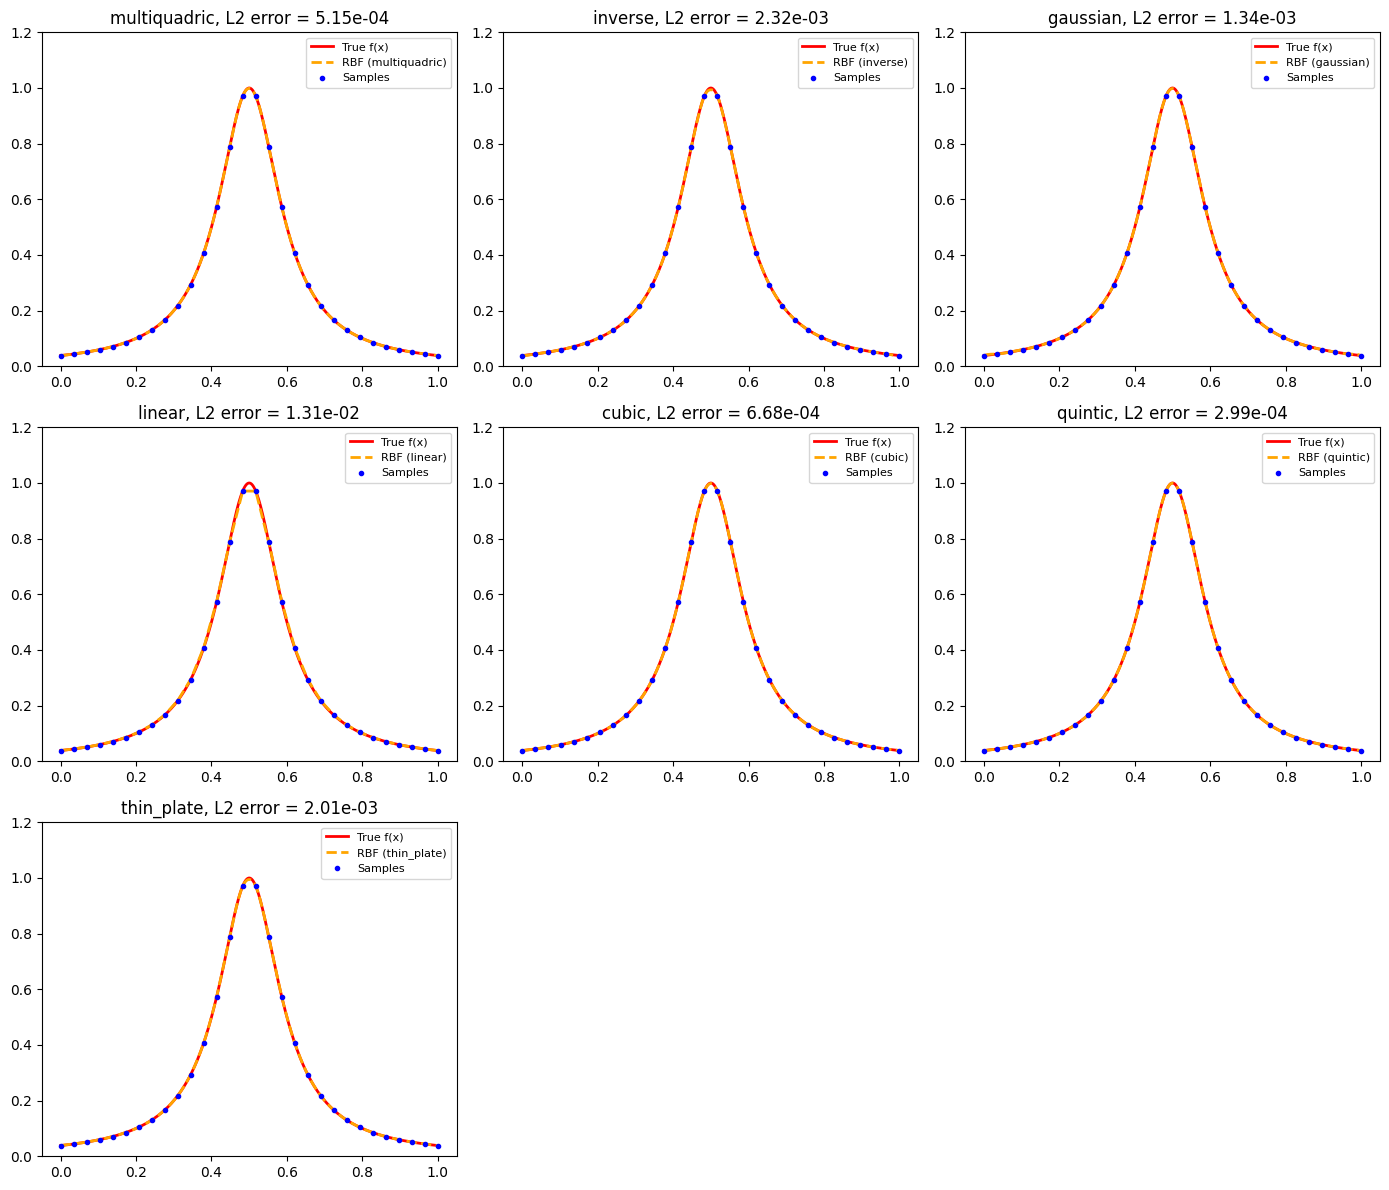


Method                  L2 normalized error
---------------------------------------------
multiquadric              5.1e-04
inverse                   2.3e-03
gaussian                  1.3e-03
linear                    1.3e-02
cubic                     6.7e-04
quintic                   3.0e-04
thin_plate                2.0e-03


In [193]:
# RBF interpolation
x_sample = np.linspace(0, 1, N)
y_sample = f(x_sample)

# Dense grid for evaluation
x_dense = np.linspace(0, 1, M)
f_dense = f(x_dense)

# List of RBF methods to compare
rbf_methods = ['multiquadric', 'inverse', 'gaussian', 'linear', 'cubic', 'quintic', 'thin_plate']

# Prepare to store L2 normalized error for each method
errors = {}

# Arrange subplots in a grid (3 columns per row)
n_methods = len(rbf_methods)
n_rows = int(np.ceil(n_methods / 3))
fig, axes = plt.subplots(n_rows, 3, figsize=(14, 4*n_rows))
axes = axes.flatten()

for i, method in enumerate(rbf_methods):
    # Create the RBF interpolator using the current method
    rbf_interpolator = Rbf(x_sample, y_sample, function=method)
    y_rbf = rbf_interpolator(x_dense)
    
    # Compute the normalized L2 error
    error = np.linalg.norm(f_dense - y_rbf) / np.linalg.norm(f_dense)
    errors[method] = error
    
    # Plot the true function, the RBF interpolant, and the sample points
    axes[i].plot(x_dense, f_dense, 'r-', lw=2, label="True f(x)")
    axes[i].plot(x_dense, y_rbf, color='orange',linestyle='--', lw=2, label=f"RBF ({method})")
    axes[i].plot(x_sample, y_sample, 'bo', ms=3, label="Samples")
    axes[i].set_title(f"{method}, L2 error = {error:.2e}")
    axes[i].set_ylim(0, 1.2)
    axes[i].legend(fontsize=8)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
# Print the L2 normalized error for each method in a table format
print("\nMethod                  L2 normalized error")
print("-" * 45)
for method, err in errors.items():
    print(f"{yellow}{method:<20}{endc} {err:>12.1e}")


# Exact TN Function Encoding

<!--QTT tensorization-->
When discretizing a function for QTT (Quantized Tensor Train) decomposition, we start by sampling the function on a uniform grid whose size is a power of two. For a function $f(x)$ defined on an interval (say, $[0,1]$), we choose 
$$
n=2^d \quad \text{grid points},
$$
and represent each point $x$ in its binary expansion. Specifically, every grid point can be written as
$$
x = \sum_{k=1}^{d} \frac{i_k}{2^k},
$$
where each $i_k \in \{0,1\}$. In other words, $x$ is expressed as a binary fraction. 

This binary representation naturally tensorizes the discretized vector $v$, whose entries are 
$$
v(i)=f(x_i),
$$
into a $d$-dimensional tensor $V$ of size $2\times 2\times\cdots\times 2$ by setting
$$
V(i_1,i_2,\dots,i_d)=v\Bigl(i_1+2\,i_2+\cdots+2^{d-1}i_d\Bigr).
$$
Once the vector is reshaped into this high-dimensional tensor, a TT-decomposition is applied to obtain the QTT-format, which often results in dramatically lower storage costs if the function admits a low-rank representation.




## Exponential function 


<!-- Explicit construction-->
Consider the exponential function
$$
f(x)=\exp(\lambda x).
$$
When discretized on the grid with $n=2^d$ points, each grid point is represented as 
$$
x = \sum_{k=1}^{d} \frac{i_k}{2^k},
$$
and the function values become
$$
v(i)=\exp\Bigl(\lambda \sum_{k=1}^{d} \frac{i_k}{2^k}\Bigr).
$$

The remarkable property of the exponential function is that its QTT representation has TT-rank 1. That is, the tensorized vector $V(i_1,i_2,\dots,i_d)$ can be exactly written as a product of one-dimensional cores:
$$
V(i_1,i_2,\dots,i_d) = G_1(i_1) \, G_2(i_2) \, \cdots \, G_d(i_d),
$$
where each core is simply given by
$$
G_k(i_k) = \exp\Bigl(\lambda \frac{i_k}{2^k}\Bigr),\quad i_k\in\{0,1\}.
$$

Thus, the full QTT representation is
$$
V(i_1,i_2,\dots,i_d) = \prod_{k=1}^d \exp\Bigl(\lambda \frac{i_k}{2^k}\Bigr) = \exp\Bigl(\lambda \sum_{k=1}^d \frac{i_k}{2^k}\Bigr) = \exp(\lambda x).
$$

## Trigonometric Series

## Polynomials in QTT format

<!-- Explicit construction in 1d -->
Let 
$$
M(x) = \sum_{k=0}^{p} a_k x^k
$$
be a polynomial of degree $p$. On a uniform grid over $[a,b]$ with
$$
x_i = a + i h,\quad i=0,1,\dots,n-1,\quad n=2^d,\quad h=\frac{b-a}{n-1},
$$
we form the vector
$$
v(i)=M(x_i).
$$
The QTT-format is obtained by reshaping $v$ into a $2 \times 2 \times \cdots \times 2$ tensor
$$
V(i_1,i_2,\dots,i_d)=v(i),\quad \text{with } i=i_1+2\,i_2+\cdots+2^{d-1}i_d,
$$
and by introducing the auxiliary variables
$$
t_k = a\,\delta_{k1} + 2^{k-1} i_k\, h,\quad k=1,\dots,d,
$$
so that the spatial variable is represented as
$$
x = t_1+t_2+\cdots+t_d.
$$

An explicit QTT-decomposition for the tensor $V$ corresponding to the polynomial $M(x)$ is given by
$$
V(i_1,i_2,\dots,i_d) = G_1(t_1)\,G(t_2)\cdots G(t_{d-1})\,G_d(t_d).
$$

Here the cores are defined as follows:

1. The first core is a row vector of length $p+1$:
$$
G_1(t_1)= \Bigl( \phi_0(t_1) \quad \phi_1(t_1) \quad \cdots \quad \phi_p(t_1) \Bigr),
$$
with
$$
\phi_s(x)= \sum_{k=s}^{p} a_k \binom{k}{s} x^{\,k-s},\quad s=0,1,\dots,p.
$$

2. For the intermediate cores (which are all of the same form), the matrix core $G(x)$ is given by
$$
G(x)_{ij} = 
\begin{cases}
\displaystyle \binom{i}{j}\, x^{\,i-j}, & \text{if } i\ge j,\\[1mm]
0, & \text{if } i < j,
\end{cases}\quad i,j=0,1,\dots,p.
$$

3. The last core is a column vector of length $p+1$:
$$
G_d(t_d)= 
\begin{pmatrix}
1\\[1mm]
t_d\\[1mm]
t_d^2\\[1mm]
\vdots\\[1mm]
t_d^p
\end{pmatrix}.
$$

In summary, the QTT-decomposition (with base 2) for the polynomial $M(x)$ is given explicitly by
$$
V(i_1,i_2,\dots,i_d) = G_1(t_1)\,G(t_2)\cdots G(t_{d-1})\,G_d(t_d),
$$
where the cores $G_1$, $G(x)$, and $G_d$ are defined by the formulas above. This representation provides a low-parametric (and hence efficient) encoding of the polynomial over a grid of size $2^d$.


In [98]:
from numpy.polynomial import Polynomial

def create_random_polynomial(n, low=-10, high=10):
    """
    Creates a random polynomial of degree n.
    
    Parameters:
        n (int): Degree of the polynomial.
        low (float): Lower bound for random coefficients.
        high (float): Upper bound for random coefficients.
        
    Returns:
        poly (Polynomial): A Polynomial object representing the random polynomial.
        coeffs (ndarray): 1D array of coefficients in the order [a_0, a_1, ..., a_n],
                          representing the polynomial a_0 + a_1*x + ... + a_n*x^n.
    """
    coeffs = np.random.uniform(low, high, size=n+1)
    poly = Polynomial(coeffs)  # Coefficients ordered as [a_0, a_1, ..., a_n]
    return poly, coeffs

def derivative_coeffs(coeffs, m):
    """
    Computes the coefficients of the m-th derivative of a polynomial.
    
    The input polynomial is represented by its coefficients ordered as 
    [a_0, a_1, ..., a_n] corresponding to a_0 + a_1*x + ... + a_n*x^n.
    This function returns an array of coefficients of the m-th derivative, 
    padded with zeros at the end to have the same length as the original coefficient array.
    
    Parameters:
        coeffs (ndarray): 1D array of polynomial coefficients [a_0, a_1, ..., a_n].
        m (int): Order of the derivative.
    
    Returns:
        padded_deriv (ndarray): Coefficient array of the m-th derivative, padded with zeros
                                to have the same length as `coeffs`.
    """
    # Create the polynomial from the coefficients
    poly = Polynomial(coeffs)
    # Compute the m-th derivative using np.polynomial.Polynomial.deriv
    poly_deriv = poly.deriv(m)
    deriv_coefs = poly_deriv.coef
    # Pad the result with zeros to have the same length as the original coefficients
    pad_length = len(coeffs) - len(deriv_coefs)
    padded_deriv = np.concatenate([deriv_coefs, np.zeros(pad_length)])
    return padded_deriv


def qtt_polynomial_cores_T(coeffs, K ,D,d,dtype=tn.float64):

    p = len(coeffs)-1
    Q = tn.tensor([derivative_coeffs(coeffs,k)/math.factorial(k) for k in range(K+1)]).t()
    R = tn.diag( tn.tensor([1/2**(D*i) for i in range(K+1)]))
    cores = []
    #first X cores
    for l in range(1, D - 1):
        G = tn.zeros((p + 1, 2, p + 1),dtype=dtype)  # Shape (n+1, 2, n+1)
        G[:, 0, :] = tn.eye(p+1,p+1) 
        for i in range(p + 1):
            for j in range(p + 1):
                G[i, 1, j] = comb(i, i-j) * ( (2**(-D+l)) ** (i - j)) if i >= j else 0
        cores.append(G)

    # Last core Gd
    Gd = tn.zeros((p + 1, 2, 1),dtype=dtype)  # Shape (n+1, 2, 1)
    v1 = tn.zeros(p+1)
    v1[0] = 1
    v2 = tn.tensor([1]+[(2**(-1))**i for i in range(1,p+1)])
    Gd[:, 0, 0] = v1
    Gd[:, 1, 0] = v2
    cores.append(Gd)
    coresx = [c.permute(2,1,0) for c in cores[::-1]]

    #lastXcore 
    coreX = tn.zeros((p + 1, 2, K+1),dtype=dtype)
    for r in range(K+1):
        for s in range(p + 1):
            coreX[s, 0, r] = Q[s,r]
            coreX[s, 1, r] = sum(Q[k,r] * comb(k, s) * ((2**(-D)) ** (k - s)) for k in range(s, p + 1))


    #first Y core
    coreY = tn.zeros((K + 1, 2, K+1),dtype=dtype)
    for r in range(K+1):
        for s in range(K + 1):
            coreY[r, 0, s] = R[r,s]
            coreY[r, 1, s] = sum(R[r,k] * comb(k, s) * ((2**(-1)) ** (k - s)) for k in range(s, K + 1))

    #last y cores 
    cores = []
    # Intermediate cores G(x)
    for l in range(1, d - 1):
        G = tn.zeros((K + 1, 2, K + 1),dtype=dtype)  # Shape (n+1, 2, n+1)
        G[:, 0, :] = tn.eye(K+1,K+1) 
        for i in range(K + 1):
            for j in range(K + 1):
                G[i, 1, j] = comb(i, i-j) * ( (2**(-l-1)) ** (i - j)) if i >= j else 0
        cores.append(G)

    # Last core Gd
    Gd = tn.zeros((K + 1, 2, 1),dtype=dtype)  # Shape (n+1, 2, 1)
    v1 = tn.zeros(K+1)
    v1[0] = 1
    v2 = tn.tensor([1]+[(2**(-d))**i for i in range(1,K+1)])
    Gd[:, 0, 0] = v1
    Gd[:, 1, 0] = v2
    cores.append(Gd)

    return coresx + [coreX] + [coreY] + cores

def chebyshev_poly_coeffs_rescaled(n: int):
    if n == 0:
        coeffs = np.array([1.0])
    elif n == 1:
        coeffs = np.array([-1.0, 2.0])
    else:
        c_prev = np.array([1.0])
        c_curr = np.array([-1.0, 2.0])
        multiplier = np.array([-1.0, 2.0])
        for _ in range(1, n):
            prod = np.convolve(c_curr, multiplier)
            c_next = 2 * prod - np.pad(c_prev, (0, len(prod) - len(c_prev)), mode='constant')
            c_prev, c_curr = c_curr, c_next
        coeffs = c_curr
    return coeffs


In [99]:
base = 2
po = 13
deg = 10
ncores = 20
l = tntt.TT(qtt_polynomial_cores([0,1],ncores))

#pol,c = create_random_polynomial(deg)
c = chebyshev_poly_coeffs_rescaled(deg)
pol = np.polynomial.Polynomial(c)
#ff = lambda x : tn.tensor(pol(x.numpy()))
coeffs = np.zeros(deg+1)
coeffs[deg] = 1 
ff = lambda x : tn.tensor(np.polynomial.chebyshev.chebval(2*x.numpy() - 1, coeffs))

r = tntt.interpolate.function_interpolate(ff,l,kick=5,eps=1e-15,nswp=22).round(1e-15)
print(r)
error = (r.full() - ff(l.full())).norm() / ff(l.full()).norm()
print('error', error)

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, 16, 31, 60, 119, 238, 473, 927, 476, 249, 126, 64, 32, 16, 8, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 2381954 compression 2.271608352661133

error tensor(4.8104e-13, dtype=torch.float64)


### Supercompresibility of polynomials

Although the exact QTT rank of a degree $n$ polynomial is $n+1$, we observe that after compressing the real QTT rank is in fact much lower

In [42]:
import pandas as pd
def plot_erank_vs_degrees(degrees, data, errors):
    """
    Plot erank versus degrees for multiple error thresholds.
    
    Parameters:
    - degrees (list): List of degrees (x-axis).
    - data (list of lists): Nested list where each sublist contains erank values for a specific degree.
    - errors (list): List of error thresholds corresponding to different lines.
    """
    # Transpose data to group by error threshold
    data_by_error = list(zip(*data))
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    for eranks, e in zip(data_by_error, errors):
        plt.plot(degrees, eranks, label=f'Error Threshold: {e:.0e}')
    
    # Add labels, legend, and title
    plt.xlabel("Degrees", fontsize=12)
    plt.ylabel("Effective Rank (erank)", fontsize=12)
    plt.title("Effective Rank vs Degrees for Different Error Thresholds", fontsize=14)
    plt.legend()
    plt.grid(False)
    plt.show()


def plot_erank_vs_degrees_pandas(degrees, data, errors):
    """
    Plot erank versus degrees for multiple error thresholds using Pandas.
    
    Parameters:
    - degrees (list): List of degrees (x-axis).
    - data (list of lists): Nested list where each sublist contains erank values for a specific degree.
    - errors (list): List of error thresholds corresponding to different lines.
    """
    # Convert data into a Pandas DataFrame
    df = pd.DataFrame(data, columns=[f"e={e:.0e}" for e in errors], index=degrees)
    df.index.name = "Degrees"
    
    # Plot the DataFrame
    df.plot(figsize=(10, 6), marker='o')
    
    # Add labels, legend, and title
    plt.xlabel("Degrees", fontsize=12)
    plt.ylabel("Effective Rank (erank)", fontsize=12)
    plt.title("Effective Rank vs Degrees for Different Error Thresholds", fontsize=14)
    plt.grid(False)
    plt.legend(title="Error Thresholds")
    plt.show()

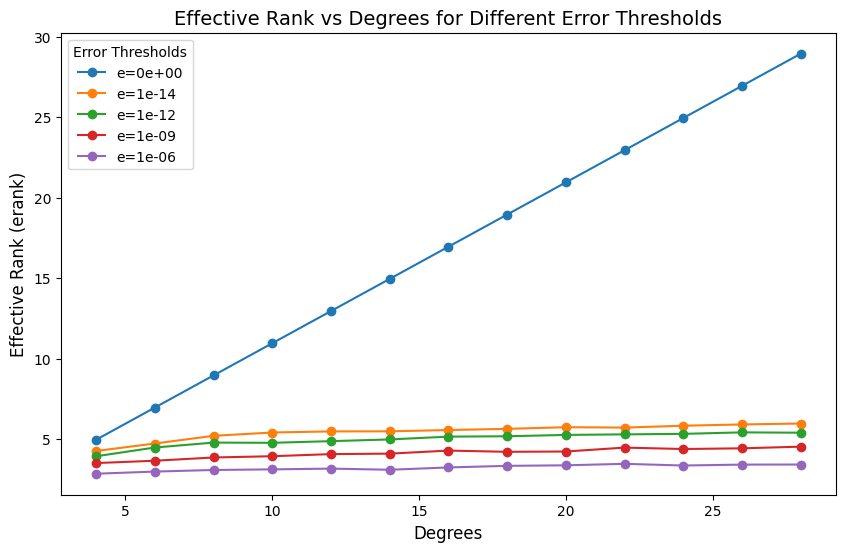

In [122]:
#super compresibility
data = []
degrees = list(range(4,30,2))
roundings = [0, 1e-14,1e-12,1e-9,1e-6]
nexp = 5
for deg in degrees:
    eranks = []
    for e in roundings:
        r = 0
        for i in range(nexp):
            pol,coef = create_random_polynomial(deg)
            extt = tntt.TT(qtt_polynomial_cores(coef,po))
            if e != 0:
                ctt=extt.round(e)
            else:
                ctt = extt
            er = erank(ctt.R,ctt.N)
            r += er
        eranks.append(r/nexp)
        
    data.append(eranks)

plot_erank_vs_degrees_pandas(degrees,data,roundings)

This can be unserstood as a taylor series approximation over a coarse grid (e.g. 10 cores ~ H = 1e-3), and a 5 degree taylor series will give us an error of ~ 1e-18

In [734]:
def QR(mat):
    """
    Compute the QR decomposition. Backend can be changed.

    Parameters
    ----------
    mat : tn array
        DESCRIPTION.

    Returns
    -------
    Q : the Q matrix
    R : the R matrix

    """
    Q,R = tn.linalg.qr(mat)
    return Q, R

def lr_un(tt_cores, R):
    """
    Orthogonalize the TT-cores left to right.

    Parameters
    ----------
    tt_cores : list of torch tensors.
        The TT-cores as a list.

    Returns
    -------
    tt_cores : list of torch tensors.
        The orthogonal TT-cores as a list.

    """  
    
    d = len(tt_cores)
    
    core_now = tt_cores[0]
    cores_new = d*[None]
    lognorm = 0
    for i in range(d-1):
        
        mode_shape = [core_now.shape[1]]
        core_now = tn.reshape(core_now,[core_now.shape[0]*core_now.shape[1],-1])
        
        # perform QR
        Qmat, Rmat = QR(core_now)
        norm = Qmat.norm()
        core_now= Qmat/norm
        lognorm += tn.log(norm)
        # take next core
        core_next = tt_cores[i+1]
        shape_next = list(core_next.shape[1:])
        core_next = tn.reshape(core_next,[core_next.shape[0],-1])
        core_next = Rmat @ core_next
        core_next = tn.reshape(core_next,[core_now.shape[1]]+shape_next)
        
        # update the cores
        cores_new[i] = tn.reshape(core_now,[R[i]]+mode_shape+[-1])
        R[i+1] = core_now.shape[1]
        cores_new[i+1] = core_next
        
        core_now = core_next
    norm = core_now.norm()
    cores_new[-1] = core_now/norm
    lognorm += tn.log(norm)
    
    return cores_new, lognorm


def rl_un(tt_cores, R):
    """
    Orthogonalize the TT-cores right to left.

    Parameters
    ----------
    tt_cores : list of torch tensors.
        The TT-cores as a list.

    Returns
    -------
    tt_cores : list of torch tensors.
        The orthogonal TT-cores as a list.

    """  
    
    d = len(tt_cores)
    cores_new = d*[None]
    cores_new[-1] = tt_cores[-1]+0
    lognorm = 0
    for i in range(d-1,0,-1):

        mode_shape = [cores_new[i].shape[1]]
        core_now = tn.reshape(cores_new[i],[cores_new[i].shape[0],cores_new[i].shape[1]*cores_new[i].shape[2]]).t()
    
        # perform QR
        
        Qmat, Rmat = QR(core_now)
        rnew = min([core_now.shape[0],core_now.shape[1]])
        rnew = Rmat.shape[0]
        # update current core
        nc =tn.reshape(Qmat.T,[rnew]+mode_shape+[-1])
        ncn = nc.norm()
        cores_new[i] =nc/ncn
        lognorm += tn.log(ncn)
        R[i] = cores_new[i].shape[0]
        # and the k-1 one
        mode_shape = [tt_cores[i-1].shape[1]]
        core_next = tn.reshape(tt_cores[i-1],[tt_cores[i-1].shape[0]*tt_cores[i-1].shape[1],tt_cores[i-1].shape[2]]) @ Rmat.T
        cores_new[i-1] = tn.reshape(core_next,[tt_cores[i-1].shape[0]]+mode_shape+[-1])
    
    ic = cores_new[0]
    icn = ic.norm()
    cores_new[0] = ic/icn
    lognorm += tn.log(icn)
    return cores_new, lognorm

def norm_cores(cores):
    d = len(cores)
    lognorm = 0
    newcores = d*[None]
    for i in range(d):
        c = cores[i]
        cn = c.norm()
        newcores[i] = c/cn
        lognorm += tn.log(cn)
    return newcores,lognorm

In [ ]:
def cheb_deriv_coeffs(c):
    """
    Given a 1D torch tensor of Chebyshev coefficients c = [c0, c1, ..., cN]
    representing a function
        f(x) = c0/2 + sum_{n=1}^N c_n T_n(x),
    compute the Chebyshev coefficients d = [d0, d1, ..., d_{N-1}]
    for the derivative f'(x) expressed as
        f'(x) = sum_{n=0}^{N-1} d_n T_n(x).
    
    The recurrence used is:
      d[N-1] = 2*N * c[N]
      For k = N-2, ..., 0:
          d[k] = d[k+2] + 2*(k+1)*c[k+1]
      Then adjust d0:
          d[0] = d[0] / 2
    We allocate a working vector d of length N+2 to safely use d[k+2].
    
    Parameters:
        c (tn.Tensor): 1D tensor of Chebyshev coefficients (length N+1)
    
    Returns:
        tn.Tensor: 1D tensor of derivative coefficients (length N)
    """
    N = c.numel() - 1  # Maximum polynomial degree.
    if N == 0:
        # f is constant; derivative is zero.
        return tn.zeros(1, dtype=c.dtype, device=c.device)
    
    # Allocate d with extra two elements.
    d = tn.zeros(N + 2, dtype=c.dtype, device=c.device)
    
    # Set the highest derivative coefficient.
    d[N-1] = 2 * N * c[N]
    
    # Backward recurrence: k = N-2 down to 0.
    for k in range(N - 2, -1, -1):
        d[k] = d[k+2] + 2 * (k + 1) * c[k+1]
    
    # Adjust the first coefficient.
    #d[0] = d[0] * 0.5
    
    # Return only the first N coefficients.
    return d[:N]

def cheb_deriv_coeffs_k(c, k):
    """
    Compute the k-th derivative Chebyshev coefficients by applying the
    first-derivative algorithm repeatedly.
    
    Parameters:
        c (tn.Tensor): 1D tensor of Chebyshev coefficients for f(x).
        k (int): Order of derivative to compute.
    
    Returns:
        tn.Tensor: Chebyshev coefficients for the k-th derivative.
    """
    c_current = c.clone()
    for _ in range(k):
        c_current = cheb_deriv_coeffs(c_current)
        # If the series reduces to a constant, break out.
        if c_current.numel() <= 1:
            break
    return c_current


def cheb_deriv_coeffs_shifted(c):
    N = c.numel() - 1
    if N == 0:
        return tn.zeros(1, dtype=c.dtype, device=c.device)
    d_prime = torch.zeros(N + 2, dtype=c.dtype, device=c.device)
    d_prime[N-1] = 2 * N * c[N]
    for k in range(N - 2, -1, -1):
        d_prime[k] = d_prime[k+2] + 2 * (k + 1) * c[k+1]
    d_prime[0] = d_prime[0] * 0.5
    d = 2 * d_prime[:N]
    return d

def cheb_deriv_coeffs_shifted_k(c, k):
    c_current = c.clone()
    for _ in range(k):
        c_current = cheb_deriv_coeffs_shifted(c_current)
        if c_current.numel() <= 1:
            break
    return c_current

In [871]:
def tt_clenshaw(cs,d):
    b2 = 0
    b1 = 0
    N = len(cs)
    x = tntt.TT(qtt_polynomial_cores([-1,2],d,basis='m'))
    for i in range(N-1,-1,-1):
        b0 = cs[i] + 2*x*b1 - b2
        b0 = b0.round(1e-15)
        b2 = b1
        b1 = b0

    return (b0 - x*b2).round(1e-15)

tt_clenshaw(coeffs,6)

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 168 compression 2.625

In [927]:
degree = 40
#pol,c = create_random_polynomial(degree)

c = chebyshev_poly_coeffs_rescaled(degree)

pol = np.polynomial.Polynomial(c)
D = 16
d = 5
torder = 4
coeffs = tn.zeros(degree+1)
coeffs[degree] = 1 

ff = lambda x : tn.tensor(np.polynomial.chebyshev.chebval(2*x.numpy() - 1, coeffs))

compol0a = tt_clenshaw(coeffs,D)
e  = tn.eye(torder+1,dtype=tn.float64)
R = tn.diag( tn.tensor([1/2**(D*i) for i in range(torder+1)]))
coarsepols = [ tntt.kron( tt_clenshaw(cheb_deriv_coeffs_shifted_k(coeffs, k) ,D)/math.factorial(k) , tntt.TT(e[k],[torder+1]) ) for k in range(torder +1)]
pows = [ tntt.kron( tntt.TT(e[k],[torder+1]), tntt.TT(qtt_polynomial_cores(R[k],d,dir='f',basis='a'))) for k in range(torder +1)]
cp = sum(coarsepols).round(1e-15)
pf = sum(pows).round(1e-18)
compol = connect(cp,pf,pd=torder+1)
l = tn.linspace(0,1-1/2**(D+d),2**(D+d), dtype=tn.float64)
y = compol.full().reshape(-1)
#error0 = (y - ff(l)).norm() / ff(l).norm()
#error = (compol.full().reshape(-1) - ff(l.full().reshape(-1))).norm() / ff(l.full().reshape(-1)).norm()
print(compol)
print('erank',erank(compol.R,compol.N))
compol0r = compol.round(1e-11)
print(compol0r)
print('erank',erank(compol0r.R,compol0r.N))
error0 = (y - ff(l)).norm() / ff(l).norm()
print('errors', f'{error0.item():.4e}' )

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, 16, 26, 51, 57, 36, 25, 19, 16, 14, 13, 10, 7, 5, 4, 4, 3, 2, 1]

Device: cpu, dtype: torch.float64
#entries 18494 compression 0.008818626403808594

erank 22.005965780166843
TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, 16, 14, 13, 11, 10, 9, 8, 7, 6, 6, 5, 5, 4, 4, 4, 3, 2, 1]

Device: cpu, dtype: torch.float64
#entries 2504 compression 0.001194000244140625

erank 8.058610235183993
errors 4.3137e-11


In [922]:
mpsc = tt_clenshaw(coeffs ,D+d).round(1e-11)
y = mpsc.full().reshape(-1)
error0 = (y - ff(l)).norm() / ff(l).norm()
error0, erank(mpsc.R, mpsc.N)

(tensor(2.1566e-12, dtype=torch.float64), np.float64(8.058610235183993))

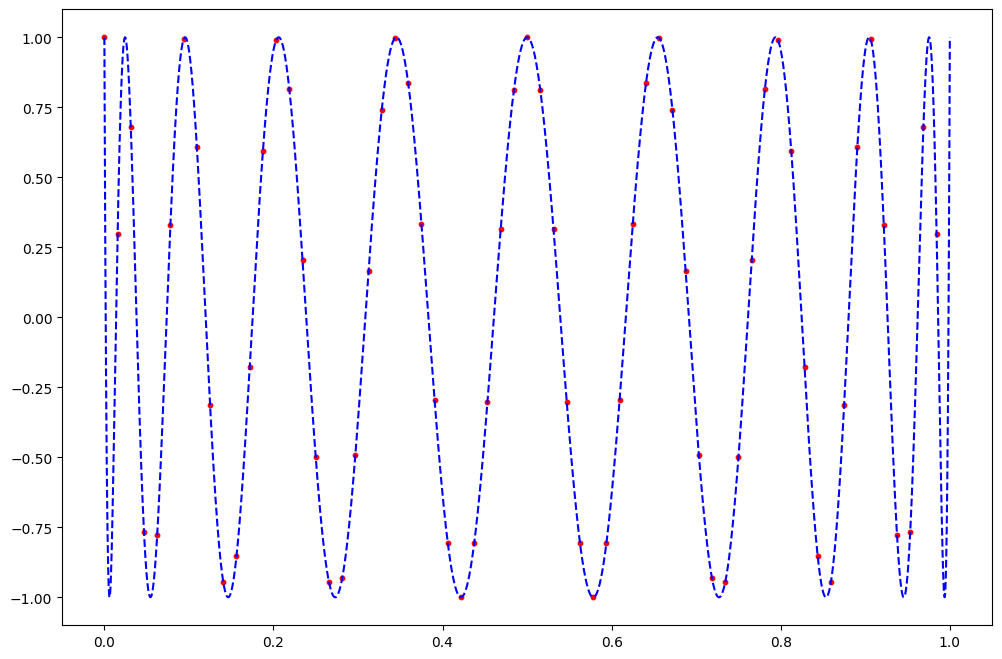

In [890]:
ml0 = tntt.TT(qtt_polynomial_cores([0,1],D)).full().reshape(-1)
y0 = compol.full().reshape(-1)
x = l
#y = compol.full().reshape(-1)
plt.figure(figsize=(12,8))
#plt.plot(x,y,c='r')
plt.plot(x,y0, c='b',linestyle='--')
#plt.plot(x,ff(x),color='k')
l0 = tntt.TT(qtt_polynomial_cores([0,1],6)).full().reshape(-1)
plt.scatter(l0,ff(l0),s=10,c='r')
plt.show()

In [606]:
c = [2**i for i in range(20)]
compol0a= tntt.TT( qtt_polynomial_cores(c, 6,dir='f', basis='a') )
compol0m = tntt.TT( qtt_polynomial_cores(c, 6,dir='f', basis='m') )

print((compol0m-compol0a).norm()/compol0m.norm())
#print([ compol0a.cores[i].reshape(2,5,-1).norm() for i in range(5)])

tensor(3.3027e-08, dtype=torch.float64)


## Multidimensional Polynomial encoding

### Encodings

In two dimensions there are 3 main ways of encoding low scales 

* Sequential encoding

* Interleaved encoding

* Comb-like in 2d:  a comb structure is the same as an MPS in two dimensions, we just need to swap the order of the length scales of of of the variables

<span style="color: yellow;"> Loading...</span>

# Black Box Constructor: **TT-Cross** 

In [78]:
import random
def generate_random_polynomial_function(max_degree=3, coeff_range=(-10.0, 10.0)):
    """
    Generate a callable random polynomial function in two variables x and y.
    Also returns the coefficient matrix.

    Parameters:
    - max_degree (int): Maximum degree of the polynomial.
    - coeff_range (tuple): Range of the coefficients (inclusive).

    Returns:
    - function: A callable function f(x, y) representing the polynomial.
    - np.ndarray: A 2D array where the element at (i, j) is the coefficient for x^i * y^j.
    """
    # Create the coefficient matrix with dimensions (max_degree+1, max_degree+1)
    coeff_matrix = np.zeros((max_degree + 1, max_degree + 1))

    # Populate the coefficient matrix with random values
    for i in range(max_degree + 1):
        for j in range(max_degree + 1 - i):  # Ensure i + j <= max_degree
            coeff_matrix[i, j] = random.uniform(*coeff_range)

    # Define the callable polynomial function
    def polynomial_function(x, y):
        result = 0.0
        for i in range(max_degree + 1):
            for j in range(max_degree + 1):
                if i + j <= max_degree:  # Ensure terms stay within max_degree
                    result += coeff_matrix[i, j] * (x ** i) * (y ** j)
        return result

    return polynomial_function, coeff_matrix

def generate_polynomial_with_growth(max_degree=3, coeff_range=(1.0, 2.0)):

    # Create the coefficient matrix with dimensions (max_degree+1, max_degree+1)
    coeff_matrix = np.zeros((max_degree + 1, max_degree + 1))

    # Populate the coefficient matrix with exponentially growing coefficients
    for i in range(max_degree + 1):
        for j in range(max_degree + 1 - i):  # Ensure i + j <= max_degree
            total_degree = i + j
            coeff_matrix[i, j] = random.uniform(*coeff_range) * (3 ** total_degree)

    # Define the callable polynomial function
    def polynomial_function(x, y):
        result = 0.0
        for i in range(max_degree + 1):
            for j in range(max_degree + 1):
                if i + j <= max_degree:  # Ensure terms stay within max_degree
                    result += coeff_matrix[i, j] * (x ** i) * (y ** j)
        return result

    return polynomial_function, coeff_matrix

In [79]:
base = 2
po = 10
N = [base]*po
n=2**po
#l = tntt.interpolate.dmrg_cross(linear, N, eps = 1e-15,kick=1)
#l = l.round(1e-15)

l = tntt.TT(qtt_polynomial_cores([0,1],po))
ones = tntt.ones(N)
Y = tntt.kron(ones,l)
X = tntt.kron(l,ones)
p,cp = generate_polynomial_with_growth(max_degree=8, coeff_range=(-10.0, 10.0))
q,cq = generate_random_polynomial_function(max_degree=0, coeff_range=(-10.0, 10.0))
ff = lambda x : p(x[:,0],x[:,1])

r = tntt.interpolate.function_interpolate(ff,[X,Y],kick=1,eps=1e-15,nswp=22).round(1e-15)
r

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, 10, 10, 11, 10, 10, 10, 9, 9, 9, 10, 9, 9, 8, 6, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 2618 compression 0.0024967193603515625

## 2D and 3D functions

### 2D

#### Trivial difference between  interleaved and sequential

erank comb 147.73847735214744
erank comb inverse 147.73847735214744
erank seq 147.73847735214744
erank interleaved 0.9356906336101072


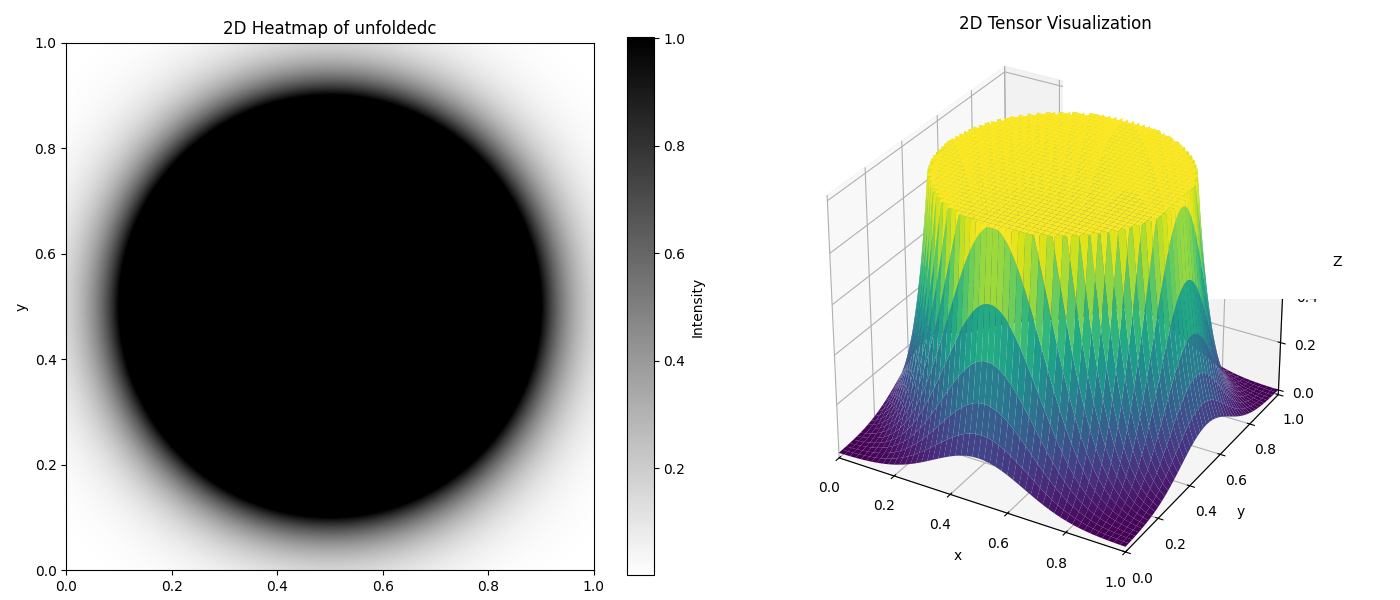

In [80]:
# 2D delta function
p=9
n = 2**p
N = [2**p,2**p]
ones = tntt.ones([2]*p)
unif = X_qtt(p)
perm = bit_reverse_indices(p)
#reverse X
X = tntt.kron( unif,ones)
XR = tntt.kron( reversett(unif),ones)
Y = tntt.kron(ones,unif)
YR = tntt.kron( ones,reversett(unif))
Xz = zkron(unif,ones)
Yz = zkron(ones,unif)

md = [X.full(), Y.full()]
mdz = [Xz.full(), Yz.full()]
mdr = [XR.full(), Y.full()]
mdrr = [X.full(), YR.full()]
#f = lambda x : tn.where(tn.isclose(x[0], x[1], rtol=1e-15, atol=1e-14) ,1 ,0)
f = lambda x  : tn.where( x[0] == x[1],1,0)
eyeR = tntt.TT( tn.tensor(f(mdr),dtype=tn.float64), [2]*p*2).round()
eyeRR = tntt.TT( tn.tensor(f(mdrr),dtype=tn.float64), [2]*p*2).round()
eye = tntt.TT( tn.tensor(f(md),dtype=tn.float64), [2]*p*2).round()
eyez = tntt.TT( tn.tensor(f(mdz),dtype=tn.float64), [4]*p)

print('erank comb',erank(eyeR.R,eyeR.N))
print('erank comb inverse',erank(eyeRR.R,eyeRR.N))
print('erank seq',erank(eye.R,eye.N))
print('erank interleaved',erank(eyez.R,eyez.N))


# Plotting the 
pmask = eyez.full()
pmask = z_order_to_normal_torch( eyez.full().reshape(-1),2**p,2**p)
plt.imshow(pmask, cmap='binary', interpolation='none',extent=[0, 1, 0, 1])
plt.title('2D Tensor Visualization')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


#### Testing 2D encodings

In [81]:
#degree of smoothness
factor = 50
#geometry functions
def Fcircle(x,y,c = (0.5,0.5),r=0.2):

    #return tn.where( (md[:,0] - c[0])**2 + (md[:,1] - c[1])**2 < r**2, 1, -1 )
    q = tn.tensor((x - c[0])**2 + (y - c[1])**2 - r**2)
    return tn.exp(-factor*(q+tn.abs(q)))
def circle(md,c = (0.5,0.5),r=0.2):

    #return tn.where( (md[:,0] - c[0])**2 + (md[:,1] - c[1])**2 < r**2, 1, -1 )
    q = (md[:,0] - c[0])**2 + (md[:,1] - c[1])**2 - r**2
    return tn.exp(-factor*(q+tn.abs(q)))

def tncircle(md,c = (0.5,0.5),r=0.2):

    #return tn.where( (md[0] - c[0])**2 + (md[1] - c[1])**2 < r**2, 1, 0 )
    q = (md[0] - c[0])**2 + (md[1] - c[1])**2 - r**2
    return tn.exp(-factor*(q+tn.abs(q)))

def tncircleR(md,c = (0.5,0.5),r=0.2):

    def f(x): 
        return c[1] - tn.sqrt(-(c[0]-md[0])**2+r**2)
    return tn.where( tn.abs(md[0] - c[0]) < r, tn.where(md[1]<f(md[0]),1,-1), -1 )
    #return tn.where( (md[0] - c[0])**2 + (md[1] - c[1])**2 < r**2, tn.exp( -1000*( (md[0] - c[0])**2 + (md[1] - c[1])**2) ), 1 )
    #anulus
    #return tn.where( ((md[0] - c[0])**2 + (md[1] - c[1])**2 < r**2) , tn.where(0.1**2< (md[0] - c[0])**2 + (md[1] - c[1])**2,1,0) , 0 )

def tnsphere(md,c = (0.5,0.5,0.5),r=0.3):

    return tn.where( (md[0] - c[0])**2 + (md[1] - c[1])**2 + (md[2] - c[2])**2 < r**2, 1, 0 )
    q = (md[0] - c[0])**2 + (md[1] - c[1])**2 - r**2
    return tn.exp(-100*(q+tn.abs(q)))

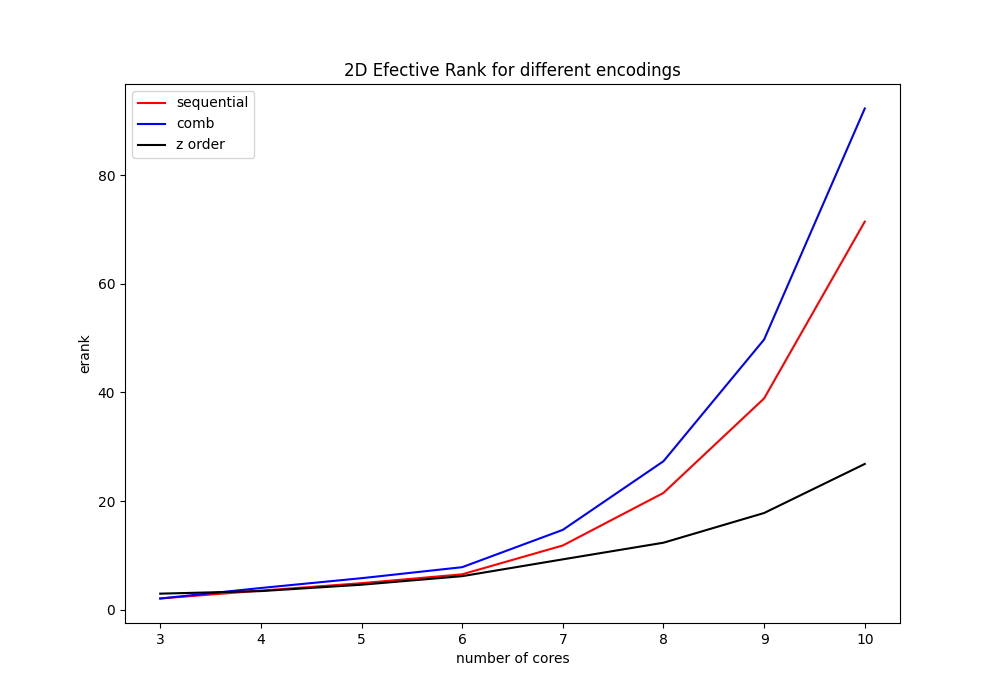

In [82]:
# test different encodings
seqr = []
combr = []
intr = []
ncores = range(3,11)
for p in ncores:
    n = 2**p
    N = [2**p,2**p]
    ones = tntt.ones([2]*p)
    unif = X_qtt(p)
    perm = bit_reverse_indices(p)
    #reverse X
    X = tntt.kron( unif,ones)
    XR = tntt.kron( reversett(unif),ones)
    Y = tntt.kron(ones,unif)
    Xz = zkron(unif,ones)
    Yz = zkron(ones,unif)

    md = [X.full(), Y.full()]
    mdz = [Xz.full(), Yz.full()]
    mdr = [XR.full(), Y.full()]

    masksvdR = tntt.TT( tn.tensor(tncircleR(mdr),dtype=tn.float64), [2]*p*2)
    masksvd = tntt.TT( tn.tensor(tncircleR(md),dtype=tn.float64), [2]*p*2)
    masksvdz = tntt.TT( tn.tensor(tncircleR(mdz),dtype=tn.float64), [4]*p)
    
    print('number of cores',p, end='\r')
    seqr.append( erank(masksvd.R,masksvd.N) )
    combr.append( erank(masksvdR.R,masksvdR.N) )
    intr.append( erank(masksvdz.R,masksvdz.N) )
    
    
plt.figure(figsize=(10,7))
plt.plot(ncores, seqr, c = 'r', label='sequential')
plt.plot(ncores, combr, c='b',label='comb')
plt.plot(ncores, intr, c = 'black',label='z order')
plt.xlabel('number of cores')
plt.ylabel('erank')
plt.legend()
plt.title('2D Efective Rank for different encodings')
plt.show()

#### 2d Visualization

In [ ]:
# Build 2D masks
p = 6
n = 2**p
N = [2**p,2**p]
#use a different base
q = 1
b = 2**q
shape = [b]*(p//q)*2
ones = tntt.ones([2]*p)
unif = X_qtt(p)
perm = bit_reverse_indices(p)
#reverse X
X = tntt.kron( unif,ones)
XR = tntt.kron( reversett(unif),ones)
Y = tntt.kron(ones,unif)
Xz = zukron(unif,ones)
Yz = zukron(ones,unif)

morton = compute_morton_indices(p)
md = [X.full().reshape(N), Y.full().reshape(N)]
mdz = [Xz.full().reshape(-1), Yz.full().reshape(-1)]
mdr = [XR.full().reshape(N), Y.full().reshape(N)]

masksvdR = tntt.TT( tn.tensor(tncircle(mdr),dtype=tn.float64), [2]*p*2).round(1e-14)
masksvd = tntt.TT( tn.tensor(tncircle(md),dtype=tn.float64), [2]*p*2).round(1e-14)
masksvdz = tntt.TT( tn.tensor(tncircle(mdz),dtype=tn.float64), [2]*p*2).round(1e-14)
masksvd,masksvdR, masksvdz

In [ ]:
#Plots 


# Plotting sequential
plt.imshow(masksvd.full().reshape(N), cmap='binary', interpolation='none',extent=[0, 1, 0, 1])
plt.title('2D Tensor Visualization')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Plotting comb
plt.imshow(masksvdR.full().reshape(N)[perm,:], cmap='binary', interpolation='none',extent=[0, 1, 0, 1])
plt.title('2D Tensor Visualization')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


# Plotting zorder 
pmask = z_order_to_normal_torch(masksvdz.full().reshape(-1),2**p,2**p)
plt.imshow(pmask, cmap='binary', interpolation='none',extent=[0, 1, 0, 1])
plt.title('2D Tensor Visualization')
plt.xlabel('x')
plt.ylabel('y')
plt.show()



In [ ]:
#To check
image0 = tntt.interpolate.function_interpolate(circle, [XR,Y],nswp=20, eps=1e-17,kick=10)

image0 = (mask+1)/2
mask = mask.round()
print(mask)

tmask = mask.full().reshape(N)
tmask = tmask[perm,:]
# Plotting the tensor
plt.imshow(tmask, cmap='binary', interpolation='none',extent=[0, 1, 0, 1])
plt.title('2D Tensor Visualization')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


### 3D

In [ ]:
# sequential vs interleaved 3D
seqr = []
intr = []
ncores = range(2,10)
for p in ncores:
    n = 2**p
    N = [2**p]*3
    ones = tntt.ones([2]*p)
    unif = X_qtt(p)
    perm = bit_reverse_indices(p)
    #reverse X
    X = tntt.kron( tntt.kron( unif,ones), ones)
    Y = tntt.kron( tntt.kron(ones,unif), ones)
    Z = tntt.kron( tntt.kron(ones,ones), unif)
    Xz = zkron3(unif,ones,ones)
    Yz = zkron3(ones,unif,ones)
    Zz = zkron3(ones,ones,unif)

    md = [X.full(), Y.full(), Z.full()]
    mdz = [Xz.full(), Yz.full(),Zz.full()]

    masksvd = tntt.TT( tn.tensor(tnsphere(md),dtype=tn.float64), [2]*p*3)
    masksvdz = tntt.TT( tn.tensor(tnsphere(mdz),dtype=tn.float64), [8]*p)
    print('number of cores',p, end='\r')
    seqr.append( erank(masksvd.R,masksvd.N) )
    intr.append( erank(masksvdz.R,masksvdz.N) )
    
    
plt.figure(figsize=(10,7))
plt.plot(ncores, seqr, c = 'r', label='sequential')
plt.plot(ncores, intr, c = 'black',label='z order')
plt.xlabel('number of cores')
plt.ylabel('erank')
plt.legend()
plt.title('3D efctive rank')
plt.show()

##### 3d visuzalization

In [ ]:
# 3D Plots
vol = masksvd.full().reshape(N).round(decimals=2)
plot_volume_voxels_binary(vol, threshold=0.5)
volz = masksvdz.full().flatten().round(decimals=2)
vol = z_order_to_normal_torch_3d(volz, 2**p,2**p,2**p)
plot_volume_voxels_binary(vol, threshold=0.5)

# Taylor Series Expansion

In [31]:
import torch


def finite_diff_coeffs(stencil: tn.Tensor, max_deriv: int, x0: float = 0.0) -> tn.Tensor:
    n = len(stencil)
    c = tn.zeros((max_deriv + 1, n), dtype=stencil.dtype)
    c[0, 0] = 1.0
    c1 = 1.0
    c4 = stencil[0] - x0
    for i in range(1, n):
        mn = min(i, max_deriv)
        c2 = 1.0
        c5 = c4
        c4 = stencil[i] - x0
        for j in range(i):
            c3 = stencil[i] - stencil[j]
            c2 *= c3
            if j == i - 1:
                for k in range(mn, 0, -1):
                    c[k, i] = c1 * (k * c[k - 1, i - 1] - c5 * c[k, i - 1]) / c2
                c[0, i] = -c1 * c5 * c[0, i - 1] / c2
            for k in range(mn, 0, -1):
                c[k, j] = (c4 * c[k, j] - k * c[k - 1, j]) / c3
            c[0, j] = c4 * c[0, j] / c3
        c1 = c2
    return c

def finite_diff_coeffs_accuracy(max_deriv: int, accuracy: int, h: float = 1.0) -> tn.Tensor:
    coeffs_list = []
    for d in range(max_deriv + 1):
        if d == 0:
            stencil = tn.tensor([0.0], dtype=tn.float64)
            coeff = finite_diff_coeffs(stencil, 0, x0=0.0)[0]
        else:
            stencil = tn.arange(0, d + accuracy, dtype=tn.float64) * h
            coeff = finite_diff_coeffs(stencil, d, x0=0.0)[d]
        coeffs_list.append(coeff)
    max_len = max(c.numel() for c in coeffs_list)
    pad_len = 2 ** math.ceil(math.log2(max_len)) if max_len > 0 else 1
    result = tn.zeros((max_deriv + 1, pad_len), dtype=tn.float64)
    for i, c in enumerate(coeffs_list):
        result[i, :c.numel()] = c
    return result

def forward_diff_coeffs_accuracy(max_deriv: int, accuracy: int, h: float = 1.0) -> tn.Tensor:
    return finite_diff_coeffs_accuracy(max_deriv, accuracy, h)

def forward_diff_coeffs(num_points: int, max_deriv: int, h: float = 1.0) -> torch.Tensor:
    """
    Compute forward difference coefficients using a forward stencil.
    
    In a forward difference scheme the grid points are:
      x0, x0+h, x0+2h, ..., x0+(num_points-1)*h.
    For convenience, x0 is taken as 0.
    
    Parameters:
        num_points (int): Number of points in the stencil (should be at least max_deriv+1).
        max_deriv (int): The highest derivative order to approximate.
        h (float): Grid spacing (default is 1.0).
    
    Returns:
        torch.Tensor: A coefficient matrix of shape (max_deriv+1, num_points) where each row i 
                      provides the coefficients to approximate the i-th derivative.
    """
    # Define a forward stencil: 0, h, 2h, ..., (num_points-1)*h.
    stencil = torch.arange(0, num_points, dtype=torch.float64) * h
    # Compute coefficients with the evaluation point at x0=0.
    return finite_diff_coeffs(stencil, max_deriv, x0=0.0)


def apply_local_op(mps,index,local_op):
    cores = mps.cores

    cores[index] = tn.einsum( 'abc, bd -> adc',cores[index],local_op)

    return tntt.TT(cores)

def Jttpols(polcores, dir = 'f'):

    
    if dir == 'f':
        fcores = [polcores[i][0] for i in range(len(polcores))]
        fc = torch.cat(fcores, dim=0)
    return [fc] + polcores[0][1::]

def connectT(mps1,Tcores,pd=3):


    cores1 = mps1.cores
    cc = tn.einsum( 'ab,bcd -> acd', cores1[-1].reshape(-1,pd), Tcores[0])

    newcores = cores1[0:-1] + [cc] +  Tcores[1:]

    return tntt.TT(newcores)


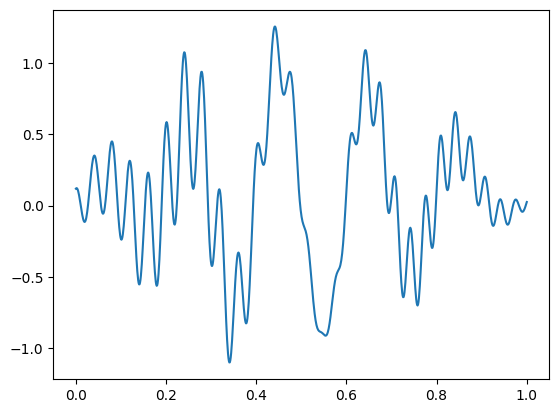

In [97]:
import torch
import matplotlib.pyplot as plt
import scipy
from time import time

def test_function(x):
    term1 = torch.sin( 10* torch.pi * x) * torch.exp(-10 * (x - 0.5)**2)
    term2 = 0.5 * torch.cos(50 * torch.pi * x) * torch.exp(-20 * (x - 0.25)**2)
    term3 = 0.3 * torch.sin(60 * torch.pi * x) * torch.exp(-30 * (x - 0.75)**2)
    poly = 0.2 * (x - 0.5)**3
    series = sum(0.1 / (2**n) * torch.sin((2 * n + 1) * torch.pi * x) for n in range(3))
    return term1 + term2 + term3 + poly + series


def noisy_test_function(x, noise_std=0.0000001):
    y = test_function(x)
    noise = torch.randn_like(y) * noise_std
    return y + noise


#test_function = lambda x : ( tn.tensor( scipy.special.eval_chebyt(10, 2*(0.5-x.numpy())) ) )*tn.log(1+x)
x = torch.linspace(0, 1, 1000)
y = test_function(x)
plt.plot(x.numpy(), y.numpy())
plt.show()


In [101]:
o = 2
cg = 16
extdim = 5
max_deriv = 3
acc = 3
id = tn.eye(max_deriv+1,dtype=tn.float64)
#h = 1/2**(o+cg)
h = 1.0

x = tntt.TT(qtt_polynomial_cores([0,1],cg+o,basis='m'))
x0 = x.full().reshape(-1)

t1 = time()
y0 = test_function(x0)
fc0 = tntt.TT(y0,[2]*(cg+o),eps=1e-14)
t2 = time()
#coeffs = forward_diff_coeffs_accuracy(max_deriv, acc)
coeffs = forward_diff_coeffs(2**o, max_deriv,h=h)
fc = apply_local_op( tntt.reshape(fc0, [2]*cg + [2**o]),-1,coeffs.t()) 


polcores = [qtt_polynomial_cores((2**(o*k)/math.factorial(k))*id[k],extdim,basis='m') for k in range(max_deriv+1)]
pols = Jttpols(polcores,dir='f')

hTaylor = connectT(fc,pols,pd=max_deriv+1)

print(f'time {t2-t1:.2f} s')

finegrid = tntt.TT(qtt_polynomial_cores([0,1],cg+extdim,basis='m') )


time 0.25 s


In [103]:

Y = test_function(finegrid.full())
error = (hTaylor.full()-Y).norm()/Y.norm()
print('erank',f'{erank(hTaylor.R,hTaylor.N):.1f}')
print( f'error Taylor {error:.4e}')
print(hTaylor)

erank 8.2
error Taylor 1.4953e-14
TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, 16, 16, 14, 11, 9, 8, 7, 6, 6, 6, 5, 5, 4, 4, 4, 4, 4, 1]

Device: cpu, dtype: torch.float64
#entries 2576 compression 0.00122833251953125



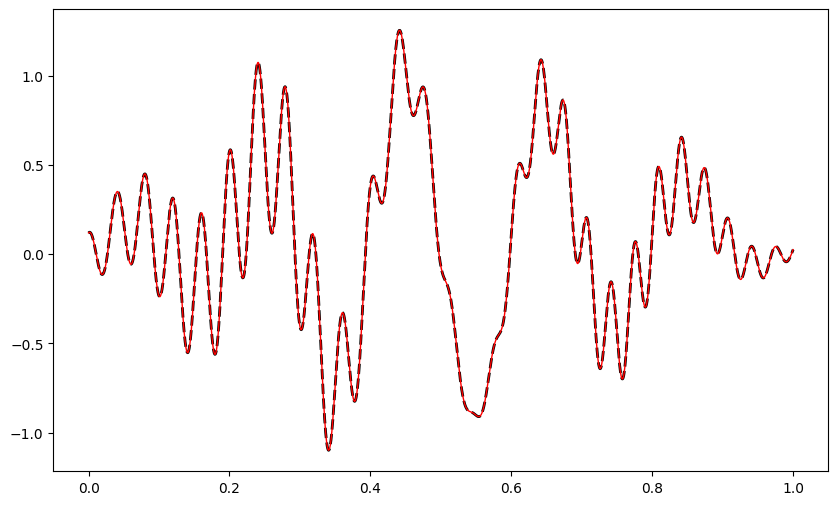

In [104]:
X = finegrid.full().reshape(-1)
plt.figure(figsize=(10,6))
plt.plot(x0,y0,c='k',lw=2,linestyle='--')
plt.plot(X,hTaylor.full().reshape(-1),c='r',lw=1)
plt.show()

In [105]:

t1 = time()
httc = tntt.interpolate.function_interpolate(test_function,finegrid,eps=1e-14)
t2 = time()
t = t2-t1
print(httc)
print('erank',f'rank {erank(httc.R,httc.N):.1f}', f'time {t:.2f} s')
#check error
errorttc = (httc.full()-Y).norm()/Y.norm()
print(f'error ttc {errorttc:.4e}')

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 4, 6, 10, 18, 18, 16, 14, 12, 11, 10, 10, 9, 9, 8, 8, 7, 7, 7, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 4226 compression 0.0020151138305664062

erank rank 10.5 time 0.28 s
error ttc 7.7368e-15


In [ ]:
times = []
dims = []
edims = 15
nexps = 15
for j in range(0,edims):
    finegrid = tntt.TT(qtt_polynomial_cores([0,1],cg+j,basis='m') )
    t =0
    for i in range(nexps):
        t1 = time()
        httc = tntt.interpolate.function_interpolate(test_function,finegrid,eps=1e-14)
        t2 = time()
        t += t2-t1
    times.append(t/nexps)
    dims.append(cg+j)

plt.plot(dims,times)
plt.xlabel('number of cores')
plt.ylabel('time (s)')
plt.title('TCI time')
plt.show()

# 1D MPS interpolation

We'll see how to extend the domain of our qtt function

## Polynomial Interpolation

### Example Function

Lets start with a function that it's not that good with a polynomial interpolation, but can be done easily with splines

In [114]:
# initial coarse dimension
nc = 5

In [115]:
# Extended dimension
nlc = 5

In [116]:
# function to interpolate

f  = lambda x : 1000*(x-.1)*(x-.3)*(x-.8)/(1+20*(x-0.3)**2 + 10*x + 2*(x-.7)**4)

f_rescaled = lambda x: f(2*x)
g = lambda x: 1000*(x - 0.6)*(x - 0.8)*(x - 0.95) / (1 + 10*(x - 0.8)**2 + 5*x + 3*(x - 0.85)**4)

# Define the overall piecewise function
def F(x):
    return tn.where(x <= 0.5, f_rescaled(x), g(x))

F = lambda x: 1/(1+ 25*(x-0.5)**2)

# given MPS
ftt  = tntt.interpolate.function_interpolate(F,X_qtt(nc),eps=1e-15,nswp=30,kick=2).round(1e-15)
print(ftt)

TT with sizes and ranks:
N = [2, 2, 2, 2, 2]
R = [1, 2, 4, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 72 compression 2.25



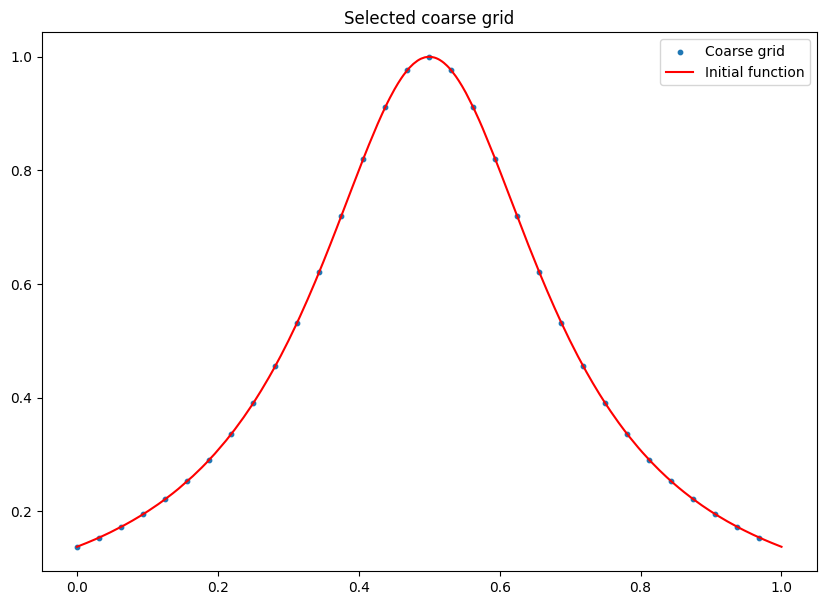

error TCA 4.1e-18
TT with sizes and ranks:
N = [2, 2, 2, 2, 2]
R = [1, 2, 4, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 72 compression 2.25



In [117]:
# Plot
plt.figure(figsize=(10,7))
d0 = X_qtt(nc).full().reshape(2**nc)
y = ftt.full().reshape(2**nc)
plt.scatter(d0,y,s=10,label='Coarse grid')
#plt.plot(d0 ,y , c= 'b',linestyle='--',lw=2)

dom = tn.linspace(0,1, int(1e6))
plt.plot(dom,F(dom) ,c='r',label = 'Initial function')
plt.title('Selected coarse grid')
plt.legend()
plt.show()

error = tn.norm(F(d0) - y)/tn.norm(F(dom))
print(f"\033[93merror TCA\033[0m {error.item():.1e}")
print(ftt)


### 0-th order (left interpolant)

The trivial interpolation is just extending the domain of the previous point

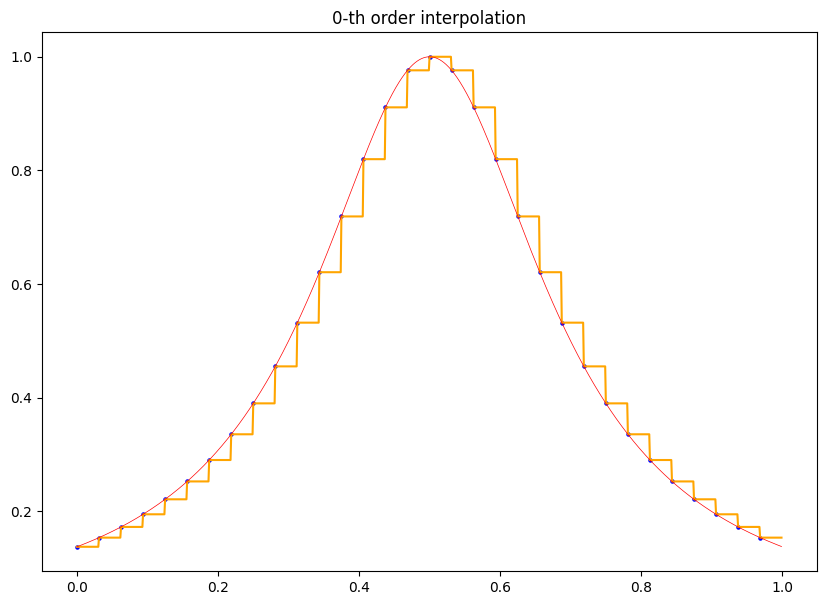

error  6.2e-02


TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 4, 2, 1, 1, 1, 1, 1, 1]

Device: cpu, dtype: torch.float64
#entries 82 compression 0.080078125

In [245]:
# Construct left interpolant
f_interpolated0 = tntt.kron(ftt,tntt.ones([2]*nlc))

nt = nc+nlc

new_dom = X_qtt(nt).full().reshape(2**nt)
y_interpolated = f_interpolated0.full().reshape(2**nt)

plt.figure(figsize=(10,7))
plt.scatter(d0,y,s=5,c='b')

plt.plot(new_dom, y_interpolated,c='orange')
plt.plot(new_dom,F(new_dom),c='r',linewidth=0.5)
plt.title('0-th order interpolation')
plt.show()

error_c = (tn.linalg.norm(y_interpolated-F(new_dom))/tn.linalg.norm(F(new_dom))).item()
print(f"\033[93merror \033[0m {error_c:.1e}")

f_interpolated0

### 0.1-th order Nearest Neighbours

<!-- Theory -->
We can improve the 0 order approximation choosing the value of the nearest neighbour. For that we need a boundary condition and some simple step functions.

For the construction we need the translation operator, so the final function is a superposition of the left and right interpolants

$$ \varphi_1(x) = 1-\Theta(x-.5) $$
$$ \varphi_2(x) = \Theta(x-.5) $$

where $\Theta(x)$ if the Heaviside theta function. Notice that $\sum_i \varphi_i(x) = 1 $ is a partition of unity

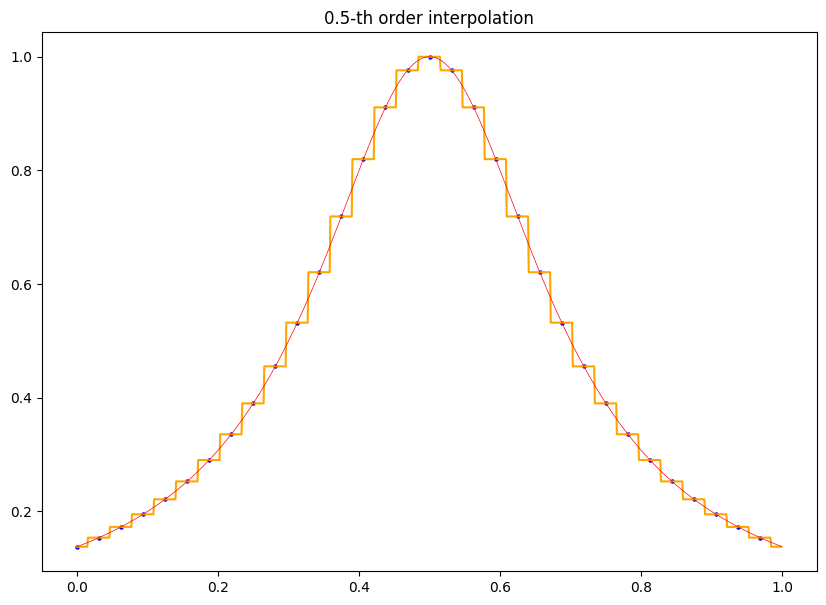

error  3.2e-02
TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2]
R = [1, 2, 4, 5, 3, 2, 2, 1, 1, 1, 1, 1, 1]

Device: cpu, dtype: torch.float64
#entries 119 compression 0.1162109375



In [246]:
# Construct nearest neighbours interpolant
sm = R_qtt( 2**nc -1, nc)
phi1 = h(nlc,'1')
phi2 = h(nlc,'2')
f_interpolated01 = tntt.kron(ftt,phi1) +  tntt.kron(sm@ftt + dmps(2**nc -1,nc)*F(tn.tensor(1.0)), phi2)
f_interpolated01 = f_interpolated01.round(1e-15)
nt = nc+nlc

new_dom = X_qtt(nt).full().reshape(2**nt)
y_interpolated = f_interpolated01.full().reshape(2**nt)

plt.figure(figsize=(10,7))
plt.scatter(d0,y,s=5,c='b')

plt.plot(new_dom, y_interpolated,c='orange',)
plt.plot(new_dom,F(new_dom),c='r',linewidth=0.5)
plt.title('0.5-th order interpolation')
plt.show()

error_c1 = (tn.linalg.norm(y_interpolated-F(new_dom))/tn.linalg.norm(F(new_dom))).item()
print(f"\033[93merror \033[0m {error_c1:.1e}")
print(f_interpolated01)

### Linear interpolation

<!-- Theory -->
We can do the linear interpolation in each sub domain with the shape functions 

$$ \varphi_1(x) = 1-x $$
$$ \varphi_2(x) = x $$

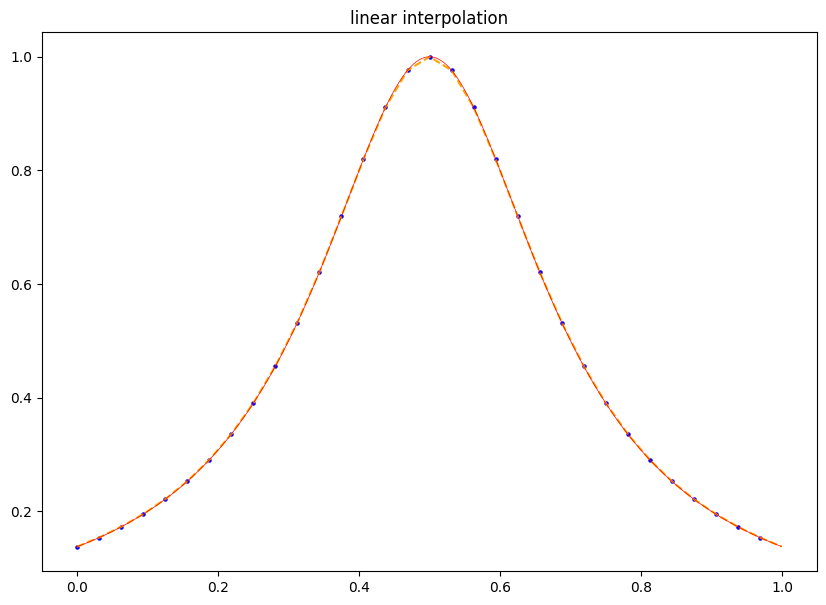

error  2.7e-03
TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 5, 3, 2, 2, 2, 2, 2, 1]

Device: cpu, dtype: torch.float64
#entries 138 compression 0.134765625



In [247]:
#Construct linear interpolation

phi1 = tntt.TT(qtt_polynomial_cores([1,-1], nlc))
phi2 = tntt.TT(qtt_polynomial_cores([0,1], nlc))

# define shift matrix
sm = R_qtt( 2**nc -1, nc)

f_interpolated = tntt.kron(ftt,phi1) + tntt.kron( (sm@ftt + dmps(2**nc -1,nc)*F(tn.tensor(1.0))).round(), phi2)
f_interpolated = f_interpolated.round(1e-15)
nt = nc+nlc

new_dom = X_qtt(nt).full().reshape(2**nt)
y_interpolated = f_interpolated.full().reshape(2**nt)

plt.figure(figsize=(10,7))
plt.scatter(d0,y,s=5,c='b')

plt.plot(new_dom, y_interpolated,c='orange',linestyle='--')
plt.plot(new_dom,F(new_dom),c='r',linewidth=0.5)
plt.title('linear interpolation')
plt.show()

error_linear = (tn.linalg.norm(y_interpolated-F(new_dom))/tn.linalg.norm(F(new_dom))).item()

print(f"\033[93merror \033[0m {error_linear:.1e}")
print(f_interpolated)

### Quadratic Approximation

<!-- Theory -->
We could also use a different basis of shape functions, for example cuadratic

$$ \phi_1 (x) = 2(1/2-x)(1-x)$$
$$ \phi_2 (x) = 4(x)(1-x)$$
$$ \phi_3 (x) = -2(x)(1/2-x) $$

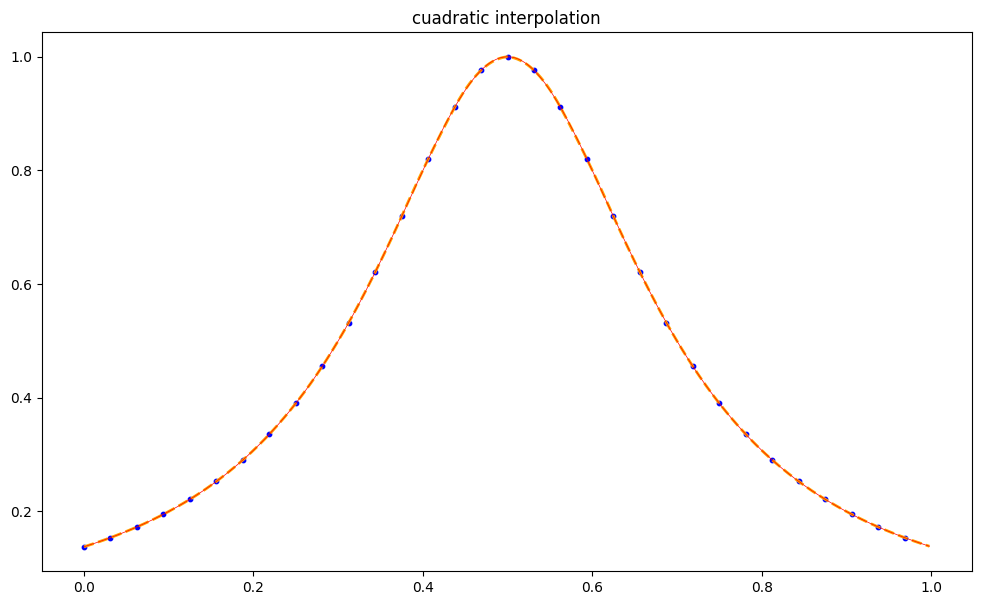

error  5.8e-04
TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 5, 3, 3, 3, 3, 2, 1]

Device: cpu, dtype: torch.float64
#entries 160 compression 0.3125



In [248]:
# Build quadratic interpolant

phi1 = tntt.TT(qtt_polynomial_cores([1,-3,2], nlc))
phi2 = tntt.TT(qtt_polynomial_cores([0,4,-4], nlc))
phi3 = tntt.TT(qtt_polynomial_cores([0,-1,2], nlc))


fttr0 = reduce(ftt,0)
fttr1 = reduce(ftt,1)
# define shift matrix
sm = R_qtt( 2**(nc-1) -1, nc-1)

f_interpolated2 = tntt.kron(fttr0,phi1) + tntt.kron(fttr1,phi2) + tntt.kron( (sm@fttr0 + dmps(2**(nc-1) -1,nc-1)*F(tn.tensor(1))).round(1e-14), phi3)
f_interpolated2 = f_interpolated2.round(1e-15)
nt = nc+nlc-1

new_dom = X_qtt(nt).full().reshape(2**nt)
y_interpolated2 = f_interpolated2.full().reshape(2**nt)

plt.figure(figsize=(12,7))
plt.scatter(d0,y,s=10,c='b')

plt.plot(new_dom, y_interpolated2,c='orange',linewidth=2,linestyle='--')
plt.plot(new_dom,F(new_dom),c='r',linewidth=0.5)
plt.title('cuadratic interpolation')
plt.show()

error_q =(tn.linalg.norm(y_interpolated2-F(new_dom))/tn.linalg.norm(F(new_dom))).item()

print(f"\033[93merror \033[0m {error_q:.1e}")
print(f_interpolated2)

### Natural cubic spline $C^2$ interpolation

<!-- Theory -->
Given \( n \) data points \((t_i, f_i)\) with \( t_0 < t_1 < \cdots < t_{n-1} \), cubic splines are constructed by joining \( n-1 \) cubic polynomials defined on each interval \([t_i, t_{i+1}]\). Each spline segment is given by

$$
P_i(t) = p_{i,0} + p_{i,1}\left(\frac{t-t_i}{\Delta_i}\right) + p_{i,2}\left(\frac{t-t_i}{\Delta_i}\right)^2 + p_{i,3}\left(\frac{t-t_i}{\Delta_i}\right)^3,
$$

where \( \Delta_i = t_{i+1} - t_i \) and \(0 \leq i \leq n-2\).

1. **Interpolation Conditions:**
   - For each interval, the polynomial must match the function value at the left endpoint:
     
     $$
     P_i(t_i) = f_i \quad \text{for } i = 0, \dots, n-2,
     $$
     
   - And at the final knot:
     
     $$
     P_{n-2}(t_{n-1}) = f_{n-1}.
     $$

2. **Continuity Conditions at Interior Knots \(t_{i+1}\) for \(i=0,\dots,n-3\):**
   - **Function continuity:**
     
     $$
     P_i(t_{i+1}) = P_{i+1}(t_{i+1}),
     $$
     
   - **First derivative continuity:**
     
     $$
     P_i^{(1)}(t_{i+1}) = P_{i+1}^{(1)}(t_{i+1}),
     $$
     
   - **Second derivative continuity:**
     
     $$
     P_i^{(2)}(t_{i+1}) = P_{i+1}^{(2)}(t_{i+1}).
     $$

3. **Boundary Conditions:**
   - Two extra constraints (which can be chosen as free, clamped, or closed conditions) are imposed to obtain a unique spline.


After using the interpolation constraints to set 

$$
p_{i,0} = f_i,
$$

the remaining coefficients \( p_{i,1} \), \( p_{i,2} \), and \( p_{i,3} \) must satisfy

$$
\begin{aligned}
p_{i,1} + p_{i,2} + p_{i,3} &= f_{i+1} - f_i, \quad & (i=0,\dots,n-2),\\[1mm]
p_{i,1} + 2p_{i,2} + 3p_{i,3} &= \sigma_i\, p_{i+1,1}, \quad & (i=0,\dots,n-3),\\[1mm]
p_{i,2} + 3p_{i,3} &= \sigma_i^2\, p_{i+1,2}, \quad & (i=0,\dots,n-3),
\end{aligned}
$$

with 

$$
\sigma_i = \frac{\Delta_i}{\Delta_{i+1}}.
$$

These equations form a block‑tridiagonal linear system in \( 3(n-1) \) unknowns, which can be solved very efficiently in <span style="color:red"><strong>O(n)</strong></span> time.


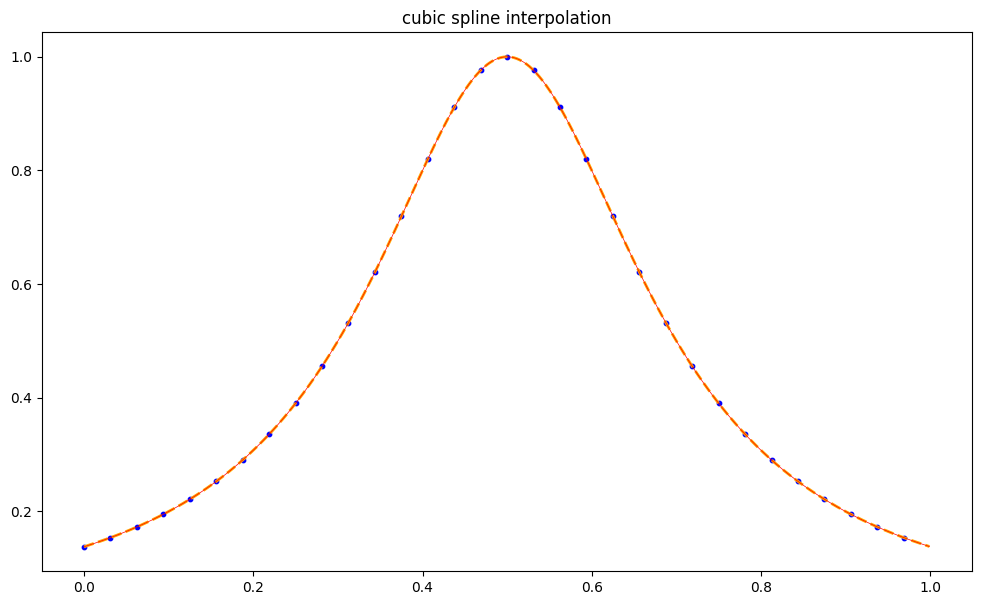

error  3.9e-05
TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 7, 5, 4, 4, 4, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 302 compression 0.294921875



In [249]:
# Build C2 spline interpolant
D = tn.tensor([[1,1,1],[1,2,3],[0,1,3]], dtype=tn.float64)
S = tn.tensor([[0,0,0],[-1,0,0],[0,-1,0]], dtype=tn.float64)
L = tn.tensor([[0,0,0],[0,0,0],[0,1,0]], dtype=tn.float64)
R = tn.tensor([[1,1,1],[0,1,3],[0,0,0]], dtype=tn.float64)

Dtt = tntt.TT(D,[(3,3)])
Stt = tntt.TT(S,[(3,3)])
Ltt = tntt.TT(L,[(3,3)])
Rtt = tntt.TT(R,[(3,3)])
RDtt = tntt.TT(R-D,[(3,3)])
sm = R_qtt(2**(nc)-1, nc)
diffO = (-I_qtt(nc)+sm).round(1e-15)

rhsv = tntt.TT(tn.tensor([1,0,0],dtype=tn.float64),[3])

bigO = tntt.kron(I_qtt(nc),Dtt) + tntt.kron(sm,Stt)  + tntt.kron(dmpo(2**nc-1,0,nc), Ltt) + tntt.kron(dmpo(2**nc-1,2**nc-1,nc), RDtt) 
bigO = bigO.round(1e-15)
RHS = tntt.kron( (diffO @ ftt + dmps(2**(nc) -1,nc)*F(tn.tensor(1)) ).round(1e-15) , rhsv )

coefs = tntt.solvers.amen_solve(bigO, RHS, eps=1e-15,kickrank=1,nswp=20).round(1e-15)
t1 = tntt.TT(qtt_polynomial_cores([0,1,0,0], nlc))
t2 = tntt.TT(qtt_polynomial_cores([0,0,1,0], nlc))
t3 = tntt.TT(qtt_polynomial_cores([0,0,0,1], nlc))

pol = tntt.kron( tntt.TT(tn.tensor([1,0,0],dtype=tn.float64)),t1 ) + tntt.kron( tntt.TT(tn.tensor([0,1,0],dtype=tn.float64)),t2 ) + tntt.kron( tntt.TT(tn.tensor([0,0,1],dtype=tn.float64)),t3 )
pol = pol.round(1e-15)
f_cubicspline = tntt.kron(ftt,tntt.ones([2]*nlc)) + connect(coefs,pol) 

f_cubicspline = f_cubicspline.round(1e-15)

nt = nc+nlc

new_dom = X_qtt(nt).full().reshape(2**nt)
y_cspline = f_cubicspline.full().reshape(2**nt)

plt.figure(figsize=(12,7))
plt.scatter(d0,y,s=10,c='b')

plt.plot(new_dom, y_cspline,c='orange',linewidth=2,linestyle='--')
plt.plot(new_dom,F(new_dom),c='r',linewidth=0.5)
plt.title('cubic spline interpolation')
plt.show()

error_cspline =(tn.linalg.norm(y_cspline-F(new_dom))/tn.linalg.norm(F(new_dom))).item()

print(f"\033[93merror \033[0m {error_cspline:.1e}")
print(f_cubicspline)

### Cubic Kernel Spline $C^1$ Interpolation


<!-- Theory -->
Solving a linear system for cubic spline interpolation may be unstable. An alternative is kernel cubic spline approximation via convolution. The interpolation function is computed as

$$
g(x) = \sum_{k} f(x_k) \, u\left(\frac{x-x_k}{h}\right),
$$

where \(f(x_k)\) are the sample values, \(h\) is the sampling interval, and the kernel \(u(s)\) satisfies

$$
u(0)=1,\quad u(n)=0,\quad \text{for } n\in\mathbb{Z}\setminus\{0\}.
$$

A common cubic convolution kernel with parameter \(a\) is given by

$$
u(s)=
\begin{cases}
(a+2)|s|^3 - (a+3)|s|^2 + 1, & |s| < 1,\\[1mm]
a|s|^3 - 5a|s|^2 + 8a|s| - 4a, & 1 \le |s| < 2,\\[1mm]
0, & |s| \ge 2.
\end{cases}
$$

This kernel yields an interpolation error of

$$
f(x)-g(x)=O(h^3),
$$

ensuring third-order convergence, albeit at the expense of not guaranteeing a continuous second derivative.

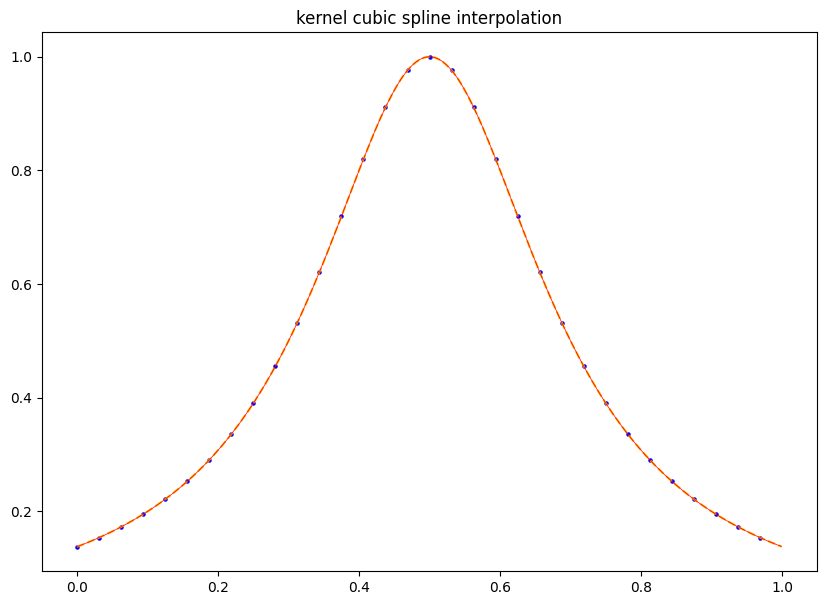

error  1.9e-04
TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 7, 5, 4, 4, 4, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 302 compression 0.294921875



In [250]:
# Build Kernel interpolant
Mkc = tn.tensor([
    [0, 2, 0, 0],
    [-1, 0, 1, 0],
    [2, -5, 4, -1],
    [-1, 3, -3, 1]
], dtype=tn.float32) /2

Mkct = Mkc.t()
sm1 = R_qtt( 2**nc -1, nc)
sm2 = R_qtt( 2**nc -2, nc)
smm1 = L_qtt( 1, nc)
I4 = tn.eye(4,dtype=tn.float64)
t4 = [ tntt.TT(I4[i]) for i in range(4)]
f_kcs = tntt.kron( (smm1 + 3*dmpo(0,0,nc) - 3*dmpo(0,1,nc) + dmpo(0,2,nc) ) @ ftt ,t4[0]) + tntt.kron(ftt,t4[1]) + tntt.kron(sm1@ftt+dmps(2**nc -1,nc)*F(tn.tensor(1.0)),t4[2]) 
f_kcs += tntt.kron(((sm2 - 3*dmpo(2**nc-1,2**nc-1,nc) + dmpo(2**nc-1,2**nc-2,nc)) @ftt) + ( dmps(2**nc -2,nc) + 3*dmps(2**nc -1,nc) )*F(tn.tensor(1.0)),t4[3])
f_kcs = f_kcs.round(1e-14)

kpols = [tntt.TT(qtt_polynomial_cores(Mkct[i], nlc)) for i in range(4)]
kpol = tntt.kron(t4[0],kpols[0]) + tntt.kron(t4[1],kpols[1]) + tntt.kron(t4[2],kpols[2]) + tntt.kron(t4[3],kpols[3])
kpol = kpol.round(1e-14)

f_interpolatedkc = connect(f_kcs,kpol,pd=4)
f_interpolatedkc = f_interpolatedkc.round(1e-15)
nt = nc+nlc

new_dom = X_qtt(nt).full().reshape(2**nt)
y_interpolated = f_interpolatedkc.full().reshape(2**nt)

plt.figure(figsize=(10,7))
plt.scatter(d0,y,s=5,c='b')

plt.plot(new_dom, y_interpolated,c='orange',linestyle='--')
plt.plot(new_dom,F(new_dom),c='r',linewidth=0.5)
plt.title('kernel cubic spline interpolation')
plt.show()

error_kc = (tn.linalg.norm(y_interpolated-F(new_dom))/tn.linalg.norm(F(new_dom))).item()

print(f"\033[93merror \033[0m {error_kc:.1e}")
print(f_interpolatedkc)

### Summary

In [251]:
# Results
print('\033[91mscale\033[0m {:.1e}'.format(1/2**nc))
print('error \033[93mleft\033[0m      {:.1e}'.format(error_c))
print('error \033[93mcentral\033[0m   {:.1e}'.format(error_c1))
print('error \033[93mlinear\033[0m    {:.1e}'.format(error_linear))
print('error \033[93mquadratic\033[0m {:.1e}'.format(error_q))
print('error \033[93mcspline\033[0m   {:.1e}'.format(error_cspline))
print('error \033[93mkcspline\033[0m  {:.1e}'.format(error_kc))

print('======================================================')

print('\033[91minitial erank\033[0m   {:.2f}'.format(erank(ftt.R,ftt.N)))  
print('erank    \033[93mleft\033[0m   {:.2f}'.format(erank(f_interpolated0.R,f_interpolated0.N)))  
print('erank  \033[93mcentral\033[0m  {:.2f}'.format(erank(f_interpolated01.R,f_interpolated01.N)))
print('erank   \033[93mlinear\033[0m  {:.2f}'.format(erank(f_interpolated.R,f_interpolated.N))) 
print('erank \033[93mquadratic\033[0m {:.2f}'.format(erank(f_interpolated2.R,f_interpolated2.N)))
print('erank   \033[93mcspline\033[0m {:.2f}'.format(erank(f_cubicspline.R,f_cubicspline.N)))
print('erank  \033[93mkcspline\033[0m {:.2f}'.format(erank(f_interpolatedkc.R,f_interpolatedkc.N)))

scale 3.1e-02
error left      6.2e-02
error central   3.2e-02
error linear    2.7e-03
error quadratic 5.8e-04
error cspline   3.9e-05
error kcspline  1.9e-04
initial erank   2.90
erank    left   2.14
erank  central  2.43
erank   linear  2.75
erank quadratic 3.16
erank   cspline 4.15
erank  kcspline 4.15


## Fourier Interpolation

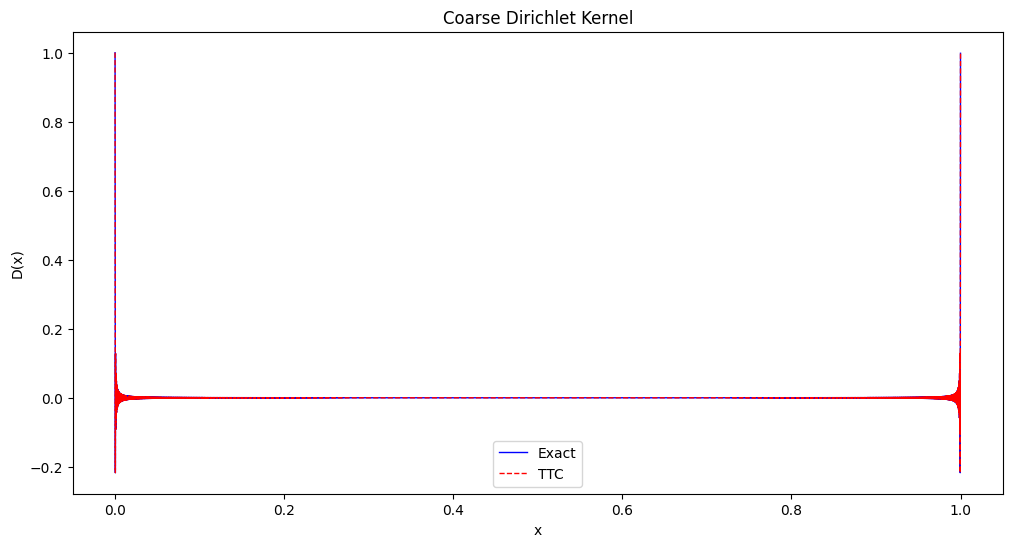

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, 15, 15, 15, 16, 18, 22, 23, 31, 26, 16, 8, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 8294 compression 0.0632781982421875

error 1.1155809612782363e-13


In [149]:
#check bd of Dirichlet kernel
c = nc
td = nc+nlc
dom = (X_qtt(td)).round(1e-15)
N = 2**c 
x = dom.full().reshape(-1)
D = tn.sin(tn.pi*(N * x)) / tn.tan(tn.pi*x ) /N
D[tn.isclose(x, tn.tensor(0., dtype=x.dtype))] = 1

def dk(x,N=N):
    return tn.sin(tn.pi*(N * x)) / tn.tan(tn.pi*x ) /N
  

tdk = tntt.interpolate.function_interpolate(dk, dom,nswp=30, eps=1e-13,kick=2).round(1e-15)
dktt = tdk.full().reshape(-1)


plt.figure(figsize=(12, 6))
plt.plot(x, dktt, 'b-', lw=1, label='Exact')
plt.plot(x, D, 'r--', lw=1, label='TTC')
plt.xlabel('x')
plt.ylabel('D(x)')
plt.title('Coarse Dirichlet Kernel')
plt.legend()
plt.show()

print(tdk)
error = tn.linalg.norm(dktt-D)/tn.linalg.norm(D)
print('error',error.item())

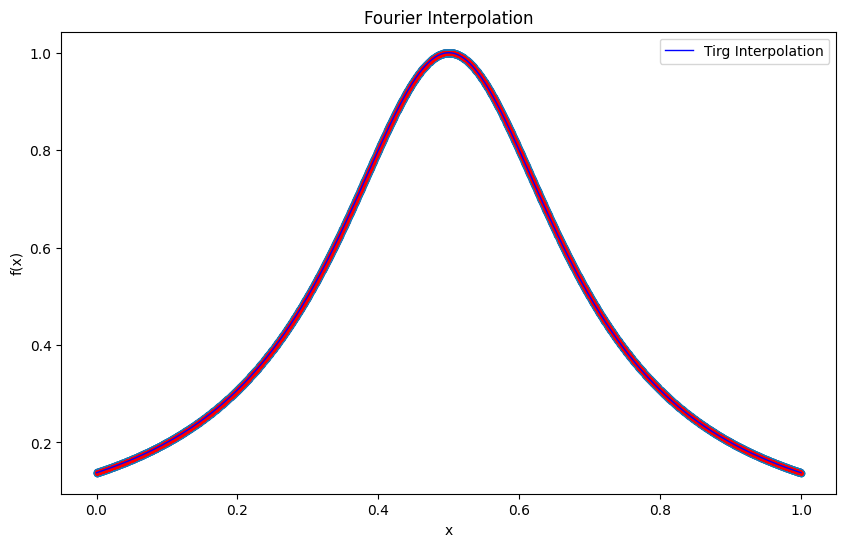

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, 16, 30, 60, 122, 131, 72, 43, 28, 20, 15, 8, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 81012 compression 0.618072509765625

error fourier  7.8e-07


In [150]:
# Fourieri interpolation
y0 = ftt
ext = dmps(0,nlc)
ye = tntt.kron(y0,ext)
op = (PO_qtt(nc+nlc) @ ye)
nop = op_reshape(op).round(1e-15)
#F(1)*L_qtt(2**(nc+nlc)-1,nc+nlc+1)
ftt_f = ((nop)@tdk ).round(1e-15)

d0e = (X_qtt(nc)).full().reshape(-1)
y_f = ftt_f.full().reshape(-1)
#plt.figure(figsize=(12, 6))
#plt.plot(x, (L_qtt(2**(nc+nlc)-1,nc+nlc+1)@tdk).full().reshape(-1) )
#plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(d0e,y0.full().reshape(-1),s=20)
#plt.plot(x, (F(0)*L_qtt(0,nc+nlc+1)@tdk).full().reshape(-1) )
plt.scatter(d0,y,s=5,c='r')
plt.plot(x, y_f, 'b-', lw=1, label='Tirg Interpolation')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Fourier Interpolation')
plt.legend()
plt.show()

print(ftt_f)
error_f = (tn.linalg.norm(y_f-F(new_dom))/tn.linalg.norm(F(new_dom))).item()

print(f"\033[93merror fourier \033[0m {error_f:.1e}")


In [151]:
# Results
print('\033[91mscale\033[0m {:.1e}'.format(1/2**nc))
print('error \033[93mleft\033[0m      {:.1e}'.format(error_c))
print('error \033[93mcentral\033[0m   {:.1e}'.format(error_c1))
print('error \033[93mlinear\033[0m    {:.1e}'.format(error_linear))
print('error \033[93mquadratic\033[0m {:.1e}'.format(error_q))
print('error \033[93mcspline\033[0m   {:.1e}'.format(error_cspline))
print('error \033[93mkcspline\033[0m  {:.1e}'.format(error_kc))
print('error \033[38;5;208mfourier\033[0m   {:.1e}'.format(error_f))

print('======================================================')

print('\033[91minitial erank\033[0m   {:.2f}'.format(erank(ftt.R,ftt.N)))  
print('erank    \033[93mleft\033[0m   {:.2f}'.format(erank(f_interpolated0.R,f_interpolated0.N)))  
print('erank  \033[93mcentral\033[0m  {:.2f}'.format(erank(f_interpolated01.R,f_interpolated01.N)))
print('erank   \033[93mlinear\033[0m  {:.2f}'.format(erank(f_interpolated.R,f_interpolated.N))) 
print('erank \033[93mquadratic\033[0m {:.2f}'.format(erank(f_interpolated2.R,f_interpolated2.N)))
print('erank   \033[93mcspline\033[0m {:.2f}'.format(erank(f_cubicspline.R,f_cubicspline.N)))
print('erank  \033[93mkcspline\033[0m {:.2f}'.format(erank(f_interpolatedkc.R,f_interpolatedkc.N)))
print('erank \033[38;5;208mfourier\033[0m   {:.2f}'.format(erank(ftt_f.R,ftt_f.N)))

scale 2.4e-04
error left      4.9e-04
error central   2.5e-04
error linear    1.7e-07
error quadratic 2.8e-10
error cspline   1.9e-10
error kcspline  7.1e-11
error fourier   7.8e-07
initial erank   7.44
erank    left   6.14
erank  central  6.57
erank   linear  9.33
erank quadratic 11.02
erank   cspline 8.80
erank  kcspline 7.55
erank fourier   51.90


## Radial Basis Function Interpolation
Polyharmonic splines / Gaussian / Thin Plate



Now that we know how to perform a translation operator, we can define a radial funciton between $[-1,1]$ and then translate it to a point $x_k \in [0,1]$ such that

$$y = \sum_k w_k \phi(|x-x_k|) = \sum_k w_k \hat{O}_k \circ \phi(|x|)  = \left( \sum_k w_k \hat{O}_k \right) \circ \phi(|x|)$$
$$ y = \hat O \circ \phi(|x|)$$

First we need to solve the system of equations. For that we use TT cross to approximate the radial function, then we create the circulant matrix and solve the system with AMEN. once we have the solution in TT format, we use the same methodology as in Fourier interpolation....

### Example: Thin Plate Radial Basis

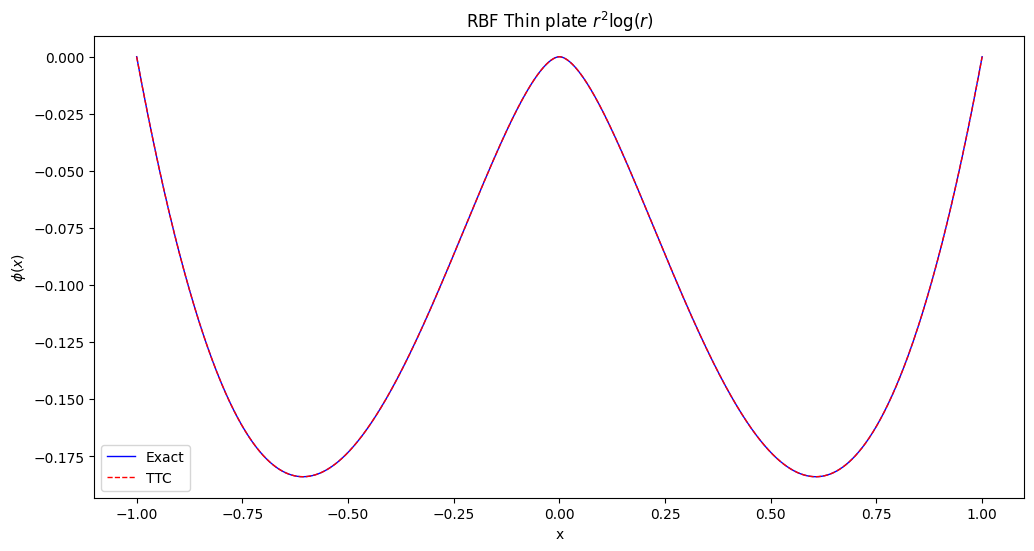

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, 13, 13, 13, 12, 12, 11, 11, 10, 9, 9, 8, 7, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 2968 compression 0.011322021484375

error 1.1710336199671565e-14


In [152]:
#check RBF
c = nc
td = nc+nlc
dom = (2*X_qtt(td+1)-1).round(1e-15)
N = 2**c 
xe = dom.full().reshape(-1)
r = xe.abs()
RF = r**2 * tn.log(r)
RF[tn.isclose(r, tn.tensor(0., dtype=x.dtype))] = 0

def rk(x,N=N):
    r = x.abs()
    return tn.where( tn.isclose(r, tn.tensor(0., dtype=x.dtype)), 0, r**2 * tn.log(r))
  

rdk = tntt.interpolate.function_interpolate(rk, dom,nswp=13, eps=1e-14,kick=1).round(1e-15)
rktt = rdk.full().reshape(-1)


plt.figure(figsize=(12, 6))
plt.plot(xe, rktt, 'b-', lw=1, label='Exact')
plt.plot(xe, RF, 'r--', lw=1, label='TTC')
plt.xlabel('x')
plt.ylabel('$\phi(x)$')
plt.title('RBF Thin plate $r^2 \log(r)$')
plt.legend()
plt.show()

print(rdk)
error = tn.linalg.norm(rktt-RF)/tn.linalg.norm(RF)
print('error',error.item())

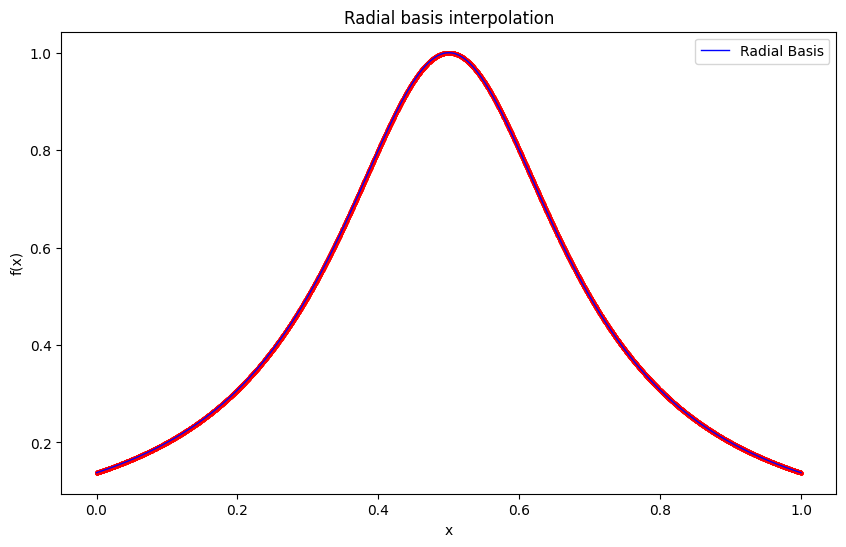

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, 16, 30, 60, 122, 131, 72, 43, 28, 20, 15, 8, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 81012 compression 0.618072509765625

error RBS  7.1e-08


In [153]:
# Radial Basis Interpolation
y0 = ftt

#solve system of equations
e0 = tntt.TT(tn.tensor([1,0],dtype=tn.float64))
e1 = tntt.TT(tn.tensor([0,1],dtype=tn.float64))
R_vals = tntt.interpolate.function_interpolate(rk, X_qtt(nc),nswp=30, eps=1e-13,kick=1).round(1e-15)
gen_vec = tntt.kron(e0,(L_qtt(1,nc) @ iO_qtt(nc))@R_vals) + tntt.kron(e1,R_vals)
gen_vec = gen_vec.round(1e-15)
rOp = SO_qtt(nc) @ gen_vec
rOp = tntt.reshape(rOp,[4]*nc)
rOp = op_reshape(rOp).round(1e-15)

coefs = tntt.solvers.amen_solve(rOp,y0, nswp=30, eps=1e-14, kickrank=1).round(1e-15)

ext = dmps(0,nlc)
ye = tntt.kron( tntt.TT(tn.tensor([1,0],dtype=tn.float64)) , tntt.kron(coefs,ext) )
op = (LO_qtt(nc+nlc+1) @ ye)
nop = op_reshape(op).round(1e-15)
#F(1)*L_qtt(2**(nc+nlc)-1,nc+nlc+1)
ftt_r = ((nop)@rdk ).round(1e-15)
ftt_r = reduceg(ftt_r,1,0).round(1e-14)

d0e = (X_qtt(nc)).full().reshape(-1)
y_r = ftt_r.full().reshape(-1)
#plt.figure(figsize=(12, 6))
#plt.plot(x, (L_qtt(2**(nc+nlc)-1,nc+nlc+1)@tdk).full().reshape(-1) )
#plt.show()

plt.figure(figsize=(10, 6))
#plt.plot(x, (F(0)*L_qtt(0,nc+nlc+1)@tdk).full().reshape(-1) )
plt.scatter(d0,y,s=5,c='r')
plt.plot(x, y_r, 'b-', lw=1, label='Radial Basis')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Radial basis interpolation')
plt.legend()
plt.show()

print(ftt_f)
error_r = (tn.linalg.norm(y_r-F(new_dom))/tn.linalg.norm(F(new_dom))).item()

print(f"\033[93merror RBS \033[0m {error_r:.1e}")


### Results updated

In [154]:
# Results
print('\033[91mscale\033[0m {:.1e}'.format(1/2**nc))
print('error \033[93mleft\033[0m      {:.1e}'.format(error_c))
print('error \033[93mcentral\033[0m   {:.1e}'.format(error_c1))
print('error \033[93mlinear\033[0m    {:.1e}'.format(error_linear))
print('error \033[93mquadratic\033[0m {:.1e}'.format(error_q))
print('error \033[93mcspline\033[0m   {:.1e}'.format(error_cspline))
print('error \033[93mkcspline\033[0m  {:.1e}'.format(error_kc))
print('error \033[38;5;208mfourier\033[0m   {:.1e}'.format(error_f))
print('error \033[38;5;208mRBF TP \033[0m   {:.1e}'.format(error_r))

print('======================================================')

print('\033[91minitial erank\033[0m   {:.2f}'.format(erank(ftt.R,ftt.N)))  
print('erank    \033[93mleft\033[0m   {:.2f}'.format(erank(f_interpolated0.R,f_interpolated0.N)))  
print('erank  \033[93mcentral\033[0m  {:.2f}'.format(erank(f_interpolated01.R,f_interpolated01.N)))
print('erank   \033[93mlinear\033[0m  {:.2f}'.format(erank(f_interpolated.R,f_interpolated.N))) 
print('erank \033[93mquadratic\033[0m {:.2f}'.format(erank(f_interpolated2.R,f_interpolated2.N)))
print('erank   \033[93mcspline\033[0m {:.2f}'.format(erank(f_cubicspline.R,f_cubicspline.N)))
print('erank  \033[93mkcspline\033[0m {:.2f}'.format(erank(f_interpolatedkc.R,f_interpolatedkc.N)))
print('erank \033[38;5;208mfourier\033[0m   {:.2f}'.format(erank(ftt_f.R,ftt_f.N)))
print('erank \033[38;5;208mRBF TP\033[0m    {:.2f}'.format(erank(ftt_r.R,ftt_r.N)))

scale 2.4e-04
error left      4.9e-04
error central   2.5e-04
error linear    1.7e-07
error quadratic 2.8e-10
error cspline   1.9e-10
error kcspline  7.1e-11
error fourier   7.8e-07
error RBF TP    7.1e-08
initial erank   7.44
erank    left   6.14
erank  central  6.57
erank   linear  9.33
erank quadratic 11.02
erank   cspline 8.80
erank  kcspline 7.55
erank fourier   51.90
erank RBF TP    12.13


# 2D MPS/Tensor trees Interpolation


## Comb Encoding

### Geometry

In [15]:
#degree of smoothness
factor = 10

In [16]:
#geometry functions
R=0.08
def Fcircle(x,y,c = (0.5,0.5),r=R):

    #return tn.where( (md[:,0] - c[0])**2 + (md[:,1] - c[1])**2 < r**2, 1, -1 )
    q = tn.tensor((x - c[0])**2 + (y - c[1])**2 - r**2)
    return tn.exp(-factor*(q+tn.abs(q)))

def circle(md,c = (0.5,0.5),r=R):

    #return tn.where( (md[:,0] - c[0])**2 + (md[:,1] - c[1])**2 < r**2, 1, -1 )
    q = (md[:,0] - c[0])**2 + (md[:,1] - c[1])**2 - r**2
    return tn.exp(-factor*(q+tn.abs(q)))

def tncircle(md,c = (0.5,0.5),r=R):

    #return tn.where( (md[0] - c[0])**2 + (md[1] - c[1])**2 < r**2, 1, 0 )
    q = (md[0] - c[0])**2 + (md[1] - c[1])**2 - r**2
    return tn.exp(-factor*(q+tn.abs(q)))

def tncircleb(md,b,type, c = (0.5,0.5),r=R):

    #return tn.where( (md[0] - c[0])**2 + (md[1] - c[1])**2 < r**2, 1, 0 )
    if type =='x':
        q = (md - c[0])**2 + (b - c[1])**2 - r**2
        return tn.exp(-factor*(2*q))

    elif type =='y':
        q = (b - c[0])**2 + (md - c[1])**2 - r**2
        return tn.exp(-factor*(2*q))

def pd_circle_b(md,b,type,c = (0.5,0.5),r=R):

    if type =='x':
        q = (b - c[0])**2 + (md - c[1])**2 - r**2
        return tn.exp(-factor*(2*q))*(-4*factor)*(b - c[0])

    elif type =='y':
        q = (md - c[0])**2 + (b - c[1])**2 - r**2
        return tn.exp(-factor*(2*q))*(-4*factor)*(b - c[1])
    
    elif type =='yx':
        q = (b - c[0])**2 + (md - c[1])**2 - r**2
        return tn.exp(-factor*(2*q))*(-4*factor)*(md - c[1])
    elif type =='xy':
        q = (md - c[0])**2 + (b - c[1])**2 - r**2
        return tn.exp(-factor*(2*q))*(-4*factor)*(md - c[0])

    
def Dcircle(x,y, type,c = (0.5,0.5),r=R):

    #return tn.where( (md[:,0] - c[0])**2 + (md[:,1] - c[1])**2 < r**2, 1, -1 )
    q = tn.tensor((x - c[0])**2 + (y - c[1])**2 - r**2)
    if type == 'x':
        return tn.exp(-factor*(2*q))*(-4*factor)*(x - c[0])
    elif type == 'y':
        return tn.exp(-factor*(2*q))*(-4*factor)*(y - c[1])
    elif type == 'xy':
        return tn.exp(-factor*(2*q))*(4*factor)*(x - c[0])*(4*factor)*(y - c[1])

def tncircleR(md,c = (0.5,0.5),r=R):

    def f(x): 
        return c[1] - tn.sqrt(-(c[0]-md[0])**2+r**2)
    return tn.where( tn.abs(md[0] - c[0]) < r, tn.where(md[1]<f(md[0]),1,-1), -1 )
    #return tn.where( (md[0] - c[0])**2 + (md[1] - c[1])**2 < r**2, tn.exp( -1000*( (md[0] - c[0])**2 + (md[1] - c[1])**2) ), 1 )
    #anulus
    #return tn.where( ((md[0] - c[0])**2 + (md[1] - c[1])**2 < r**2) , tn.where(0.1**2< (md[0] - c[0])**2 + (md[1] - c[1])**2,1,0) , 0 )

def tnsphere(md,c = (0.5,0.5,0.5),r=R):

    return tn.where( (md[0] - c[0])**2 + (md[1] - c[1])**2 + (md[2] - c[2])**2 < r**2, 1, 0 )
    q = (md[0] - c[0])**2 + (md[1] - c[1])**2 - r**2
    return tn.exp(-100*(q+tn.abs(q)))

### Initial MPS

In [17]:
# Define coarse scale 2**p
p = 10

In [18]:
# Define an extended scale
nlc = 2
ncl=2

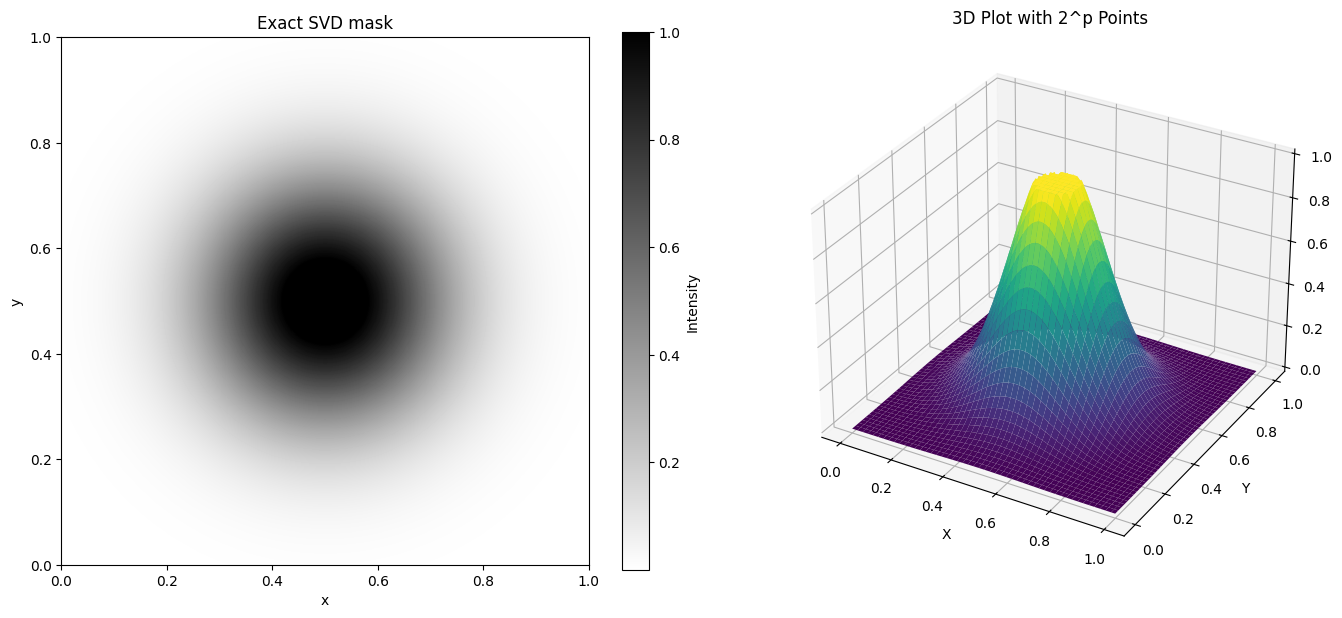

mask svd TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, 16, 32, 64, 76, 103, 101, 51, 101, 103, 76, 64, 32, 16, 8, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 123904 compression 0.1181640625



In [19]:
# Build a exact TT coarse representation
n = 2**p
N = [2**p,2**p]
ones = tntt.ones([2]*p)
unif = X_qtt(p)
perm = bit_reverse_indices(p)
#reverse X
X = tntt.kron( unif,ones)
XR = tntt.kron( reversett(unif),ones)
Y = tntt.kron(ones,unif)
#Xz = zkron(unif,ones)
#Yz = zkron(ones,unif)

#md = [X.full(), Y.full()]
#mdz = [Xz.full(), Yz.full()]
mdr = [XR.full(), Y.full()]
#fm = lambda x: 3*x[:,1]
#fr = lambda x: 3*x[1]
#Ff =  lambda x,y: 3*y

fm = Fcircle
fr = tncircle
Ff  =  Fcircle

#fm = lambda x: tn.ones_like(x[:,0])
#fr = lambda x: tn.ones_like(x[0])
#Ff = lambda x,y: tn.tensor(1)


mask = tntt.TT( tn.tensor(fr(mdr),dtype=tn.float64), [2]*p*2,eps=1e-14).round(1e-14)

#mask = tntt.interpolate.function_interpolate(fm, [XR,Y],nswp=30, eps=1e-15,kick=5)
#mask = (mask).round(1e-15) 
#print('mask ttcross',mask)

order = bit_reverse_indices(p)
unfolded = mask.full().reshape(N)[order,:]
#unfolded = unfolded.round(decimals=10)

# Create the figure and subplots
fig = plt.figure(figsize=(14, 6))  # Adjust figure size

# ---- First subplot (2D heatmap) ----
ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, position 1
im = ax1.imshow(unfolded, cmap='binary', interpolation='none', extent=[0, 1, 0, 1])
ax1.set_title('Exact SVD mask')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Add colorbar (linked to the heatmap)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Intensity")

# ---- Second subplot (3D surface plot) ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # 3D plot on the right
ax2.plot_surface(X.full().reshape(2**p, 2**p), Y.full().reshape(2**p, 2**p), unfolded, cmap='viridis')

# Set labels and title for 3D plot
ax2.set_title("3D Plot with 2^p Points")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Show the final combined figure
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

print('mask svd',mask)



### 0-th order (left approximant)

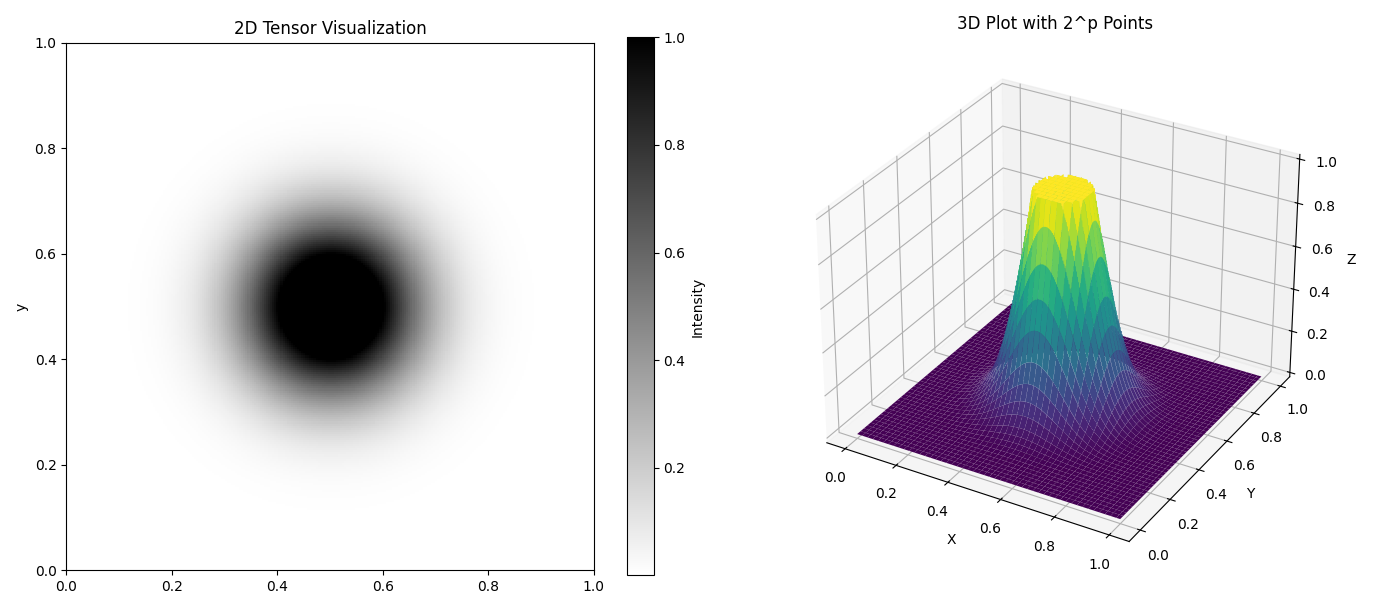

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 1, 1, 2, 4, 8, 16, 32, 36, 34, 17, 34, 36, 32, 16, 8, 4, 2, 1, 1, 1]

Device: cpu, dtype: torch.float64
#entries 14552 compression 0.01387786865234375

error  1.6e-02


In [473]:
# zero order interpolation
ncl = nlc
NC = [2**(p+ncl)]*2
norder = bit_reverse_indices(p+ncl)
onesi = tntt.ones([2]*ncl)
mask0 = tntt.kron(tntt.kron( onesi,mask),onesi ).round(1e-10)

onesn = tntt.ones([2]*(ncl+p))
unifn = X_qtt(p+ncl)
#reverse X
Xn = tntt.kron( unifn,onesn)
Yn = tntt.kron( onesn,unifn)
mdc =  [Xn.full().reshape(NC), Yn.full().reshape(NC)]
rF = tn.tensor(fr(mdc),dtype=tn.float64)

unfolded = mask0.full().reshape(NC)[norder,:]


# Create the figure and subplots
fig = plt.figure(figsize=(14, 6))  # Adjust figure size

# ---- First subplot (2D heatmap) ----
ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, position 1
im =ax1.imshow(unfolded, cmap='binary', interpolation='none',extent=[0, 1, 0, 1])
ax1.set_title('2D Tensor Visualization')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
# Add colorbar (linked to the heatmap)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Intensity")


# ---- Second subplot (3D surface plot) ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # 3D plot on the right
ax2.plot_surface(Xn.full().reshape(2**(p+ncl), 2**(p+ncl)), Yn.full().reshape(2**(p+ncl), 2**(p+ncl)), unfolded, cmap='viridis')

# Set labels and title for 3D plot
ax2.set_title("3D Plot with 2^p Points")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Show the final combined figure
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()



error0 = (unfolded-rF).norm()/(rF).norm()
print(mask0)
print(f"\033[93merror \033[0m {error0.item():.1e}")

### 0.5-th order Nearest Neighbours


Again we can improve a little bit our approximation by approximating by nearest neighbours

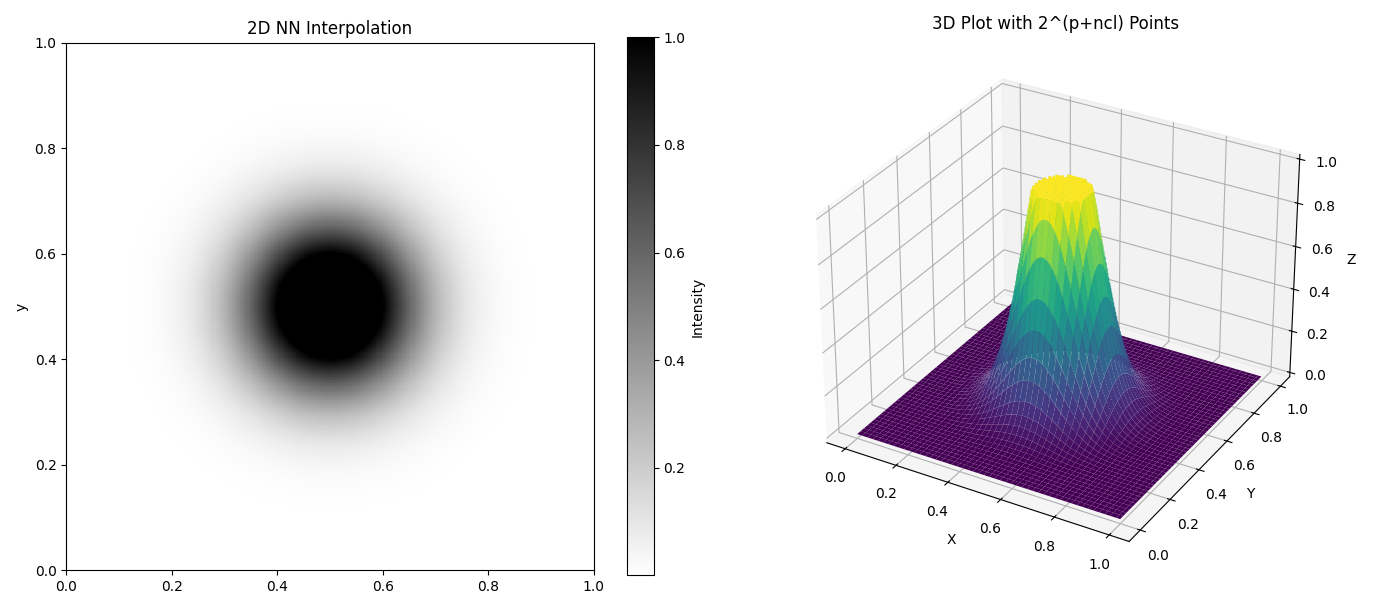

TT with sizes and ranks:
N = [2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2]
R = [1, 2, 2, 4, 4, 8, 16, 32, 62, 121, 225, 128, 69, 106, 59, 34, 18, 10, 6, 4, 2, 2, 1, 1, 1]

Device: cpu, dtype: torch.float64
#entries 182997 compression 0.17451953887939453

error  1.1e-02


In [474]:
# Nearest neighbours approximant
phi1 = hs(nlc,'1')
phi2 = hs(nlc,'2')
sm = R_qtt( 2**p -1, p)
smr = reversemtt(sm)
id = I_qtt(p)
smy = tntt.kron(  id , sm)
smx = tntt.kron(reversemtt(sm),id)
smxy = tntt.kron(reversemtt(sm),sm)

delta = dmps(2**p -1,p)
rdelta = reversett(delta)


by = tntt.TT( tn.tensor(fr([ reversett(unif).full().flatten(), tn.ones(2**p)]),dtype=tn.float64), [2]*p)
bx = tntt.TT( tn.tensor(fr([ tn.ones(2**p), unif.full().flatten()]),dtype=tn.float64), [2]*p)

mask05 = tntt.kron(tntt.kron( reversett(phi1),mask),phi1 ) + tntt.kron(tntt.kron( reversett(phi1), smy@mask  + tntt.kron(by,delta)  ),phi2 ) 
mask05 += tntt.kron(tntt.kron( reversett(phi2),smx@mask + tntt.kron(rdelta,bx) ),phi1 ) + tntt.kron(tntt.kron( reversett(phi2),smxy@mask + tntt.kron(smr@by,delta) + tntt.kron(rdelta,sm@bx)  + tntt.kron(rdelta,delta)*Ff(1,1) ),phi2 )
mask05 = mask05.round(1e-15)

unfolded05 = mask05.full().reshape([2**(p+ncl)]*2)[norder,:]


# Create a single figure with two subplots
fig = plt.figure(figsize=(14, 6))  # Adjust the figure size

# ---- First subplot: 2D Heatmap ----
ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
im = ax1.imshow(unfolded05, cmap='binary', interpolation='none', extent=[0, 1, 0, 1])
ax1.set_title('2D NN Interpolation')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Add colorbar to the heatmap
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Intensity")

# ---- Second subplot: 3D Surface Plot ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # 3D plot on the right
ax2.plot_surface(
    Xn.full().reshape(2**(p+ncl), 2**(p+ncl)), 
    Yn.full().reshape(2**(p+ncl), 2**(p+ncl)), 
    unfolded05, 
    cmap='viridis'
)

# Set labels and title for 3D plot
ax2.set_title("3D Plot with 2^(p+ncl) Points")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Show the final combined figure
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


error05 = (unfolded05-rF).norm()/(rF).norm()
print(mask05)
print(f"\033[93merror \033[0m {error05.item():.1e}")

### 2D Linear interpolation

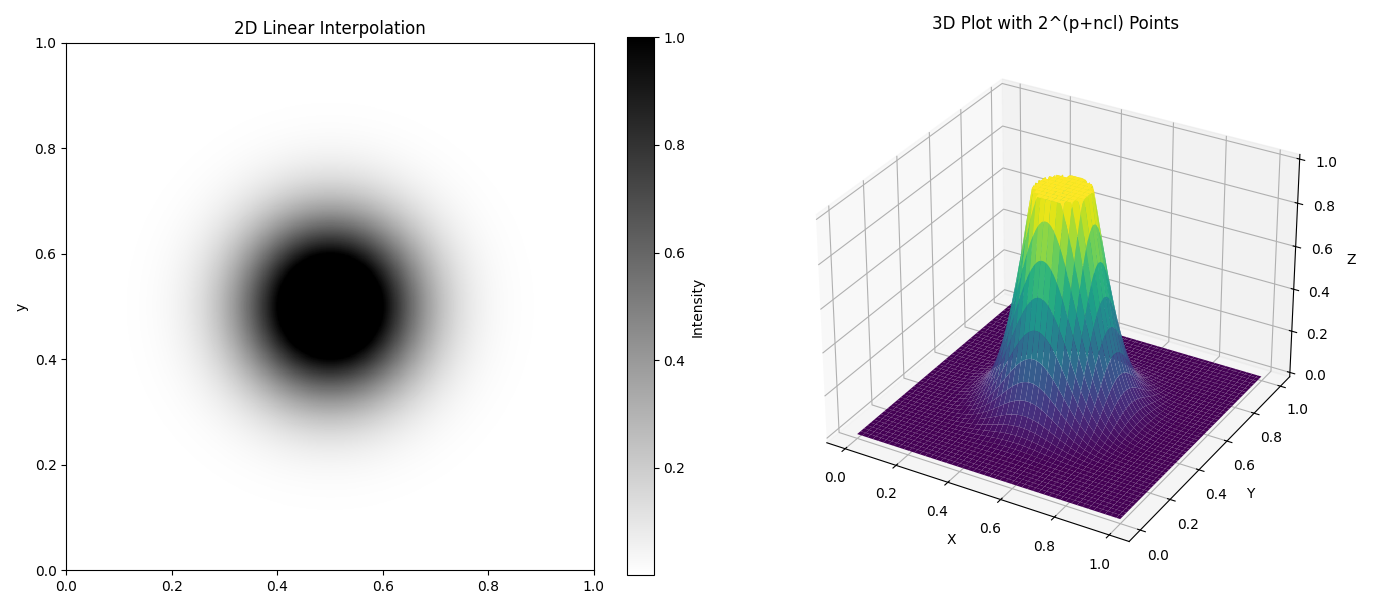

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 2, 3, 5, 9, 17, 32, 36, 34, 17, 34, 36, 32, 17, 9, 5, 3, 2, 2, 1]

Device: cpu, dtype: torch.float64
#entries 14892 compression 0.014202117919921875

error  6.1e-04


In [475]:
# Linear order mps interpolation
phi1 = tntt.TT(qtt_polynomial_cores([1,-1], ncl))
phi2 = tntt.TT(qtt_polynomial_cores([0,1], ncl))
sm = R_qtt( 2**p -1, p)
smr = reversemtt(sm)
id = I_qtt(p)
smy = tntt.kron(  id , sm)
smx = tntt.kron(reversemtt(sm),id)
smxy = tntt.kron(reversemtt(sm),sm)

delta = dmps(2**p -1,p)
rdelta = reversett(delta)


by = tntt.TT( tn.tensor(fr([ reversett(unif).full().flatten(), tn.ones(2**p)]),dtype=tn.float64), [2]*p)
bx = tntt.TT( tn.tensor(fr([ tn.ones(2**p), unif.full().flatten()]),dtype=tn.float64), [2]*p)

mask1 = tntt.kron(tntt.kron( reversett(phi1),mask),phi1 ) + tntt.kron(tntt.kron( reversett(phi1), smy@mask  + tntt.kron(by,delta)  ),phi2 ) 
mask1 += tntt.kron(tntt.kron( reversett(phi2),smx@mask + tntt.kron(rdelta,bx) ),phi1 ) + tntt.kron(tntt.kron( reversett(phi2),smxy@mask + tntt.kron(smr@by,delta) + tntt.kron(rdelta,sm@bx) + tntt.kron(rdelta,delta)*Ff(1,1) ),phi2 )
mask1 = mask1.round(1e-10)

unfolded1 = mask1.full().reshape([2**(p+ncl)]*2)[norder,:]

# Create a single figure with two subplots
fig = plt.figure(figsize=(14, 6))  # Adjust the figure size

# ---- First subplot: 2D Heatmap ----
ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
im = ax1.imshow(unfolded1, cmap='binary', interpolation='none', extent=[0, 1, 0, 1])
ax1.set_title('2D Linear Interpolation')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Add colorbar to the heatmap
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Intensity")

# ---- Second subplot: 3D Surface Plot ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # 3D plot on the right
ax2.plot_surface(
    Xn.full().reshape(2**(p+ncl), 2**(p+ncl)), 
    Yn.full().reshape(2**(p+ncl), 2**(p+ncl)), 
    unfolded1, 
    cmap='viridis'
)

# Set labels and title for 3D plot
ax2.set_title("3D Plot with 2^(p+ncl) Points")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Show the final combined figure
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


error1 = (unfolded1-rF).norm()/(rF).norm()
print(mask1)
print(f"\033[93merror \033[0m {error1.item():.1e}")

### Quadratic interpolation

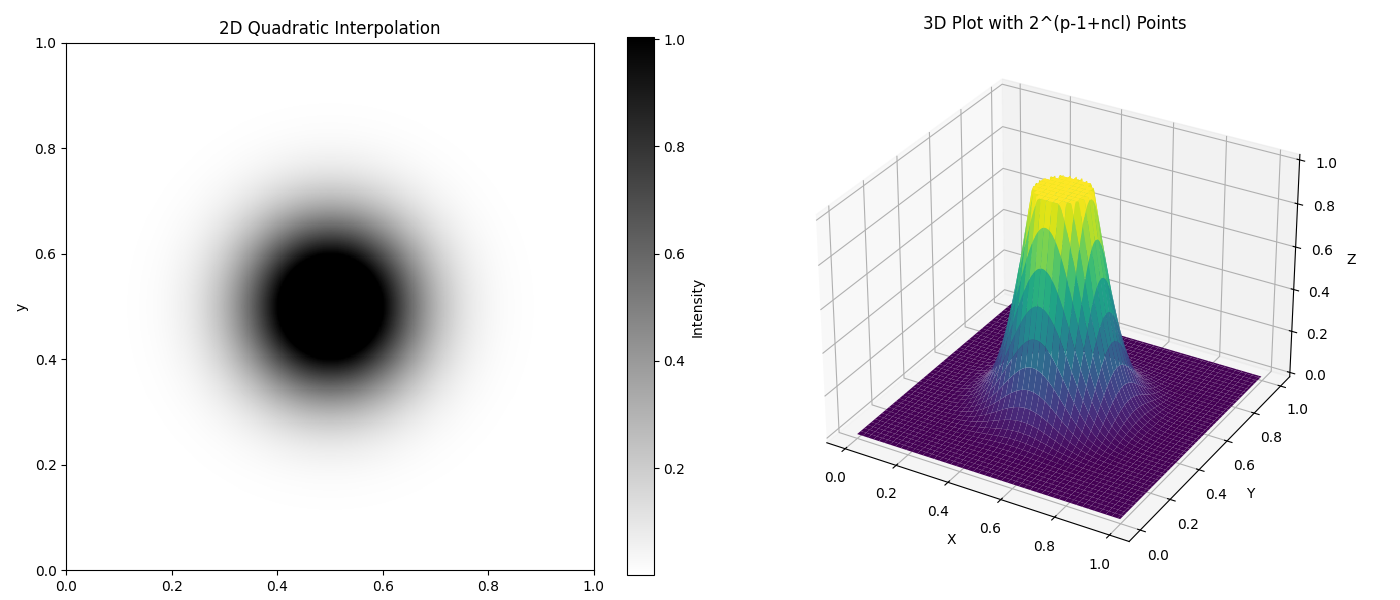

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 3, 5, 9, 17, 33, 36, 34, 17, 34, 36, 33, 17, 9, 5, 3, 2, 1]

Device: cpu, dtype: torch.float64
#entries 15088 compression 0.05755615234375

error  4.8e-04


In [476]:
# Quadratic 2d mps interpolation

phi1 = tntt.TT(qtt_polynomial_cores([1,-3,2], ncl))
phi2 = tntt.TT(qtt_polynomial_cores([0,4,-4], ncl))
phi3 = tntt.TT(qtt_polynomial_cores([0,-1,2], ncl))


fttr00 = reduceg(reduceg(mask,0,0),0,-1)
fttr10 = reduceg(reduceg(mask,1,0),0,-1)
fttr01 = reduceg(reduceg(mask,0,0),1,-1)
fttr11 = reduceg(reduceg(mask,1,0),1,-1)
by = tntt.TT( tn.tensor(fr([ unif.full().flatten(), tn.ones(2**(p))]),dtype=tn.float64), [2]*(p),eps=1e-15)
bx = tntt.TT( tn.tensor(fr([ tn.ones(2**(p)), unif.full().flatten()]),dtype=tn.float64), [2]*(p),eps=1e-15)
by0 = reversett(reduceg(by,0,-1))
by1 = reversett(reduceg(by,1,-1))
bx0 = reduceg(bx,0,-1)
bx1 = reduceg(bx,1,-1)

# define shift matrix
delta = dmps(2**(p-1) -1,p-1)
rdelta = reversett(delta)
sm = R_qtt( 2**(p-1) -1, p-1)
id = I_qtt(p-1)
idr = reversemtt(id)
smy = tntt.kron(  idr , sm)
smx = tntt.kron(reversemtt(sm),id)
smxy = tntt.kron(reversemtt(sm),sm)
unif0 = X_qtt(p-1)

'''# Extend to 9 domains
Clean the code for later
fttr20 = smx@fttr00 + tntt.kron(rdelta,bx0)
fttr21 = smx@fttr01 + tntt.kron(rdelta,bx1)
'''

mask2 = tntt.kron(tntt.kron( reversett(phi1),fttr00),phi1 ) + tntt.kron(tntt.kron( reversett(phi2),fttr10),phi1 ) + tntt.kron(tntt.kron( reversett(phi1),fttr01),phi2 ) + tntt.kron(tntt.kron( reversett(phi2),fttr11),phi2 )
mask2 += tntt.kron(tntt.kron( reversett(phi1), smy@fttr00  + tntt.kron(by0,delta)  ),phi3 ) + tntt.kron(tntt.kron( reversett(phi3),smx@fttr00 + tntt.kron(rdelta,bx0) ),phi1 ) 
mask2 += tntt.kron(tntt.kron( reversett(phi2), smy@fttr10  + tntt.kron(by1,delta)  ),phi3 ) + tntt.kron(tntt.kron( reversett(phi3),smx@fttr01 + tntt.kron(rdelta,bx1) ),phi2 ) 
mask2 += tntt.kron(tntt.kron( reversett(phi3), smxy@fttr00  + smx@tntt.kron(by0,delta) + smy@tntt.kron(rdelta,bx0) + Ff(1,1)*tntt.kron(rdelta,delta) ),phi3 )
mask2 = mask2.round(1e-14)


norderr = bit_reverse_indices(p-1+ncl)
unfolded2 = mask2.full().reshape([2**(p-1+ncl)]*2)[norderr,:]
NC2 = [2]*(ncl+p-1)
onesn = tntt.ones(NC2)
unifn = X_qtt(p+ncl-1)
#reverse X
Xn = tntt.kron( unifn,onesn)
Yn = tntt.kron( onesn,unifn)
mdc =  [Xn.full(), Yn.full()]

# Create a single figure with two subplots
fig = plt.figure(figsize=(14, 6))  # Adjust the figure size

# ---- First subplot: 2D Heatmap ----
ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
im = ax1.imshow(unfolded2, cmap='binary', interpolation='none', extent=[0, 1, 0, 1])
ax1.set_title('2D Quadratic Interpolation')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Add colorbar to the heatmap
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Intensity")

# ---- Second subplot: 3D Surface Plot ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # 3D plot on the right
ax2.plot_surface(
    Xn.full().reshape(2**(p-1+ncl), 2**(p-1+ncl)), 
    Yn.full().reshape(2**(p-1+ncl), 2**(p-1+ncl)), 
    unfolded2, 
    cmap='viridis'
)

# Set labels and title for 3D plot
ax2.set_title("3D Plot with 2^(p-1+ncl) Points")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Show the final combined figure
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

rF = tn.tensor(fr(mdc),dtype=tn.float64).reshape(2**(p-1+ncl),2**(p-1+ncl))
error2 = (unfolded2-rF).norm()/(rF).norm()
print(mask2)
print(f"\033[93merror \033[0m {error2.item():.1e}")

### BiCubic spline interpolation

#### Local approximation

<!-- Theory-->

The bicubic interpolation of a function f(x,y) is given by a polynomial of the form

$$
f(x,y) = \begin{bmatrix}1 & x & x^2 & x^3\end{bmatrix} A \begin{bmatrix}1 \\ y \\ y^2 \\ y^3\end{bmatrix},
$$

where the 4×4 coefficient matrix $ A=[a_{ij}] $ contains the unknowns that are determined by enforcing interpolation conditions (function values and derivatives) at the four grid corners. Typically, we assume that f, its partial derivatives $ f_x $, $ f_y $ and the mixed derivative $ f_{xy} $ are known at the points $(0,0)$, $(0,1)$, $(1,0)$ and $(1,1)$. Let us denote these 16 values via

$$
F = \begin{pmatrix}
f(0,0) & f(0,1) & f_y(0,0) & f_y(0,1)\\[1mm]
f(1,0) & f(1,1) & f_y(1,0) & f_y(1,1)\\[1mm]
f_x(0,0) & f_x(0,1) & f_{xy}(0,0) & f_{xy}(0,1)\\[1mm]
f_x(1,0) & f_x(1,1) & f_{xy}(1,0) & f_{xy}(1,1)
\end{pmatrix}.
$$

The problem of finding $A$ reduces to solving the matrix equation

$$
A = M^{-1} \, F \, N^{-1},
$$

where the matrices $ M $ and $ N $ are derived from the polynomial basis (and its derivatives) in the x‐ and y‑directions, respectively. A common choice is

$$
M = \begin{pmatrix}
1 & 0 & 0 & 0\\[0.5mm]
0 & 0 & 1 & 0\\[0.5mm]
-3 & 3 & -2 & -1\\[0.5mm]
2 & -2 & 1 & 1
\end{pmatrix}
\quad \text{and} \quad
N = \begin{pmatrix}
1 & 0 & -3 & 2\\[0.5mm]
0 & 0 & 3 & -2\\[0.5mm]
0 & 1 & -2 & 1\\[0.5mm]
0 & 0 & -1 & 1
\end{pmatrix}.
$$

Thus, once $ A $ is computed via

$$
A = M^{-1} F N^{-1},
$$

the interpolated value at any $(x,y) \in [0,1] \times [0,1]$ is obtained by

$$
f(x,y) = \begin{bmatrix}1 & x & x^2 & x^3\end{bmatrix} A \begin{bmatrix}1 \\ y \\ y^2 \\ y^3\end{bmatrix}.
$$

This matrix formulation explicitly shows how the function values and derivatives are combined to yield a smooth bicubic interpolant.

In [477]:
def apply_local_op(mps,index,local_op):
    cores = mps.cores

    cores[index] = tn.einsum( 'abc, bd -> adc',cores[index],local_op)

    return tntt.TT(cores)

Mbi = tn.tensor([
    [ 1.0,  0.0,  0.0,  0.0],
    [-3.0,  3.0,  0.0,  0.0],
    [ 3.0, -6.0,  3.0,  0.0],
    [-1.0,  3.0, -3.0,  1.0]
], dtype=tn.float64)
Mb = tn.tensor([
    [1.0,    0.0,    0.0,   0.0],
    [1.0,   1/3,     0.0,   0.0],
    [1.0,   2/3,    1/3,    0.0],
    [1.0,   1.0,    1.0,    1.0]
], dtype=tn.float64)

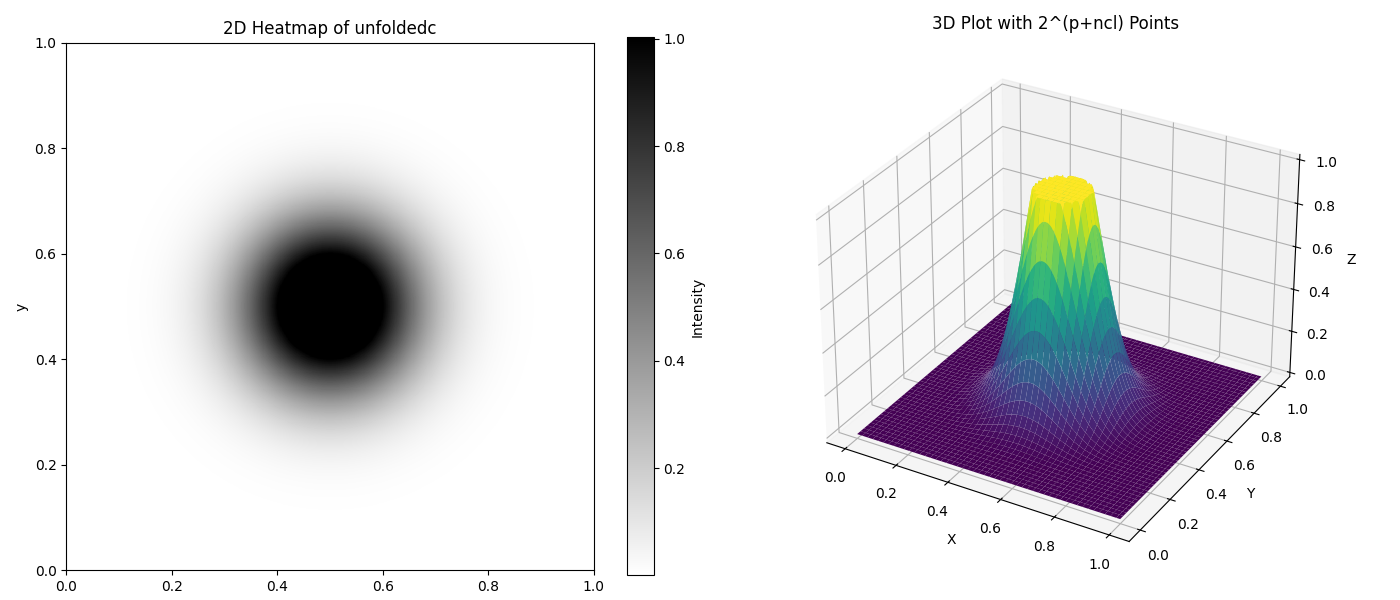

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, 16, 32, 62, 123, 244, 460, 256, 143, 80, 47, 29, 18, 11, 6, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 648590 compression 0.6185436248779297

error  4.14317e-04


In [478]:
#Generate approximation
M = tn.tensor([
    [1, 1, 0, 0],
    [0, 1, 1, 1],
    [0, 1, 0, 2],
    [0, 1, 0, 3]
], dtype=tn.float64)

Mi = M.inverse()

# Let's do the simplest case of pure interpolation without boundary conditions (we'll be missing two stripes, but it's ok since it's INTERPOLATION)
''' 
# for later work 
# boundary conditions
bfx = tntt.zeros([2]*p)
bfy = tntt.zeros([2]*p)
bdxfx = tntt.zeros([2]*p)
bdxfy = tntt.zeros([2]*p)
bdyfx = tntt.zeros([2]*p)
bdyfy = tntt.zeros([2]*p)
bdxyfx = tntt.zeros([2]*p)
bdxyfxy= tntt.zeros([2]*p)
'''

id = I_qtt(p)
delta = dmps(2**p -1,p)
rdelta = reversett(delta)
sm = R_qtt(2**(p)-1, p)
smx = tntt.kron(reversemtt(sm),id)
smy = tntt.kron(  reversemtt(id) , sm)
smxy = tntt.kron(reversemtt(sm),sm)
Dop = R_qtt( 2**p -1, p,dtype = tn.float64) - L_qtt( 1, p ,dtype = tn.float64) - 2*dmpo(0,0,p) + dmpo(0,1,p) +  2*dmpo(2**p -1,2**p -1,p) - dmpo(2**p -1,2**p -2,p)
Dop = (Dop/2).round(1e-15)
#Dop = R_qtt( 2**p -1, p,dtype = tn.float64) - id +  2*dmpo(2**p -1,2**p -1,p) - dmpo(2**p -1,2**p -2,p)
#Dop = (Dop).round(1e-15)
Dx = tntt.kron( reversemtt(Dop),id)
Dy = tntt.kron( reversemtt(id),Dop)
Dxy = tntt.kron( reversemtt(Dop),Dop)

#boundary conditions
by = tntt.TT( tn.tensor(fr([ reversett(unif).full().flatten(), tn.ones(2**p)]),dtype=tn.float64), [2]*p)
bx = tntt.TT( tn.tensor(fr([ tn.ones(2**p), unif.full().flatten()]),dtype=tn.float64), [2]*p)
#bx = tntt.zeros([2]*p)
#by = tntt.zeros([2]*p)
#Geneare f matrix
I4 = tn.eye(4,dtype=tn.float64)
t4 = [ tntt.TT(I4[i],[4]) for i in range(4)]
ftt = tntt.kron(t4[0], tntt.kron(mask,t4[0])) + tntt.kron(t4[0], tntt.kron(smy@mask + tntt.kron(by,delta),t4[1])) + tntt.kron(t4[1], tntt.kron(smx@mask + tntt.kron(rdelta,bx),t4[0])) + tntt.kron(t4[1], tntt.kron(smxy@mask + smx@tntt.kron(by,delta)+smy@tntt.kron(rdelta,bx) + Ff(1,1)*tntt.kron(rdelta,delta),t4[1]) )
ftt = ftt.round(1e-15)
dxmask = (Dx @ mask).round(1e-15)
dxftt = tntt.kron(t4[2], tntt.kron(dxmask,t4[0])) + tntt.kron(t4[2], tntt.kron(smy@dxmask,t4[1])) + tntt.kron(t4[3], tntt.kron(smx@dxmask,t4[0])) + tntt.kron(t4[3], tntt.kron(smxy@dxmask,t4[1]) )
dymask = (Dy @ mask).round(1e-15)
dyftt = tntt.kron(t4[0], tntt.kron(dymask,t4[2])) + tntt.kron(t4[0], tntt.kron(smy@dymask,t4[3])) + tntt.kron(t4[1], tntt.kron(smx@dymask,t4[2])) + tntt.kron(t4[1], tntt.kron(smxy@dymask,t4[3]) )
dxymask = (Dxy @ mask).round(1e-15)
dxyftt = tntt.kron(t4[2], tntt.kron(dxymask,t4[2])) + tntt.kron(t4[2], tntt.kron(smy@dxymask,t4[3])) + tntt.kron(t4[3], tntt.kron(smx@dxymask,t4[2])) + tntt.kron(t4[3], tntt.kron(smxy@dxymask,t4[3]) )

#Geneare f matrix

fmtt = ftt + dxftt + dyftt + dxyftt
fmtt = fmtt.round(1e-15)
#fmtt = apply_local_op(fmtt,-1,Mi)
#fmtt = apply_local_op(fmtt,0,Mi)
polsy = [tntt.kron( t4[i], tntt.TT(qtt_polynomial_cores(Mi[i], ncl)) ) for i in range(4)]
#polsx = [reversett(polsy[i]) for i in range(4)]
PY = sum(polsy).round(1e-15)
PX = reversett(PY).round(1e-15)

maskCS0 = connect(connect(PX,fmtt,pd=4),PY,pd=4).round(1e-15)

onesn = tntt.ones([2]*(ncl+p))
unifn = X_qtt(p+ncl)
#reverse X
Xn = tntt.kron( unifn,onesn)
Yn = tntt.kron( onesn,unifn)
mdc =  [Xn.full().reshape(NC), Yn.full().reshape(NC)]
rF = tn.tensor(fr(mdc),dtype=tn.float64)
unfoldedc = maskCS0.full().reshape([2**(p+ncl)]*2)[norder,:]

# Create a single figure with two subplots
fig = plt.figure(figsize=(14, 6))  # Adjust the figure size

# ---- First subplot: 2D Heatmap ----
ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
im = ax1.imshow(unfoldedc, cmap='binary', interpolation='none', extent=[0, 1, 0, 1])
ax1.set_title('2D Heatmap of unfoldedc')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Add colorbar to the heatmap
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Intensity")

# ---- Second subplot: 3D Surface Plot ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # 3D plot on the right
ax2.plot_surface(
    Xn.full().reshape(2**(p+ncl), 2**(p+ncl)), 
    Yn.full().reshape(2**(p+ncl), 2**(p+ncl)), 
    unfoldedc, 
    cmap='viridis'
)

# Set labels and title for 3D plot
ax2.set_title("3D Plot with 2^(p+ncl) Points")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Show the final combined figure
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

print(maskCS0)

errorcs0 = (unfoldedc-rF).norm()/(rF).norm()
print(f"\033[93merror \033[0m {errorcs0.item():.5e}")

#### Kernel (Covolution) spline ($C^1$ interpolation)

We are able to extend the 1D kernel method to 2D fixig the boundary conditions

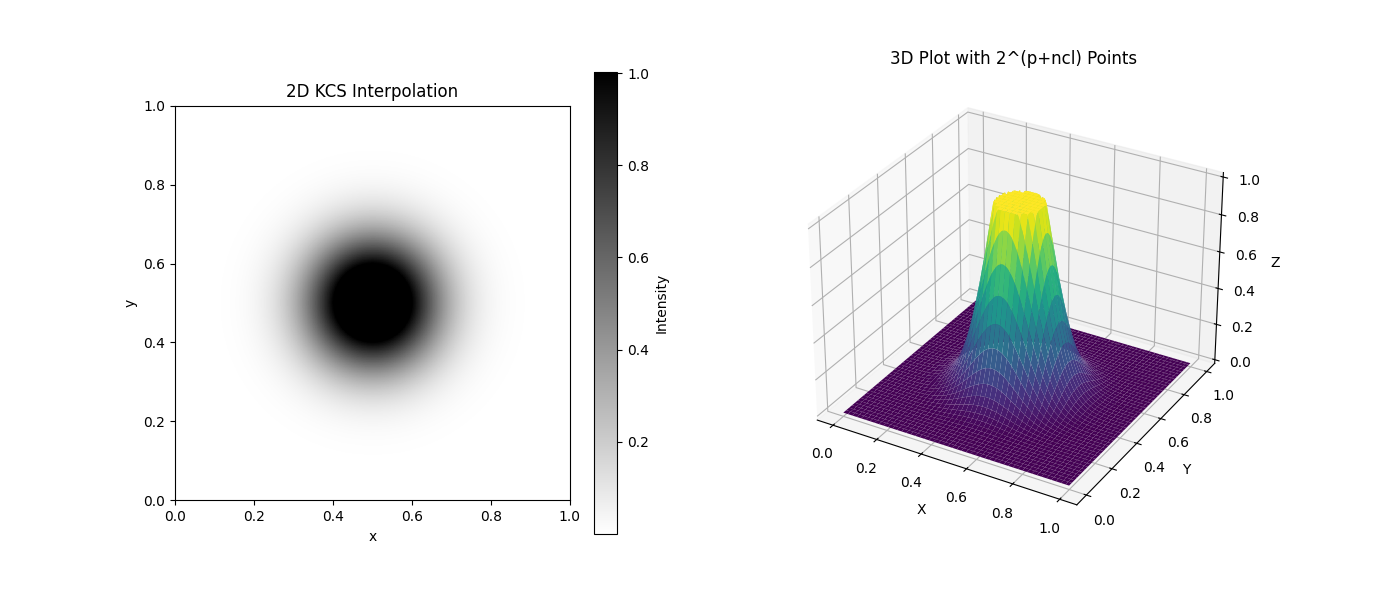

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, 16, 32, 62, 122, 241, 337, 176, 92, 57, 35, 20, 12, 8, 6, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 409420 compression 0.3904533386230469

error  4.14317e-04


In [479]:
# 2D cubic kernel interpolation
Mkc = tn.tensor([
    [0, 2, 0, 0],
    [-1, 0, 1, 0],
    [2, -5, 4, -1],
    [-1, 3, -3, 1]
], dtype=tn.float64) /2

Mkct = Mkc.t()
id = I_qtt(p)
idr = reversemtt(id)
sm1 = R_qtt( 2**p -1, p)
sm2 = R_qtt( 2**p -2, p)
smm1 = L_qtt( 1, p)

#reverse the operators for the first dimension
sm1x = reversemtt(sm1)
smm1x = reversemtt(smm1)
#boundary conditions
delta = dmps(2**p -1,p)
rdelta = reversett(delta)
by = tntt.TT( tn.tensor(fr([unif.full().flatten(), tn.ones(2**p)]),dtype=tn.float64), [2]*p,eps=1e-15)
#by = tntt.zeros([2]*p)
mby = tntt.kron(reversett(by),delta)
bx = tntt.TT( tn.tensor(fr([ tn.ones(2**p), unif.full().flatten()]),dtype=tn.float64), [2]*p,eps=1e-15)
#bx = tntt.zeros([2]*p) 
mbx = tntt.kron(rdelta,bx)
I4 = tn.eye(4,dtype=tn.float64)
t4 = [ tntt.TT(I4[i]) for i in range(4)]
corner = Ff(1,1)*tntt.kron(rdelta,delta)
# encode the mask piece by piece (4x4)
#let's start with the pieces without boundary conditions
maskck  = kron3(t4[1],mask,t4[1]) + kron3(t4[1],tntt.kron(idr,sm1)@mask + mby,t4[2]) + kron3(t4[2],tntt.kron(sm1x,id)@mask + mbx,t4[1]) + kron3(t4[2],tntt.kron(sm1x,sm1)@mask + tntt.kron(sm1x,id)@mby + tntt.kron(idr,sm1)@mbx + corner,t4[2])
#minus one operatos
Oym1 = smm1 + 3*dmpo(0,0,p) - 3*dmpo(0,1,p) + dmpo(0,2,p)
Oxm1 = reversemtt(Oym1)
maskck += kron3(t4[0],tntt.kron(Oxm1,Oym1)@mask,t4[0]) + kron3(t4[0],tntt.kron(Oxm1,id)@mask,t4[1]) + kron3(t4[0],tntt.kron(Oxm1,sm1)@mask+ tntt.kron(Oxm1,id)@mby,t4[2]) + kron3(t4[1],tntt.kron(idr,Oym1)@mask,t4[0]) + kron3(t4[2],tntt.kron(sm1x,Oym1)@mask+ tntt.kron(idr,Oym1)@mbx,t4[0])
#maskck = maskck.round(1e-10)
#plus two operators
Oy2 = sm2 - 3*dmpo(2**p-1,2**p-1,p) + dmpo(2**p-1,2**p-2,p)
Ox2 = reversemtt(Oy2)
delta2 = dmps(2**p -2,p) + 3*dmps(2**p -1,p)
rdelta2 = reversett(delta2)

mby2 = tntt.kron(reversett(by),delta2).round(1e-15)
mbx2 = tntt.kron( rdelta2, bx).round(1e-15)
cornery = Ff(1,1)*tntt.kron(rdelta,delta2)
cornerx = Ff(1,1)*tntt.kron(rdelta2,delta)


maskck += kron3(t4[3], tntt.kron(Ox2,Oym1)@mask + tntt.kron(idr,Oym1)@mbx2 ,t4[0] ) + kron3(t4[0], tntt.kron(Oxm1,Oy2)@mask + tntt.kron(Oxm1,id)@mby2 ,t4[3] ) + kron3(t4[3], tntt.kron(Ox2,id)@mask + mbx2 ,t4[1] ) + kron3(t4[1], tntt.kron(idr,Oy2)@mask + mby2 ,t4[3] )
maskck += kron3(t4[3], tntt.kron(Ox2,sm1)@mask + tntt.kron(idr,sm1)@ mbx2 + tntt.kron(Ox2,id)@mby + cornerx  ,t4[2] ) + kron3(t4[2], tntt.kron(sm1x,Oy2)@mask + (tntt.kron(idr,Oy2)@ mbx +cornery)+ (tntt.kron(sm1x,id)@mby2)  ,t4[3] )
maskck += kron3(t4[3], tntt.kron(Ox2,Oy2)@mask + tntt.kron(idr,Oy2)@ mbx2 + tntt.kron(Ox2,id)@mby2 + Ff(1,1)*tntt.kron(rdelta2,delta2)  ,t4[3] ) 
""" 
maskck = apply_local_op(maskck,-1,Mkct@Mb.t())
maskck = apply_local_op(maskck,0,Mkct@Mb.t())
polsy = [tntt.kron( t4[i], tntt.TT(qtt_polynomial_cores(Mbi.t()[i], ncl)) ) for i in range(4)]
polsx = [tntt.kron( tntt.TT(qtt_polynomial_cores(Mbi.t()[i], ncl, dir='b')), t4[i] ) for i in range(4)]
"""
maskck = maskck.round(1e-15)

polsy = [tntt.kron( t4[i], tntt.TT(qtt_polynomial_cores(Mkct[i], ncl)) ) for i in range(4)]
#polsx = [tntt.kron( tntt.TT(qtt_polynomial_cores(Mkct[i], ncl, dir='b')), t4[i] ) for i in range(4)]
polsx = [reversett(polsy[i]) for i in range(4)]
PY = sum(polsy)
PY = PY.round(1e-15)
PX = reversett(PY).round(1e-15)

maskKCS = connect(connect(PX,maskck,pd=4),PY,pd=4).round(1e-15)

onesn = tntt.ones([2]*(ncl+p))
unifn = X_qtt(p+ncl)
#reverse X
Xn = tntt.kron( unifn,onesn)
Yn = tntt.kron( onesn,unifn)
mdc =  [Xn.full().reshape(NC), Yn.full().reshape(NC)]
rF = tn.tensor(fr(mdc),dtype=tn.float64)
unfoldedc = maskKCS.full().reshape([2**(p+ncl)]*2)[norder,:]

# Create a single figure with two subplots
fig = plt.figure(figsize=(14, 6))  # Adjust the figure size

# ---- First subplot: 2D Heatmap ----
ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
im = ax1.imshow(unfoldedc, cmap='binary', interpolation='none', extent=[0, 1, 0, 1])
ax1.set_title('2D KCS Interpolation')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Add colorbar to the heatmap
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Intensity")

# ---- Second subplot: 3D Surface Plot ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # 3D plot on the right
ax2.plot_surface(
    Xn.full().reshape(2**(p+ncl), 2**(p+ncl)), 
    Yn.full().reshape(2**(p+ncl), 2**(p+ncl)), 
    unfoldedc, 
    cmap='viridis'
)

# Set labels and title for 3D plot
ax2.set_title("3D Plot with 2^(p+ncl) Points")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Show the final combined figure
plt.show()

errorkcs = (unfoldedc-rF).norm()/(rF).norm()
print(maskKCS)
print(f"\033[93merror \033[0m {errorkcs.item():.5e}")

#### Neumman BD exact cubic spline

<!-- Theory -->

**Cubic Spline Interpolation (Bicubic Case)**

Bicubic spline interpolation extends the concept of one-dimensional cubic splines to two dimensions. Suppose we have a grid of points 
$ (x_i, y_j) $ 
for 
$i = 0,1,\dots,I$ 
and 
$j = 0,1,\dots,J$, 
and a function 
$u(x,y)$ 
whose values (and possibly partial derivatives) are known at these grid points. The goal is to construct a *bicubic spline* 
$u(x,y)$ 
that matches these values and ensures sufficient smoothness across each rectangular subdomain.


A typical bicubic spline on each rectangular cell 
$[x_i, x_{i+1}] \times [y_j, y_{j+1}]$
can be written in the form
$u(x,y) = \sum_{m=0}^3 \sum_{n=0}^3 \alpha_{mn}\,(x - x_i)^m\,(y - y_j)^n,$
where the coefficients 
$\alpha_{mn}$ 
are determined by continuity and derivative-matching conditions at the grid points. These conditions usually involve:

- The function values 
$u(x_i,y_j)$.
- First partial derivatives 
$u_x(x_i,y_j)$ 
and 
$u_y(x_i,y_j)$.
- Mixed partial derivatives 
$u_{xy}(x_i,y_j)$.


**System of Equations**

Using the boundary conditions
$$
p_{ij} = u_x(x_i,y_j)
$$, 
$$
q_{ij} = u_y(x_i,y_j)
$$, 
$$
r_{ij} = u_{xy}(x_i,y_j)
$$,

The spline on each cell is *uniquely determined* by a set of linear constraints. Across the entire grid, the conditions for continuity of the spline and its first and second derivatives lead to the following complete system of equations.

For the partial derivative in the $x$-direction, at interior nodes ($i=1,2,\dots,I-1$ and $j=0,1,\dots,J$), the equations are
$$
\Delta x_{i-1}\,p_{i-1,j} + 2\bigl(\Delta x_{i-1}+\Delta x_i\bigr)\,p_{ij} + \Delta x_i\,p_{i+1,j} \;=\; 3\left(\frac{u_{i+1,j}-u_{ij}}{\Delta x_i} - \frac{u_{ij}-u_{i-1,j}}{\Delta x_{i-1}}\right),
$$
where $u_{ij}=u(x_i,y_j)$ and $\Delta x_i=x_{i+1}-x_i$.

Similarly, for the partial derivative in the $y$-direction, at interior nodes ($j=1,2,\dots,J-1$ and $i=0,1,\dots,I$), we have
$$
\Delta y_{j-1}\,q_{i,j-1} + 2\bigl(\Delta y_{j-1}+\Delta y_j\bigr)\,q_{ij} + \Delta y_j\,q_{i,j+1} \;=\; 3\left(\frac{u_{i,j+1}-u_{ij}}{\Delta y_j} - \frac{u_{ij}-u_{i,j-1}}{\Delta y_{j-1}}\right),
$$
with $\Delta y_j=y_{j+1}-y_j$.

For the mixed partial derivative $r_{ij}=u_{xy}(x_i,y_j)$, the continuity conditions across cell boundaries yield a system that couples the values at adjacent grid points. A typical equation for the mixed derivative is of the form
$$
\Delta x_i\,\Delta y_j\,r_{i+1,j+1} + A_{ij}\,r_{i+1,j} + B_{ij}\,r_{i,j+1} + C_{ij}\,r_{ij} \;=\; D_{ij},
$$
where the coefficients $A_{ij}$, $B_{ij}$, $C_{ij}$, and the right-hand side $D_{ij}$ are determined from the differences of the known function values $u_{ij}$ and ensure the continuity of the cross derivative across the grid.

In summary, the complete system couples all unknowns $p_{ij}$, $q_{ij}$, and $r_{ij}$ over the grid. Thanks to the banded (or block-banded) structure of these equations, the overall system can be solved in time that grows linearly or near-linearly with the total number of grid points $N=IJ$—typically $\mathcal{O}(N)$ or $\mathcal{O}(N \log N)$—which is much more efficient than a naive dense solver.



In [480]:
# 2D exact cspline mps implementation

# Boundary conditions
unif = X_qtt(p)
runif = reversett(unif)

mdr = [XR.full(), Y.full()]

H = 2**p
P0 = tntt.TT( tn.tensor(pd_circle_b(unif.full(),0,type='x'),dtype=tn.float64), [2]*p,eps=1e-15).round(1e-15)/H
P1 = tntt.TT( tn.tensor(pd_circle_b(unif.full(),1,type='x'),dtype=tn.float64), [2]*p,eps=1e-15).round(1e-15)/H
Q0 = tntt.TT( tn.tensor(pd_circle_b(runif.full(),0,type='y'),dtype=tn.float64), [2]*p,eps=1e-15).round(1e-15)/H
Q1 = tntt.TT( tn.tensor(pd_circle_b(runif.full(),1,type='y'),dtype=tn.float64), [2]*p,eps=1e-15).round(1e-15)/H
U1x = tntt.TT( tn.tensor( tncircleb(unif.full(),1,type='x')  ,dtype=tn.float64), [2]*p,eps=1e-15).round(1e-15)
U1y = tntt.TT( tn.tensor(  tncircleb(runif.full(),1,type='y')  ,dtype=tn.float64), [2]*p,eps=1e-15).round(1e-15)

#Exact derivatives
hh = 1
#operators
Sp = R_qtt(2**(p)-1, p)
Sm = L_qtt(1, p)
Opb = 4*tntt.eye([2]*p) + Sp + Sm - dmpo(0,1,p) 
Opb = (Opb).round(1e-15)
rhsOp = Sp - Sm - dmpo(0,1,p) 
rhsOp = (3*rhsOp/hh).round(1e-15)
id = I_qtt(p)
# bd mpss
de0 = dmps(0,p)
de1 = dmps(2**p-1,p)
#bd S, P 
s00 = Dcircle(0,0, 'xy')/H**2
s01 = Dcircle(0,1, 'xy')/H**2
s10 = Dcircle(1,0, 'xy')/H**2
s11 = Dcircle(1,1, 'xy')/H**2
p01 = Dcircle(0,1, 'x')/H
p11 = Dcircle(1,1, 'x')/H
q10 = Dcircle(1,0, 'y')/H
q11 = Dcircle(1,1, 'y')/H
u11 = Fcircle(1,1)

#p operators
Pop = tntt.kron( reversemtt(Opb) , id )
rhsopx = tntt.kron( reversemtt(rhsOp) , id )

#q operators
Qop = tntt.kron(reversemtt(id) , Opb )
rhsopy = tntt.kron( reversemtt(id) , rhsOp )

#RHS
#p
rhsp = rhsopx @ mask + 4*tntt.kron( reversett(de0), P0) + (3/hh)*tntt.kron( reversett(de1) , U1x ) - tntt.kron( reversett(de1), P1)
#rhsp = rhsp.round(1e-15)

#q
rhsq = rhsopy @ mask + 4*tntt.kron( Q0, de0) + (3/hh)*tntt.kron(U1y, de1 ) - tntt.kron( Q1, de1)
rhsq = rhsq.round(1e-15)


#solve the systems
Pmps = tntt.solvers.amen_solve(Pop, rhsp, eps=1e-15,kickrank=10,nswp=30).round(1e-15)
Qmps = tntt.solvers.amen_solve(Qop, rhsq, eps=1e-15,kickrank=10,nswp=30).round(1e-15)

# solve boundary S

rhss0 = rhsOp @ P0 + 4*de0*s00 + (3/hh)*de1* p01  - de1*s01
S0x = tntt.solvers.amen_solve(Opb, rhss0, eps=1e-15,kickrank=2,nswp=30).round(1e-15)

rhss1 = rhsOp @ P1 + 4*de0*s10 +  (3/hh)*de1* p11  - de1*s11
S1x = tntt.solvers.amen_solve(Opb, rhss1, eps=1e-15,kickrank=2,nswp=30).round(1e-15)

ops = reversemtt(Opb)
rhss1y = reversemtt(rhsOp) @ Q1 + 4*reversett(de0)*s01 +  (3/hh)*reversett(de1)* q11  - reversett(de1)*s11
S1y = tntt.solvers.amen_solve(ops, rhss1y, eps=1e-15,kickrank=2,nswp=30).round(1e-15)

#Q10
#rhsq10 = rhsOp @ U1x + 4*q10*de0 + (3/hh)*u11*de1 - de1*q11
#rhsq10 = rhsq10.round(1e-15)
#Q1y = tntt.solvers.amen_solve(Opb, rhsq10, eps=1e-15,kickrank=2,nswp=30).round(1e-15)
Q1x = tntt.TT( tn.tensor(pd_circle_b(unif.full(),1,type='yx'),dtype=tn.float64), [2]*p,eps=1e-15).round(1e-15)/H

#build S
rhss = rhsopx @ Qmps + 4*tntt.kron( reversett(de0), S0x) + (3/hh)*tntt.kron( reversett(de1) , Q1x ) - tntt.kron( reversett(de1), S1x)
rhss = rhss.round(1e-15)

# solve S
Smps = tntt.solvers.amen_solve(Pop, rhss, eps=1e-15,kickrank=5,nswp=30).round(1e-15)




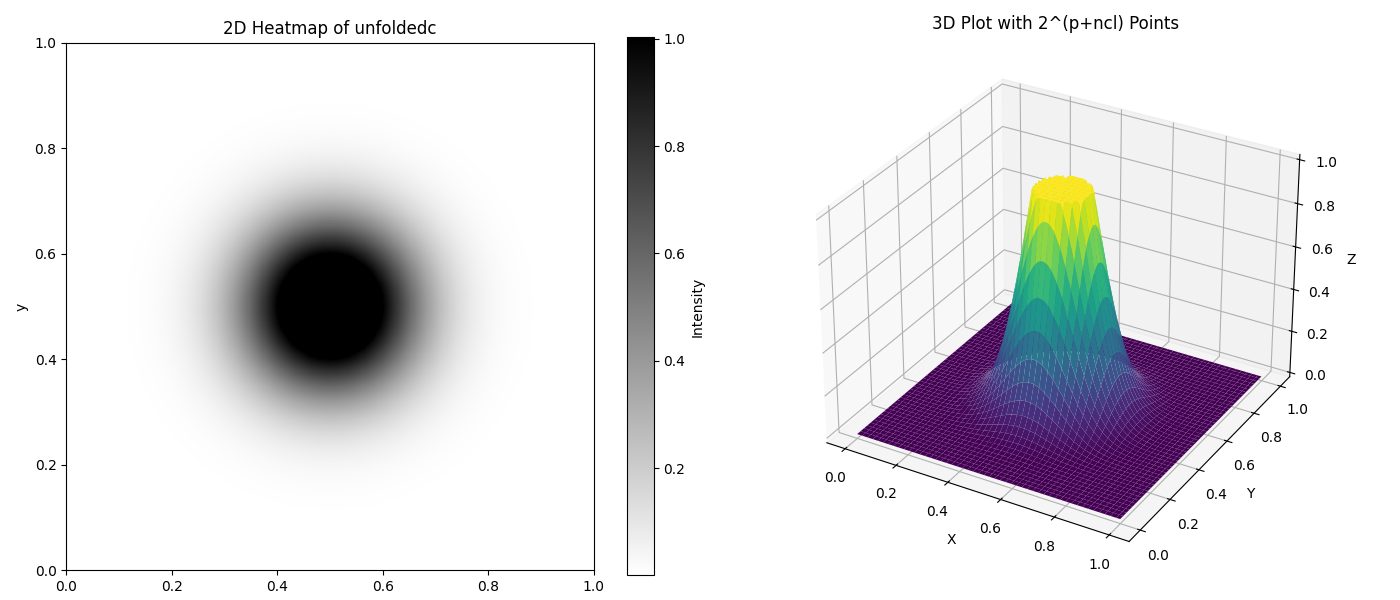

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, 16, 32, 62, 123, 244, 460, 256, 143, 80, 47, 29, 18, 11, 6, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 648590 compression 0.6185436248779297

error  3.89982e-04


In [481]:
#Generate approximation
M = tn.tensor([
    [1, 1, 0, 0],
    [0, 1, 1, 1],
    [0, 1, 0, 2],
    [0, 1, 0, 3]
], dtype=tn.float64)

Mi = M.inverse()

id = I_qtt(p)
delta = dmps(2**p -1,p)
rdelta = reversett(delta)
sm = R_qtt(2**(p)-1, p)
smx = tntt.kron(reversemtt(sm),id)
smy = tntt.kron(  reversemtt(id) , sm)
smxy = tntt.kron(reversemtt(sm),sm)



#boundary conditions
by = U1y
bx = U1x
P1y = tntt.TT( tn.tensor(pd_circle_b(runif.full(),1,type='xy'),dtype=tn.float64), [2]*p,eps=1e-15).round(1e-15)/H

#Geneare f matrix
I4 = tn.eye(4,dtype=tn.float64)
t4 = [ tntt.TT(I4[i]) for i in range(4)]
ftt = tntt.kron(t4[0], tntt.kron(mask,t4[0])) + tntt.kron(t4[0], tntt.kron(smy@mask + tntt.kron(by,delta),t4[1])) + tntt.kron(t4[1], tntt.kron(smx@mask + tntt.kron(rdelta,bx),t4[0])) + tntt.kron(t4[1], tntt.kron(smxy@mask + smx@tntt.kron(by,delta)+smy@tntt.kron(rdelta,bx) + Ff(1,1)*tntt.kron(rdelta,delta),t4[1]) )
ftt = ftt.round(1e-15)
dxmask = Pmps
dxftt = tntt.kron(t4[2], tntt.kron(dxmask,t4[0])) + tntt.kron(t4[2], tntt.kron(smy@dxmask + tntt.kron(P1y,delta),t4[1])) + tntt.kron(t4[3], tntt.kron(smx@dxmask + tntt.kron(rdelta,P1),t4[0])) + tntt.kron(t4[3], tntt.kron(smy@tntt.kron(rdelta,P1)+smxy@dxmask + smx@tntt.kron(P1y,delta),t4[1]) )
dymask = Qmps
dyftt = tntt.kron(t4[0], tntt.kron(dymask,t4[2])) + tntt.kron(t4[0], tntt.kron(smy@dymask + tntt.kron(Q1,delta),t4[3])) + tntt.kron(t4[1], tntt.kron(smx@dymask+tntt.kron(rdelta,Q1x),t4[2])) + tntt.kron(t4[1], tntt.kron(smxy@dymask + smx@tntt.kron(Q1,delta) + smy@tntt.kron(rdelta,Q1x),t4[3]) )
dxymask = Smps
dxyftt = tntt.kron(t4[2], tntt.kron(dxymask,t4[2])) + tntt.kron(t4[2], tntt.kron(smy@dxymask + tntt.kron(S1y,delta),t4[3])) + tntt.kron(t4[3], tntt.kron(smx@dxymask + tntt.kron(rdelta,S1x),t4[2])) + tntt.kron(t4[3], tntt.kron(smxy@dxymask + smy@tntt.kron(rdelta,S1x) +smx@tntt.kron(S1y,delta),t4[3]) )

#Geneare f matrix

fmtt = ftt + dxftt + dyftt + dxyftt
fmtt = fmtt.round(1e-15)
polsy = [tntt.kron( t4[i], tntt.TT(qtt_polynomial_cores(Mi[i], ncl)) ) for i in range(4)]
PY = 0
for i in range(4):
    PY += polsy[i]

PY = PY.round(1e-15)
PX = reversett(PY).round(1e-15)

maskCSN = connect(connect(PX,fmtt,pd=4),PY,pd=4).round(1e-15)

onesn = tntt.ones([2]*(ncl+p))
unifn = X_qtt(p+ncl)
#reverse X
Xn = tntt.kron( unifn,onesn)
Yn = tntt.kron( onesn,unifn)
mdc =  [Xn.full().reshape(NC), Yn.full().reshape(NC)]
rF = tn.tensor(fr(mdc),dtype=tn.float64)
unfoldedc = maskCSN.full().reshape([2**(p+ncl)]*2)[norder,:]

# Create a single figure with two subplots
fig = plt.figure(figsize=(14, 6))  # Adjust the figure size

# ---- First subplot: 2D Heatmap ----
ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
im = ax1.imshow(unfoldedc, cmap='binary', interpolation='none', extent=[0, 1, 0, 1])
ax1.set_title('2D Heatmap of unfoldedc')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Add colorbar to the heatmap
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Intensity")

# ---- Second subplot: 3D Surface Plot ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # 3D plot on the right
ax2.plot_surface(
    Xn.full().reshape(2**(p+ncl), 2**(p+ncl)), 
    Yn.full().reshape(2**(p+ncl), 2**(p+ncl)), 
    unfoldedc, 
    cmap='viridis'
)

# Set labels and title for 3D plot
ax2.set_title("3D Plot with 2^(p+ncl) Points")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Show the final combined figure
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

print(maskCS0)

errorcsN = (unfoldedc-rF).norm()/(rF).norm()
print(f"\033[93merror \033[0m {errorcsN.item():.5e}")

## Sequential Encoding

# 2D Taylor Expansion

In [20]:
# functions
def finite_diff_first(f, XY, h=1e-8, threshold=1e4):
    X, Y = XY
    dfdx = (f([X + h, Y]) - f([X - h, Y])) / (2 * h)
    dfdy = (f([X, Y + h]) - f([X, Y - h])) / (2 * h)
    dfdx = torch.where(dfdx.abs() > threshold, torch.zeros_like(dfdx), dfdx)
    dfdy = torch.where(dfdy.abs() > threshold, torch.zeros_like(dfdy), dfdy)
    return dfdx, dfdy

def finite_diff_second(f, XY, h=1e-8, threshold=1e3):
    X, Y = XY
    fxy = f([X, Y])
    d2fdx2 = (f([X + h, Y]) - 2 * fxy + f([X - h, Y])) / (h * h)
    d2fdy2 = (f([X, Y + h]) - 2 * fxy + f([X, Y - h])) / (h * h)
    d2fdxdy = (f([X + h, Y + h]) - f([X + h, Y - h]) - f([X - h, Y + h]) + f([X - h, Y - h])) / (4 * h * h)
    d2fdx2 = torch.where(d2fdx2.abs() > threshold, torch.zeros_like(d2fdx2), d2fdx2)
    d2fdy2 = torch.where(d2fdy2.abs() > threshold, torch.zeros_like(d2fdy2), d2fdy2)
    d2fdxdy = torch.where(d2fdxdy.abs() > threshold, torch.zeros_like(d2fdxdy), d2fdxdy)
    return d2fdx2, d2fdy2, d2fdxdy

def zJttpols(polstt, dir = 'f'):

    
    if dir == 'f':
        fcores = [polstt[i].cores[0] for i in range(len(polstt))]
        fc = torch.cat(fcores, dim=0)
    return [fc] + polstt[0].cores[1::]

def connectT(mps1,Tcores,pd=3):


    cores1 = mps1.cores
    cc = tn.einsum( 'ab,bcd -> acd', cores1[-1].reshape(-1,pd), Tcores[0])

    newcores = cores1[0:-1] + [cc] +  Tcores[1:]

    return tntt.TT(newcores)

#### Exact derivatives

In [21]:
# Build derivatives
p = 10
eps=1e-9
ones = tntt.ones([2]*p)
unif = X_qtt(p)
Xz = zkron(unif,ones)
Yz = zkron(ones,unif)
X = tntt.kron(unif,ones)
Y = tntt.kron(ones,unif)

mdz = [Xz.full(), Yz.full()]
#mdz = [X.full(), Y.full()]

fdx, fdy = finite_diff_first(fr,mdz)
fdxx, fdyy, fdxy = finite_diff_second(fr,mdz)

maz = tntt.TT( tn.tensor(fr(mdz),dtype=tn.float64), [4]*p,eps=eps)
mdx = tntt.TT( tn.tensor(fdx,dtype=tn.float64), [4]*p,eps=eps)
mdy = tntt.TT( tn.tensor(fdy,dtype=tn.float64), [4]*p,eps=eps)
mdxx = tntt.TT( tn.tensor(fdxx,dtype=tn.float64), [4]*p,eps=eps)
mdyy = tntt.TT( tn.tensor(fdyy,dtype=tn.float64), [4]*p,eps=eps)
mdxy = tntt.TT( tn.tensor(fdxy,dtype=tn.float64), [4]*p,eps=eps)

In [22]:
# Do Taylor Expansion
es = tn.eye(6,dtype=tn.float64)
pes = tn.eye(3,dtype=tn.float64)
ves = [tntt.TT(es[i],[6]) for i in range(6)]
zcoeffs = tntt.kron(maz,ves[0]) + tntt.kron(mdx,ves[1]) +tntt.kron(mdy,ves[2]) 
zcoeffs = zcoeffs.round(eps)
zcoeffs += (tntt.kron(mdxy,ves[3])+ tntt.kron(mdxx,ves[4])+   tntt.kron(mdyy,ves[5]) ).round(eps)
zcoeffs = zcoeffs.round(eps)

pols = [tntt.TT(qtt_polynomial_cores(pes[i]/2**((p)*i)/math.factorial(i), ncl, dir='f')) for i in range(3)]

pows = [zkron(pols[0],pols[0]), zkron(pols[1],pols[0]), zkron(pols[0],pols[1]), zkron(pols[2],pols[0]), zkron(pols[1],pols[1]), zkron(pols[0],pols[2])]
Ps = zJttpols(pows)

#pows = [tntt.kron(ves[0],zkron(pols[0],pols[0])), tntt.kron(ves[1],zkron(pols[1],pols[0])), tntt.kron(ves[2],zkron(pols[0],pols[1])),tntt.kron(ves[3],zkron(pols[1],pols[1])), tntt.kron(ves[4],zkron(pols[2],pols[0])), tntt.kron(ves[5],zkron(pols[0],pols[2]))]
#Ps = sum(pows).round(1e-12)
taymask = connectT(zcoeffs,Ps,pd=6).round(eps)
taymask

c:\Users\siddhartha.morales\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtt\_decomposition.py:365: RuntimeWarning: divide by zero encountered in scalar divide
  ep = eps/np.sqrt(d-1)


TT with sizes and ranks:
N = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
R = [1, 4, 16, 64, 246, 923, 823, 276, 96, 24, 6, 4, 1]

Device: cpu, dtype: torch.float64
#entries 5038572 compression 0.3003222942352295

In [23]:
NC = [2**(p+nlc),2**(p+nlc)]
unfolded = taymask.full()
#unfolded = tn.where(fdxy.abs() >1e3, 0,fdxy).reshape(2**p,2**p)

#unfolded = unfolded.round(decimals=10)
onesn = tntt.ones([2]*(p+nlc))
unifn = X_qtt(p+nlc)
#reverse X
Xn = zkron( unifn,onesn)
Yn = zkron( onesn,unifn)
mdc =  [Xn.full(), Yn.full()]
rF = tn.tensor(fr(mdc),dtype=tn.float64)
errorcsN = (unfolded-rF).norm()/(rF).norm()
print(f"\033[93merror \033[0m {errorcsN.item():.5e}")


error  4.92004e-05


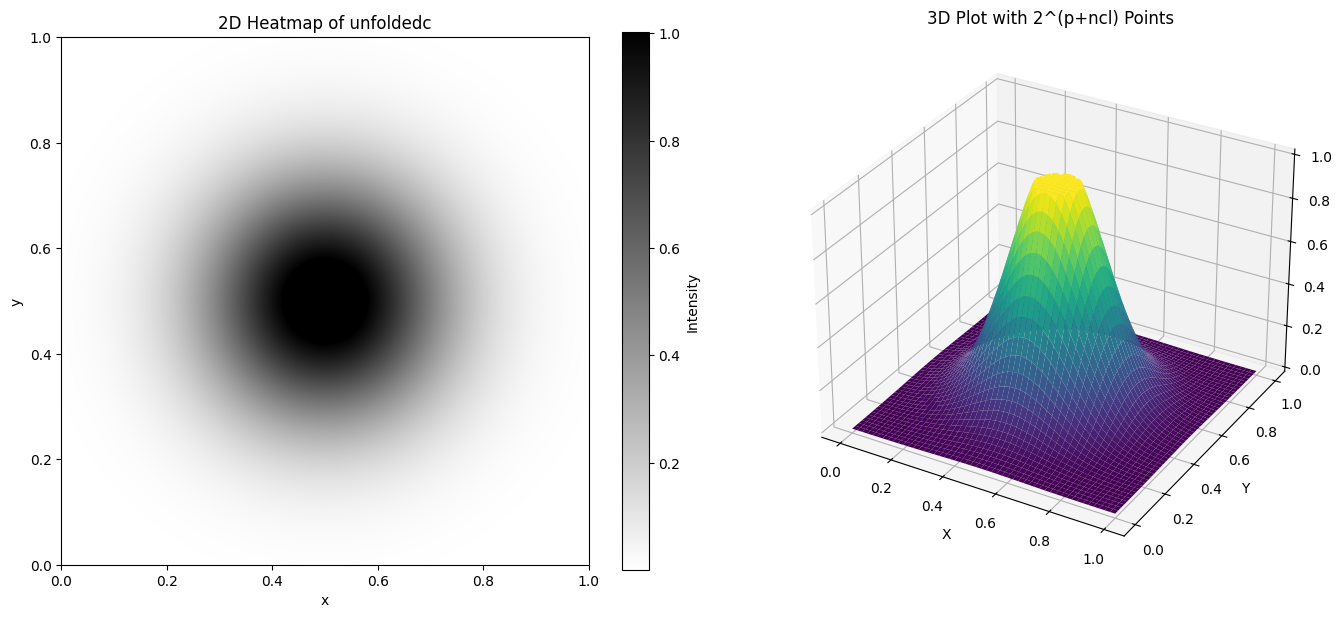

In [24]:
# Plot
Xn = tntt.kron( unifn,onesn)
Yn = tntt.kron( onesn,unifn)
unfolded = z_order_to_normal_torch(unfolded.reshape(-1),2**(p+nlc),2**(p+nlc) )
# Create a single figure with two subplots
fig = plt.figure(figsize=(14, 6))  # Adjust the figure size

# ---- First subplot: 2D Heatmap ----
ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
im = ax1.imshow(unfolded, cmap='binary', interpolation='none', extent=[0, 1, 0, 1])
ax1.set_title('2D Heatmap of unfoldedc')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Add colorbar to the heatmap
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Intensity")

# ---- Second subplot: 3D Surface Plot ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # 3D plot on the right
ax2.plot_surface(
    Xn.full().reshape(2**(p+nlc), 2**(p+nlc)), 
    Yn.full().reshape(2**(p+nlc), 2**(p+nlc)), 
    unfolded, 
    cmap='viridis'
)

# Set labels and title for 3D plot
ax2.set_title("3D Plot with 2^(p+ncl) Points")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Show the final combined figure
plt.tight_layout()  # Adjust layout for better spacing
plt.show()




#### Approximated derivatives

In [29]:

acc = 2
o = 2
c1d = forward_diff_coeffs_accuracy(2,acc,1)
#c1d = forward_diff_coeffs(2**o,2,1)
dvecs = [tn.kron(c1d[0],c1d[0]), tn.kron(c1d[1],c1d[0]), tn.kron(c1d[0],c1d[1]), tn.kron(c1d[2],c1d[0]), tn.kron(c1d[1],c1d[1]), tn.kron(c1d[0],c1d[2])]
dop = tn.stack(dvecs,dim=1)
pes = tn.eye(3,dtype=tn.float64)

# Build derivatives
p = 13
eps=1e-12
ones = tntt.ones([2]*p)
unif = X_qtt(p)
Xz = zkron(unif,ones)
Yz = zkron(ones,unif)
X = tntt.kron(unif,ones)
Y = tntt.kron(ones,unif)

mdz = [Xz.full(), Yz.full()]
#mdz = [X.full(), Y.full()]

maz = tntt.TT( tn.tensor(fr(mdz),dtype=tn.float64), [4]*p,eps=eps)
mdz = apply_local_op( tntt.reshape(maz, [4]*(p-o) + [4**o]),-1,dop) 
print('done')

pols = [tntt.TT(qtt_polynomial_cores(pes[i]*2**((o)*i)/math.factorial(i), ncl, dir='f')) for i in range(3)]

pows = [zkron(pols[0],pols[0]), zkron(pols[1],pols[0]), zkron(pols[0],pols[1]), zkron(pols[2],pols[0]), zkron(pols[1],pols[1]), zkron(pols[0],pols[2])]
Ps = zJttpols(pows)

#pows = [tntt.kron(ves[0],zkron(pols[0],pols[0])), tntt.kron(ves[1],zkron(pols[1],pols[0])), tntt.kron(ves[2],zkron(pols[0],pols[1])),tntt.kron(ves[3],zkron(pols[1],pols[1])), tntt.kron(ves[4],zkron(pols[2],pols[0])), tntt.kron(ves[5],zkron(pols[0],pols[2]))]
#Ps = sum(pows).round(1e-12)
taymask = connectT(mdz,Ps,pd=6).round(eps)
taymask

done


TT with sizes and ranks:
N = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
R = [1, 4, 16, 62, 63, 56, 72, 105, 175, 96, 24, 6, 4, 1]

Device: cpu, dtype: torch.float64
#entries 230948 compression 0.0034413933753967285

In [30]:
p -= o
NC = [2**(p+nlc),2**(p+nlc)]
unfolded = taymask.full()
#unfolded = tn.where(fdxy.abs() >1e3, 0,fdxy).reshape(2**p,2**p)

#unfolded = unfolded.round(decimals=10)
onesn = tntt.ones([2]*(p+nlc))
unifn = X_qtt(p+nlc)
#reverse X
Xn = zkron( unifn,onesn)
Yn = zkron( onesn,unifn)
mdc =  [Xn.full(), Yn.full()]
rF = tn.tensor(fr(mdc),dtype=tn.float64)
errorcsN = (unfolded-rF).norm()/(rF).norm()
print(f"\033[93merror \033[0m {errorcsN.item():.5e}")


error  1.87714e-02


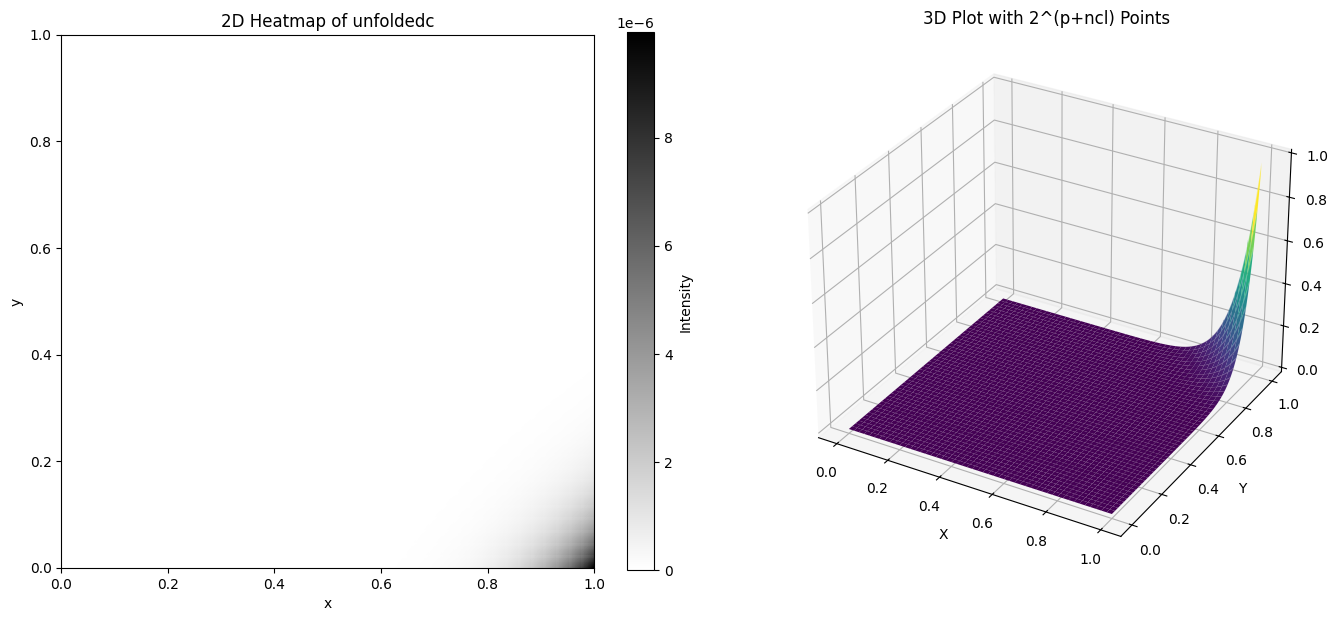

In [ ]:
# Plot
Xn = tntt.kron( unifn,onesn)
Yn = tntt.kron( onesn,unifn)
unfolded = z_order_to_normal_torch(unfolded.reshape(-1),2**(p+nlc),2**(p+nlc) )
# Create a single figure with two subplots
fig = plt.figure(figsize=(14, 6))  # Adjust the figure size

# ---- First subplot: 2D Heatmap ----
ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
im = ax1.imshow(unfolded, cmap='binary', interpolation='none', extent=[0, 1, 0, 1])
ax1.set_title('2D Heatmap of unfoldedc')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Add colorbar to the heatmap
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Intensity")

# ---- Second subplot: 3D Surface Plot ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # 3D plot on the right
ax2.plot_surface(
    Xn.full().reshape(2**(p+nlc), 2**(p+nlc)), 
    Yn.full().reshape(2**(p+nlc), 2**(p+nlc)), 
    unfolded, 
    cmap='viridis'
)

# Set labels and title for 3D plot
ax2.set_title("3D Plot with 2^(p+ncl) Points")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Show the final combined figure
plt.tight_layout()  # Adjust layout for better spacing
plt.show()




In [ ]:
# Plot
Xn = tntt.kron( unifn,onesn)
Yn = tntt.kron( onesn,unifn)
unfolded = z_order_to_normal_torch(mdz.full().reshape(-1),2**(p+nlc),2**(p+nlc) )
# Create a single figure with two subplots
fig = plt.figure(figsize=(14, 6))  # Adjust the figure size

# ---- First subplot: 2D Heatmap ----
ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
im = ax1.imshow(unfolded, cmap='binary', interpolation='none', extent=[0, 1, 0, 1])
ax1.set_title('2D Heatmap of unfoldedc')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Add colorbar to the heatmap
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Intensity")

# ---- Second subplot: 3D Surface Plot ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # 3D plot on the right
ax2.plot_surface(
    Xn.full().reshape(2**(p+nlc), 2**(p+nlc)), 
    Yn.full().reshape(2**(p+nlc), 2**(p+nlc)), 
    unfolded, 
    cmap='viridis'
)

# Set labels and title for 3D plot
ax2.set_title("3D Plot with 2^(p+ncl) Points")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Show the final combined figure
plt.tight_layout()  # Adjust layout for better spacing
plt.show()




# Image Processing

In [107]:
# Load Image
import urllib.request
import os
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import zoom


# 1. Download Lena if it's not already in the current directory

local_filename = "rag.png"


# 2. Read the image in color
image_color = cv2.imread(local_filename, cv2.IMREAD_COLOR)
height, width, channels = image_color.shape  # shape gives (height, width, channels)

# 4. Print the resolution
print(f"Initial Resolution: {width}x{height} (Width x Height)")

# 3. Convert to grayscale (black-and-white)
image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

# 4. Resize to 512x512 (if needed) using INTER_AREA for initial sizing
image_gray_128 = cv2.resize(image_gray, (128, 128), interpolation=cv2.INTER_AREA)

img_scipy = zoom(image_gray_128, (8192 / image_gray_128.shape[0], 8192 / image_gray_128.shape[1]), order=3)



Initial Resolution: 595x549 (Width x Height)


In [ ]:
# 5. Upscale to 1024x1024 using cubic interpolation
image_gray_1024 = cv2.resize(image_gray_128, (2**13, 2**13), interpolation=cv2.INTER_CUBIC)

# 6. Display the results inline
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

axes[0].imshow(image_gray, cmap='gray')
axes[0].set_title(f"Original ({width}x{height})")
axes[0].axis("off")


axes[1].imshow(image_gray_128, cmap='gray')
axes[1].set_title("Compressed (128x128)")
axes[1].axis("off")

axes[2].imshow(image_gray_1024, cmap='gray')
axes[2].set_title("R cv2 (8192x8192)")
axes[2].axis("off")

axes[3].imshow(image_gray_1024, cmap='gray')
axes[3].set_title("R scipy (8192x8192)")
axes[3].axis("off")


plt.tight_layout()
plt.show()

In [109]:
#Converte the image into an mps
o7 = bit_reverse_indices(7)
exdim = 6
oN = bit_reverse_indices(7+exdim)
image0 = tntt.TT(tn.tensor(image_gray_128[o7,:],dtype=tn.float64),[2,2]*7,eps=1e-15)
image0

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, 16, 32, 64, 128, 64, 32, 16, 8, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 43688 compression 2.66650390625

In [111]:
# Cubic spline with approximated detivatives
id = I_qtt(7)
sm = R_qtt(2**(7)-1, 7)
smx = tntt.kron(reversemtt(sm),id)
smy = tntt.kron(  reversemtt(id) , sm)
smxy = tntt.kron(reversemtt(sm),sm)
Dop = R_qtt( 2**7 -1, 7,dtype = tn.float64) - L_qtt( 1, 7 ,dtype = tn.float64) - 2*dmpo(0,0,7) + dmpo(0,1,7) +  2*dmpo(2**7 -1,2**7 -1,7) - dmpo(2**7 -1,2**7 -2,7)
Dop = (Dop/2).round(1e-15)
Dx = tntt.kron( reversemtt(Dop),id)
Dy = tntt.kron( reversemtt(id),Dop)
Dxy = tntt.kron( reversemtt(Dop),Dop)

#Generate approximation
M = tn.tensor([
    [1, 1, 0, 0],
    [0, 1, 1, 1],
    [0, 1, 0, 2],
    [0, 1, 0, 3]
], dtype=tn.float64)

Mi = M.inverse()

#Geneare f matrix
I4 = tn.eye(4,dtype=tn.float64)
t4 = [ tntt.TT(I4[i]) for i in range(4)]
ftt = tntt.kron(t4[0], tntt.kron(image0,t4[0])) + tntt.kron(t4[0], tntt.kron(smy@image0,t4[1])) + tntt.kron(t4[1], tntt.kron(smx@image0,t4[0])) + tntt.kron(t4[1], tntt.kron(smxy@image0,t4[1]) )
dxmask = (Dx @ image0).round(1e-15)
dxftt = tntt.kron(t4[2], tntt.kron(dxmask,t4[0])) + tntt.kron(t4[2], tntt.kron(smy@dxmask,t4[1])) + tntt.kron(t4[3], tntt.kron(smx@dxmask,t4[0])) + tntt.kron(t4[3], tntt.kron(smxy@dxmask,t4[1]) )
dymask = (Dy @ image0).round(1e-15)
dyftt = tntt.kron(t4[0], tntt.kron(dymask,t4[2])) + tntt.kron(t4[0], tntt.kron(smy@dymask,t4[3])) + tntt.kron(t4[1], tntt.kron(smx@dymask,t4[2])) + tntt.kron(t4[1], tntt.kron(smxy@dymask,t4[3]) )
dxymask = (Dxy @ image0).round(1e-15)
dxyftt = tntt.kron(t4[2], tntt.kron(dxymask,t4[2])) + tntt.kron(t4[2], tntt.kron(smy@dxymask,t4[3])) + tntt.kron(t4[3], tntt.kron(smx@dxymask,t4[2])) + tntt.kron(t4[3], tntt.kron(smxy@dxymask,t4[3]) )

#Geneare f matrix

fmtt = ftt + dxftt + dyftt + dxyftt
fmtt = fmtt.round(1e-15)

polsy = [tntt.kron( t4[i], tntt.TT(qtt_polynomial_cores(Mi[i], exdim)) ) for i in range(4)]
#polsx = [tntt.kron( tntt.TT(qtt_polynomial_cores(Mi[i], exdim , dir='b')), t4[i] ) for i in range(4)]
PY = 0
for i in range(4):
    PY += polsy[i]
PY = PY.round(1e-15)
PX = reversett(PY).round(1e-15)

image0e = connect(connect(PX,fmtt,pd=4),PY,pd=4).round(1e-15)
image0e

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 4, 4, 4, 4, 8, 16, 32, 62, 123, 244, 130, 68, 36, 20, 12, 8, 6, 4, 4, 4, 4, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 169156 compression 0.002520620822906494

In [112]:
Mkc = tn.tensor([
    [0, 2, 0, 0],
    [-1, 0, 1, 0],
    [2, -5, 4, -1],
    [-1, 3, -3, 1]
], dtype=tn.float64) /2

Mkct = Mkc.t()
id = I_qtt(7)
idr = reversemtt(id)
sm1 = R_qtt( 2**7 -1, 7)
sm2 = R_qtt( 2**7 -2, 7)
smm1 = L_qtt( 1, 7)

#reverse the operators for the first dimension
sm1x = reversemtt(sm1)
smm1x = reversemtt(smm1)

#boundary conditions
delta = dmps(2**7 -1,7)
rdelta = reversett(delta)
by = tntt.zeros([2]*7)
mby = tntt.kron(by,delta)
bx = tntt.zeros([2]*7)
mbx = tntt.kron(rdelta,bx)
I4 = tn.eye(4,dtype=tn.float64)
t4 = [ tntt.TT(I4[i]) for i in range(4)]

# encode the image0 piece by piece (4x4)
#let's start with the pieces without boundary conditions
image1  = kron3(t4[1],image0,t4[1]) + kron3(t4[1],tntt.kron(idr,sm1)@image0 + mby,t4[2]) + kron3(t4[2],tntt.kron(sm1x,id)@image0 + mbx,t4[1]) + kron3(t4[2],tntt.kron(sm1x,sm1)@image0 + tntt.kron(sm1x,id)@mby + tntt.kron(idr,sm1)@mbx,t4[2])
#minus one operatos
Oym1 = (smm1 + 3*dmpo(0,0,7) - 3*dmpo(0,1,7) + dmpo(0,2,7)).round(1e-15)
Oxm1 = reversemtt(Oym1)
image1 += kron3(t4[0],tntt.kron(Oxm1,Oym1)@image0,t4[0]) + kron3(t4[0],tntt.kron(Oxm1,id)@image0,t4[1]) + kron3(t4[0],tntt.kron(Oxm1,sm1)@image0+ tntt.kron(Oxm1,id)@mby,t4[2]) + kron3(t4[1],tntt.kron(idr,Oym1)@image0,t4[0]) + kron3(t4[2],tntt.kron(sm1x,Oym1)@image0+ tntt.kron(idr,Oym1)@mbx,t4[0])
#image1 = image1.round(1e-10)
#plus two operators
Oy2 = (sm2 - 3*dmpo(2**7-1,2**7-1,7) + dmpo(2**7-1,2**7-2,7)).round(1e-15)
Ox2 = reversemtt(Oy2)
mby2 = tntt.kron(by,dmps(2**7 -2,7) + 3*dmps(2**7 -1,7)).round(1e-15)
mbx2 = tntt.kron( reversett( dmps(2**7 -2,7) + 3*dmps(2**7 -1,7)), bx).round(1e-15)
image1 += kron3(t4[3], tntt.kron(Ox2,smm1)@image0 + tntt.kron(idr,smm1)@mbx2 ,t4[0] ) + kron3(t4[0], tntt.kron(smm1x,Oy2)@image0 + tntt.kron(smm1x,id)@mby2 ,t4[3] ) + kron3(t4[3], tntt.kron(Ox2,id)@image0 + mbx2 ,t4[1] ) + kron3(t4[1], tntt.kron(idr,Oy2)@image0 + mby2 ,t4[3] )
image1 += kron3(t4[3], tntt.kron(Ox2,sm1)@image0 + tntt.kron(idr,sm1)@ mbx2 + tntt.kron(Ox2,id)@mby ,t4[2] ) + kron3(t4[2], tntt.kron(sm1x,Oy2)@image0 + tntt.kron(idr,Oy2)@ mbx + tntt.kron(sm1x,id)@mby2 ,t4[3] )
image1 += kron3(t4[3], tntt.kron(Ox2,Oy2)@image0 + tntt.kron(idr,Oy2)@ mbx2 + tntt.kron(Ox2,id)@mby2 ,t4[3] ) 
image1 = image1.round(1e-15) 

polsy = [tntt.kron( t4[i], tntt.TT(qtt_polynomial_cores(Mkct[i], exdim)) ) for i in range(4)]
#polsx = [tntt.kron( tntt.TT(qtt_polynomial_cores(Mkct[i], exdim, dir='b')), t4[i] ) for i in range(4)]
PY = 0
for i in range(4):
    PY += polsy[i]

PY = PY.round(1e-15)
PX = reversett(PY).round(1e-15)

image1e = connect(connect(PX,image1,pd=4),PY,pd=4).round(1e-15)
print(image1e)




TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 4, 4, 4, 4, 8, 16, 32, 62, 123, 240, 180, 93, 50, 29, 18, 10, 6, 4, 4, 4, 4, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 213552 compression 0.0031821727752685547



In [ ]:
pmagic(True)

In [ ]:
ndim = 7 + exdim
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# 6. Display the results inline
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

axes[0].imshow(image0.full().reshape(2**7,2**7)[o7,:], cmap='gray')
axes[0].set_title("Original (128x128)")
axes[0].axis("off")

axes[1].imshow(image_gray_128, cmap='gray')
axes[1].set_title("Compressed (128x128)")
axes[1].axis("off")

axes[2].imshow(image0e.full().reshape(2**ndim,2**ndim)[oN,:], cmap='gray')
axes[2].set_title("CS0 Reconstruction")
axes[2].axis("off")

axes[3].imshow(image1e.full().reshape(2**ndim,2**ndim)[oN,:], cmap='gray')
axes[3].set_title("KCS Reconstruction")
axes[3].axis("off")

plt.tight_layout()
plt.show()

## 2D cubic covolution cubic spline


## 2D cubic spline with boundary conditions

In order to solve this type of problems, we need to define a system of equations with proper indexes

In [ ]:
1/2**48

In [ ]:
D = tn.tensor([[1,0,0,0],[1,1,1,1],[0,1,2,3],[0,0,1,3]], dtype=tn.float64)
Dt = D.t()
S = tn.tensor([[0,0,0,0],[0,0,0,0],[0,1,0,0],[0,0,1,0]], dtype=tn.float64)
St = S.t()
L = tn.tensor([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,1,0]], dtype=tn.float64)
Lt = L.t()
R = tn.tensor([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,1,3]], dtype=tn.float64)
Rt = R.t()

Sf = tn.tensor([[1,0,0,0],[1,0,0,0],[0,0,0,0],[0,0,0,0]], dtype=tn.float64)
Stf = Sf.t()

Dtt = tntt.TT(D,[(4,4)])
DTtt = tntt.TT(Dt,[(4,4)])
Stt = tntt.TT(S,[(4,4)])
STtt = tntt.TT(St,[(4,4)])
Ltt = tntt.TT(L,[(4,4)])
LTtt = tntt.TT(Lt,[(4,4)])
Rtt = tntt.TT(R,[(4,4)])
RTtt = tntt.TT(Rt,[(4,4)])
Sftt = tntt.TT(Sf,[(4,4)])
STftt = tntt.TT(Stf,[(4,4)])
id = I_qtt(p)
sm = R_qtt(2**(p)-1, p)
smx = tntt.kron(reversemtt(sm),id)
smy = tntt.kron(  id , sm)
smxy = tntt.kron(reversemtt(sm),sm)
#diffO = (-I_qtt(nc)+sm).round(1e-15)
e0 = tntt.TT(tn.tensor([1,0,0,0],dtype=tn.float64),[4])
e1 = tntt.TT(tn.tensor([0,1,0,0],dtype=tn.float64),[4])

bd = dmps(2**(p) -1,p)
F = lambda x: 0
maskbd = tntt.kron(e1, tntt.kron(tntt.kron(reversett(bd),ones)*F(tn.tensor(1)),e0)) + tntt.kron(e0,tntt.kron(tntt.kron(ones,bd)*F(tn.tensor(1)),e1)) + tntt.kron(e1,tntt.kron(tntt.kron(bd, bd)*F(tn.tensor(1)),e1))
maskbd = maskbd.round(1e-15)

bigO = tntt.kron(Dtt,tntt.kron( tntt.kron(reversemtt(id), id),DTtt)) - tntt.kron(Stt, tntt.kron( tntt.kron(reversemtt(sm),id) ,STftt) ) - tntt.kron(Sftt, tntt.kron( tntt.kron(id,sm) ,STtt) ) - tntt.kron(Stt, tntt.kron( tntt.kron(reversemtt(sm),sm) ,STtt) ) 
bigO += tntt.kron(Ltt,tntt.kron( tntt.kron(id,dmpo(2**p-1,0,p)), LTtt)) + tntt.kron( Rtt,tntt.kron(tntt.kron(id,dmpo(2**p-1,2**p-1,p)), RTtt) )
bigO = bigO.round(1e-15)
RHS = tntt.kron(e0, tntt.kron(mask,e0) )+ tntt.kron(e0, tntt.kron(smy @ mask,e1)) + tntt.kron(e1, tntt.kron(smx @ mask,e0)) + tntt.kron(e1, tntt.kron(smxy @ mask,e1))
RHS = RHS.round(1e-15) + maskbd
RHS = RHS.round(1e-15) 



In [ ]:
bigO, RHS

In [ ]:
coefs = tntt.solvers.amen_solve(bigO, RHS, eps=1e-15,kickrank=2,nswp=30).round()

# Miscelaneous

In [ ]:
# Independent modules
import torch as tn
import torchtt as tntt
import numpy as np

## Gray encoding

In [110]:

def gray_encoding(I):
    l = I.shape[1]
    Ig = tn.cumsum(I,dim=0) %2
    powers = tn.tensor([2**(-i) for i in range(1,l+1)])
    wI = powers*Ig
    return wI.sum(axis=1)

In [111]:
p = 20
N = [2]*p
f = lambda x : 3*x**4 +  x**2 + x + 2
gf = lambda x : f(gray_encoding(x))
x = tntt.interpolate.dmrg_cross(gf, N, eps = 1e-15,kick=1)

x.round()

TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, 16, 32, 64, 126, 242, 304, 182, 93, 49, 26, 15, 12, 9, 7, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 387436 compression 0.3694877624511719

## Operators

In [112]:
def R_shift(L,delta):

    R = tn.zeros(L,L)

    for i in range( L):
        if L-2 < i + i*delta:
            break
        R[i,i + i*delta+1] = 1
    return R

In [113]:
p = 10
rtt = tntt.TT(R_shift(2**p,3), [(2,2)]*p).round(1e-6)
rtt

TT-matrix with sizes and ranks:
M = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 4, 7, 9, 10, 15, 11, 4, 1]
Device: cpu, dtype: torch.float32
#entries 2280 compression 0.00217437744140625

In [114]:
rtt.full().reshape(2**p,2**p).round(decimals=9)

tensor([[-3.5400e-07,  1.0000e+00, -3.8000e-08,  ..., -0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 8.8000e-08,  8.9000e-08,  2.8800e-07,  ..., -0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 5.2200e-07, -2.4000e-07, -4.6500e-07,  ...,  0.0000e+00,
         -0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

In [ ]:
R_shift(2**4,2)

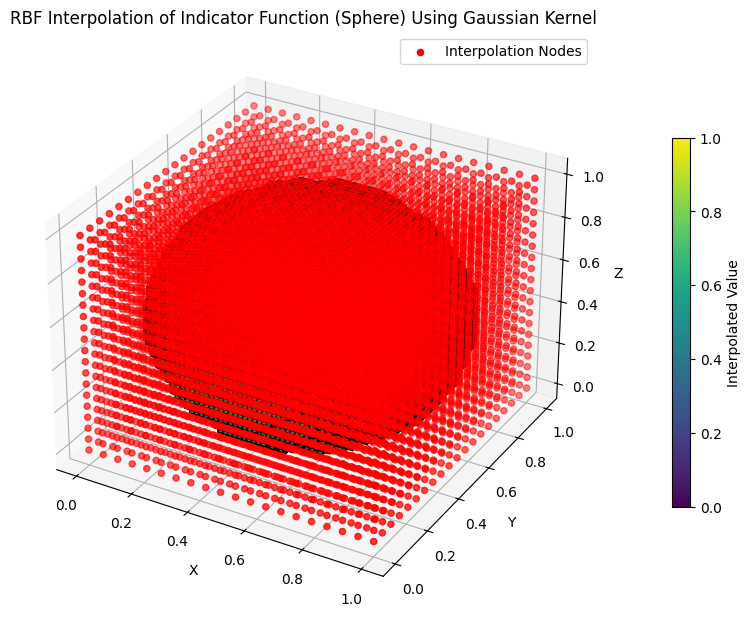

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import matplotlib.colors as colors
import matplotlib.cm as cm

# --- Step 1: Create a uniform meshgrid over the unit cube ---
N = 20  # Number of points per dimension (for interpolation nodes)
points_lin = np.linspace(0, 1, N)
X, Y, Z = np.meshgrid(points_lin, points_lin, points_lin, indexing='ij')

# Flatten the grid arrays for RBF interpolation
x = X.flatten()
y = Y.flatten()
z = Z.flatten()

# --- Step 2: Define the binary indicator function ---
# f = 1 if (x,y,z) is inside the sphere centered at (0.5,0.5,0.5) with radius 0.5; 0 otherwise.
center = np.array([0.5, 0.5, 0.5])
radius = 0.5
f_values = (((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2) <= radius**2).astype(float)

# --- Step 3: Build the RBF interpolator using a Gaussian kernel ---
rbf = Rbf(x, y, z, f_values, function='gaussian')

# --- Step 4: Evaluate the interpolant on a finer grid ---
fine_res = 60  # Finer grid resolution for evaluation
fine_grid_x, fine_grid_y, fine_grid_z = np.mgrid[0:1:fine_res*1j,
                                                 0:1:fine_res*1j,
                                                 0:1:fine_res*1j]
fine_grid_f = rbf(fine_grid_x, fine_grid_y, fine_grid_z)

# Determine which voxels to display using a threshold.
threshold = 0.5
voxels = fine_grid_f > threshold

# --- Prepare facecolors using a colormap ---
# We create an RGBA array for the fine grid values.
# Here, we normalize values between 0 and 1 (since our indicator function is binary)
norm = colors.Normalize(vmin=0, vmax=1)
cmap = cm.viridis
facecolors = cmap(norm(fine_grid_f))

# --- Step 5: Plot the result in 3D using voxels with a colorbar ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# For ax.voxels, coordinate arrays must have shape (fine_res+1, fine_res+1, fine_res+1)
points_lin_voxels = np.linspace(0, 1, fine_res + 1)
vx, vy, vz = np.meshgrid(points_lin_voxels, points_lin_voxels, points_lin_voxels, indexing='ij')

# Plot the voxels, using the facecolors computed from the interpolated values.
# Voxels will be displayed only where 'voxels' is True.
ax.voxels(vx, vy, vz, voxels, facecolors=facecolors, edgecolor='k', alpha=0.8)

# Optionally, plot the original interpolation nodes
ax.scatter(x, y, z, color='red', s=20, label='Interpolation Nodes')

ax.set_title("RBF Interpolation of Indicator Function (Sphere) Using Gaussian Kernel")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

# Create a ScalarMappable for the colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Interpolated Value")

plt.show()


C:\Users\siddhartha.morales\AppData\Local\Temp\ipykernel_23336\839784493.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
C:\Users\siddhartha.morales\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


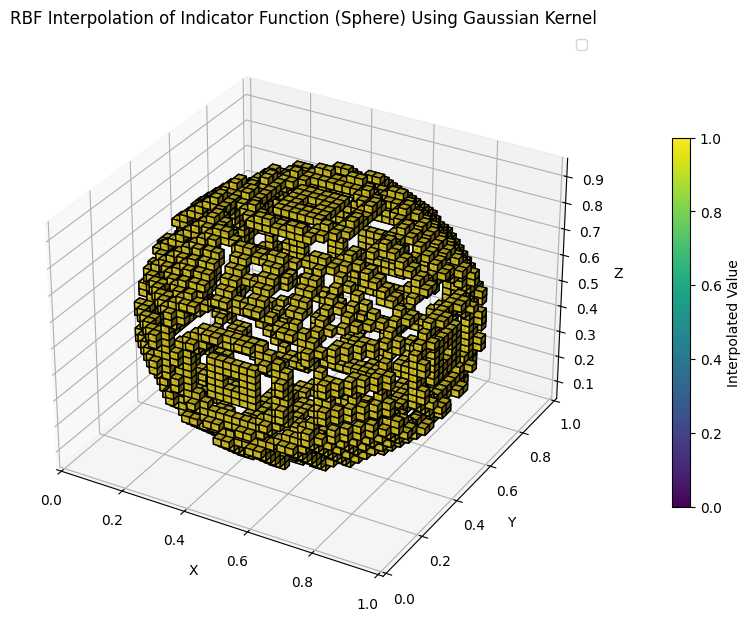

In [28]:
# --- Step 4: Evaluate the interpolant on a finer grid ---
fine_res = 40  # Finer grid resolution for evaluation
fine_grid_x, fine_grid_y, fine_grid_z = np.mgrid[0:1:fine_res*1j,
                                                 0:1:fine_res*1j,
                                                 0:1:fine_res*1j]
fine_grid_f = rbf(fine_grid_x, fine_grid_y, fine_grid_z)

# Determine which voxels to display using a threshold.
threshold = 1.1
voxels = fine_grid_f > threshold


# --- Prepare facecolors using a colormap ---
# We create an RGBA array for the fine grid values.
# Here, we normalize values between 0 and 1 (since our indicator function is binary)
norm = colors.Normalize(vmin=0, vmax=1)
cmap = cm.viridis
facecolors = cmap(norm(fine_grid_f))

# --- Step 5: Plot the result in 3D using voxels with a colorbar ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# For ax.voxels, coordinate arrays must have shape (fine_res+1, fine_res+1, fine_res+1)
points_lin_voxels = np.linspace(0, 1, fine_res + 1)
vx, vy, vz = np.meshgrid(points_lin_voxels, points_lin_voxels, points_lin_voxels, indexing='ij')

# Plot the voxels, using the facecolors computed from the interpolated values.
# Voxels will be displayed only where 'voxels' is True.
ax.voxels(vx, vy, vz, voxels, facecolors=facecolors, edgecolor='k', alpha=0.8)

# Optionally, plot the original interpolation nodes
#ax.scatter(x, y, z, color='red', s=20, label='Interpolation Nodes')

ax.set_title("RBF Interpolation of Indicator Function (Sphere) Using Gaussian Kernel")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

# Create a ScalarMappable for the colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Interpolated Value")

plt.show()